In [42]:
#Import all necessary modules
from collections import defaultdict
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('ggplot')
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
import scipy.stats as sc
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy import stats
%matplotlib inline 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.model_selection import cross_validate, cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf as acf
from statsmodels.graphics.tsaplots import plot_pacf as pacf
from sklearn.model_selection import TimeSeriesSplit

In [43]:
#Font Sizes
#SMALL_SIZE = 8
#MEDIUM_SIZE = 10
#BIGGER_SIZE = 12

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [44]:
#Read in the data
df = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/Lucknow_Pollution_Data.csv')
df.head()

From (Time) To (Time)        Date  PM_25_ug_m3  SO2_ug_m3  \
0  2016-01-01 00:00:00  00:59:00  01/01/2016       315.87      13.08   
1  2016-01-01 01:00:00  01:59:00  01/01/2016       353.05      25.59   
2  2016-01-01 02:00:00  02:59:00  01/01/2016       352.82      12.16   
3  2016-01-01 03:00:00  03:59:00  01/01/2016       264.70      18.25   
4  2016-01-01 04:00:00  04:59:00  01/01/2016       217.19       6.89   

   O3_ug_m3  CO_mg_m3  NOX_ppb  NO2_ug_m3  NO_ug_m3  Temp_C  Rel_Hum_%  \
0       NaN      8.90    25.22      10.36     28.53   14.19        NaN   
1       NaN      9.98    26.18       8.64     31.02   14.03        NaN   
2       NaN     11.63    29.62       4.79     38.34   13.62        NaN   
3       NaN      4.83    18.97      10.63     19.96   13.45        NaN   
4       NaN      2.91     7.53      13.43      2.68   12.97        NaN   

   Wind_spd_m_s  Wind_dir_deg  Solar_R_W_m2  Bar_P_mmHg    T_m    D_m  \
0           NaN           NaN           NaN         NaN   8.26   7.41   
1           NaN           NaN           NaN         NaN   7.01   7.01   
2           NaN           NaN           NaN         NaN   7.01   7.01   
3           NaN           NaN           NaN         NaN   9.71   9.16   
4           NaN           NaN           NaN         NaN  13.51  12.51   

   RH_NOAA_augroch  
0        94.379038  
1       100.000000  
2       100.000000  
3        96.371457  
4        93.675175

In [45]:
#Convert date column to a date time column and drop unnecessary columns. The ambient and dew temperature as well as relative humidity 
#were used from another source
df['From (Time)'] = pd.to_datetime(df['From (Time)'])
#df['Date'] = pd.to_datetime(df['Date'])
#df['To (Time)'] = pd.to_datetime(df['To (Time)']).dt.time
df.drop(df[['To (Time)','Date','Temp_C','Rel_Hum_%']], axis = 1,inplace=True)

In [46]:
df.dtypes

From (Time)        datetime64[ns]
PM_25_ug_m3               float64
SO2_ug_m3                 float64
O3_ug_m3                  float64
CO_mg_m3                  float64
NOX_ppb                   float64
NO2_ug_m3                 float64
NO_ug_m3                  float64
Wind_spd_m_s              float64
Wind_dir_deg              float64
Solar_R_W_m2              float64
Bar_P_mmHg                float64
T_m                       float64
D_m                       float64
RH_NOAA_augroch           float64
dtype: object

In [47]:
#Set index for plotting time series during later exploration
df = df.set_index('From (Time)')

In [48]:
df.isna().sum()

PM_25_ug_m3         2170
SO2_ug_m3           2363
O3_ug_m3            5059
CO_mg_m3            2257
NOX_ppb             2239
NO2_ug_m3           2334
NO_ug_m3            2799
Wind_spd_m_s       10502
Wind_dir_deg        5356
Solar_R_W_m2        4719
Bar_P_mmHg          4699
T_m                 1222
D_m                 1221
RH_NOAA_augroch     1227
dtype: int64

In [49]:
#Checking missing values
missing = pd.concat([df.isna().sum(), 100 * df.isna().mean()], axis=1)
missing.columns = ['Count','%']
missing.sort_values('Count',ascending=False)

Count          %
Wind_spd_m_s     10502  28.891334
Wind_dir_deg      5356  14.734525
O3_ug_m3          5059  13.917469
Solar_R_W_m2      4719  12.982118
Bar_P_mmHg        4699  12.927098
NO_ug_m3          2799   7.700138
SO2_ug_m3         2363   6.500688
NO2_ug_m3         2334   6.420908
CO_mg_m3          2257   6.209078
NOX_ppb           2239   6.159560
PM_25_ug_m3       2170   5.969739
RH_NOAA_augroch   1227   3.375516
T_m               1222   3.361761
D_m               1221   3.359010

Wind speed shows the largest amount of missing data followed by wind direction. The response variable PM25 has 5% of its data missing.
Next, lets check yearly data for proportion of missing values

In [50]:
df_2016 = df.loc['2016-01-01 00:00:00':'2016-12-31 23:00:00',:]
miss_2016 = pd.concat([df_2016.isna().sum(),100*df_2016.isna().mean()],axis=1)
miss_2016.columns = ['Count','%']
miss_2016.sort_values('Count',ascending=False)

Count          %
Wind_spd_m_s      3613  49.083005
Wind_dir_deg      3352  45.537291
O3_ug_m3          3038  41.271566
Bar_P_mmHg        2957  40.171172
Solar_R_W_m2      2954  40.130417
CO_mg_m3           262   3.559299
NO_ug_m3           248   3.369107
PM_25_ug_m3        201   2.730607
SO2_ug_m3          148   2.010596
RH_NOAA_augroch    105   1.426437
D_m                104   1.412852
T_m                103   1.399266
NOX_ppb             72   0.978128
NO2_ug_m3           54   0.733596

In [51]:
df_2017 = df.loc['2017-01-01 00:00:00':'2017-12-31 23:00:00',:]
miss_2017 = pd.concat([df_2017.isna().sum(),100*df_2017.isna().mean()],axis=1)
miss_2017.columns = ['Count','%']
miss_2017.sort_values('Count',ascending=False)

Count          %
Wind_spd_m_s      1773  20.549374
SO2_ug_m3         1155  13.386648
O3_ug_m3          1132  13.120074
PM_25_ug_m3       1111  12.876681
NO_ug_m3          1082  12.540566
NO2_ug_m3         1077  12.482615
NOX_ppb           1072  12.424664
CO_mg_m3          1055  12.227631
Wind_dir_deg      1044  12.100139
Solar_R_W_m2      1044  12.100139
Bar_P_mmHg        1042  12.076959
RH_NOAA_augroch    138   1.599444
T_m                135   1.564673
D_m                135   1.564673

In [52]:
df_2018 = df.loc['2018-01-01 00:00:00':'2018-12-31 23:00:00',:]
miss_2018 = pd.concat([df_2018.isna().sum(),100*df_2018.isna().mean()],axis=1)
miss_2018.columns = ['Count','%']
miss_2018.sort_values('Count',ascending=False)

Count          %
Wind_spd_m_s      1413  17.771350
O3_ug_m3           464   5.835744
T_m                396   4.980506
D_m                396   4.980506
RH_NOAA_augroch    396   4.980506
Wind_dir_deg       389   4.892466
SO2_ug_m3          388   4.879889
PM_25_ug_m3        379   4.766696
CO_mg_m3           364   4.578040
NO_ug_m3           339   4.263615
NOX_ppb            334   4.200729
Solar_R_W_m2       334   4.200729
Bar_P_mmHg         334   4.200729
NO2_ug_m3          333   4.188152

In [53]:
df_2019 = df.loc['2019-01-01 00:00:00':'2019-12-31 23:00:00',:]
miss_2019 = pd.concat([df_2019.isna().sum(),100*df_2019.isna().mean()],axis=1)
miss_2019.columns = ['Count','%']
miss_2019.sort_values('Count',ascending=False)

Count          %
Wind_spd_m_s      2682  33.466434
NO_ug_m3           675   8.422760
NOX_ppb            633   7.898677
NO2_ug_m3          624   7.786374
SO2_ug_m3          452   5.640130
Wind_dir_deg       403   5.028700
CO_mg_m3           378   4.716746
PM_25_ug_m3        324   4.042925
O3_ug_m3           289   3.606189
Solar_R_W_m2       265   3.306713
Bar_P_mmHg         260   3.244322
T_m                 63   0.786124
D_m                 63   0.786124
RH_NOAA_augroch     63   0.786124

The data for year 2016 will be dropped due to a higher number of missing data across multiple variables.

In [54]:
df.describe()

PM_25_ug_m3     SO2_ug_m3      O3_ug_m3      CO_mg_m3       NOX_ppb  \
count  34180.000000  33987.000000  31291.000000  34093.000000  34111.000000   
mean     132.929899      7.370792     33.938622      1.268223     36.169026   
std      806.804620     25.938703     30.959313      1.073437     41.112612   
min     -971.510000    -72.460000      1.020000      0.010000      1.010000   
25%       49.197500      3.360000     12.160000      0.680000     17.010000   
50%       90.035000      5.210000     25.340000      1.080000     24.990000   
75%      152.162500      8.200000     44.495000      1.480000     39.035000   
max    98301.500000    999.990000    408.640000     19.960000    999.990000   

          NO2_ug_m3      NO_ug_m3  Wind_spd_m_s  Wind_dir_deg  Solar_R_W_m2  \
count  34016.000000  33551.000000  25848.000000  30994.000000  31631.000000   
mean      40.845452     18.117006      0.870019    198.146714     68.418477   
std       33.478460     38.145965      1.060821     90.934129    105.620162   
min      -68.230000      1.010000      0.110000      0.150000    -67.430000   
25%       18.790000      6.360000      0.380000    111.425000      2.270000   
50%       30.960000      9.370000      0.640000    215.775000     28.850000   
75%       51.992500     13.505000      0.990000    269.460000     87.060000   
max      999.990000    596.500000      9.990000    359.400000   1032.070000   

         Bar_P_mmHg           T_m           D_m  RH_NOAA_augroch  
count  31651.000000  35128.000000  35129.000000     35123.000000  
mean     753.860324     25.713372     18.027448        67.830487  
std       12.453386      8.037360      7.066073        23.150696  
min        2.420000      1.620000     -1.310000         8.009113  
25%      749.050000     20.010000     12.010000        49.937297  
50%      754.860000     27.010000     17.210000        71.098171  
75%      759.410000     31.010000     25.010000        88.506045  
max      771.580000     48.020000     34.015000       115.849321

In [55]:
df1 = df.loc['2017-01-01 00:00:00':'2020-01-01 00:00:00',:]
missing_17_19 = pd.concat([df1.isna().sum(), 100 * df1.isna().mean()], axis=1)
missing_17_19.columns = ['Count', '%']
missing_17_19.sort_values('Count',ascending=False)

Count          %
Wind_spd_m_s      5868  23.859478
NO_ug_m3          2096   8.522404
NOX_ppb           2039   8.290640
NO2_ug_m3         2034   8.270310
SO2_ug_m3         1995   8.111735
O3_ug_m3          1885   7.664471
Wind_dir_deg      1836   7.465235
PM_25_ug_m3       1814   7.375783
CO_mg_m3          1798   7.310726
Solar_R_W_m2      1643   6.680491
Bar_P_mmHg        1636   6.652029
RH_NOAA_augroch    597   2.427421
T_m                594   2.415223
D_m                594   2.415223

A dataset for 2017-2020 is created to be used for modeling purposes as above.
A number of functions are created below for the purposes of data visualization

In [56]:
#Function to plot time series and change duration as needed
def time_series(DF,param,start='2017-01-01 00:00:00',end=None):
    plt.figure()
    t_df = DF.loc[start:end,param]
    t_df.plot(figsize=(15,10))
    plt.xlabel('Time')
    plt.ylabel(param)

In [57]:
#Function to check distributions of variables with and without log transformation
def Dist(df,param,param1):
    gs = gridspec.GridSpec(2,2)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(gs[0,0])
    ax1.title.set_text('Distribution for ' + param)
    sns.distplot(df[param],kde=False,hist_kws=dict(alpha=0.7),ax=ax1);
    #sns.distplot(df[param1],kde=False,hist_kws=dict(alpha=0.9),ax=ax1);
    ax2 = fig.add_subplot(gs[0,1])
    ax2.title.set_text('Distribution for log (' + param + ' + 1)')
    sns.distplot(df[param1],kde=False,hist_kws=dict(alpha=0.7),ax=ax2);
    ax3 = fig.add_subplot(gs[1,0])
    ax3.title.set_text('Boxplot for ' + param)
    sns.boxplot(x=df[param],ax=ax3)
    ax4 = fig.add_subplot(gs[1,1])
    ax4.title.set_text('Boxplot for log (' + param + ' + 1)')
    sns.boxplot(x=df[param1],ax=ax4)
    plt.tight_layout()

In [58]:
#Function to plot variables based on monthly as well as hourly values
def fgrid(df,x,y='PM_25_ug_m3',col='Month'):
    plt.figure(figsize=(15,10));
    g = sns.FacetGrid(df, col=col,col_wrap=4);
    g.map(sns.scatterplot, x,y);
    
def plots_2d(df,x,y='PM_25_ug_m3',mon=True,hour=True):
    plt.figure(figsize=[10,7])
    sns.scatterplot(x=x,y=y,data=df1)
    if mon == True:
        fgrid(df1,x=x,col='Month')
    if hour == True:
        fgrid(df1,x=x,col='Hour')

In [59]:
df1.describe()

PM_25_ug_m3     SO2_ug_m3      O3_ug_m3      CO_mg_m3       NOX_ppb  \
count  22780.000000  22599.000000  22709.000000  22796.000000  22555.000000   
mean     114.125220      8.224607     34.812659      1.259228     38.024548   
std       97.236663     31.489619     32.273082      1.042414     40.843307   
min      -81.000000     -3.640000      1.020000      0.010000      1.060000   
25%       47.935000      3.540000     12.250000      0.650000     19.310000   
50%       90.945000      5.570000     24.060000      1.010000     25.950000   
75%      151.192500      8.990000     46.060000      1.530000     40.690000   
max     2461.800000    999.990000    306.980000     10.000000    999.990000   

          NO2_ug_m3      NO_ug_m3  Wind_spd_m_s  Wind_dir_deg  Solar_R_W_m2  \
count  22560.000000  22498.000000  18726.000000  22758.000000  22951.000000   
mean      43.434126     18.610433      0.732364    196.091990     65.466089   
std       33.018648     36.762339      0.486056     91.556869    100.055560   
min      -68.230000      1.010000      0.110000      0.150000    -67.430000   
25%       22.540000      7.550000      0.390000    108.000000      2.300000   
50%       33.020000     10.000000      0.650000    215.330000     22.800000   
75%       53.670000     13.830000      0.980000    264.860000     86.270000   
max      745.550000    519.820000      9.890000    359.400000   1032.070000   

         Bar_P_mmHg           T_m           D_m  RH_NOAA_augroch  
count  22958.000000  24000.000000  24000.000000     23997.000000  
mean     753.434985     25.918305     18.172730        67.590347  
std       11.580506      8.063605      7.123012        23.185439  
min      249.470000      1.620000     -1.310000         8.009113  
25%      748.200000     20.247500     12.010000        49.490689  
50%      754.140000     27.460000     18.010000        70.658840  
75%      759.470000     31.510000     25.010000        88.687983  
max      771.580000     48.020000     34.015000       115.849321

Negative values found in multiple variables are replaced with NaN.

In [60]:
#Changing incorrect negative entries to missing values (NaN)
cs = ['PM_25_ug_m3', 'SO2_ug_m3', 'NO2_ug_m3', 'Solar_R_W_m2']
for a in cs:
    df1 = df1.copy()
    df1.loc[df1[a]<0,a] = np.nan

In [61]:
df1.isna().sum()

PM_25_ug_m3        1821
SO2_ug_m3          2014
O3_ug_m3           1885
CO_mg_m3           1798
NOX_ppb            2039
NO2_ug_m3          2042
NO_ug_m3           2096
Wind_spd_m_s       5868
Wind_dir_deg       1836
Solar_R_W_m2       1743
Bar_P_mmHg         1636
T_m                 594
D_m                 594
RH_NOAA_augroch     597
dtype: int64

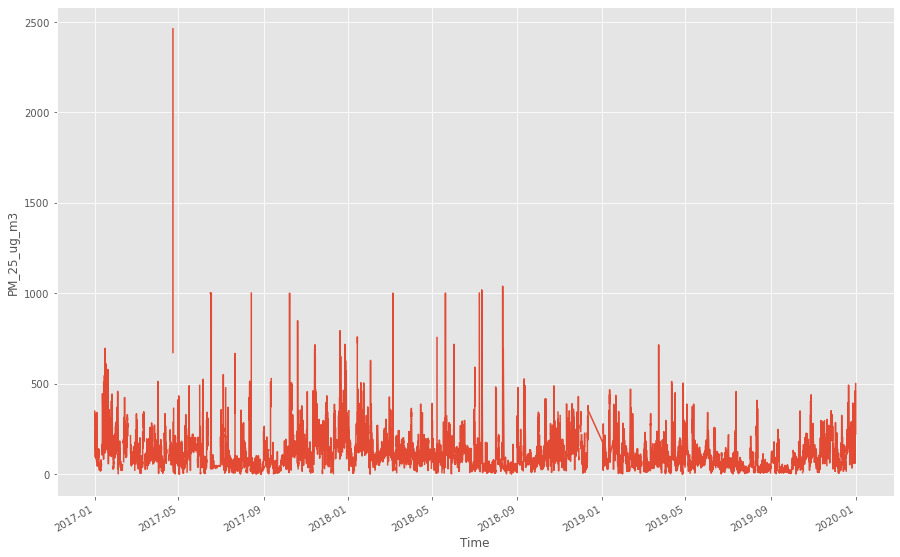

In [62]:
time_series(df1,'PM_25_ug_m3','2017-01-01 00:00:00',)

As seen, most values are within 500 ug/m3 with a few close to 1000 ug/m3. The 2400 value at 2017-04-24 13:00:00 can be changed to a missing value

In [63]:
#Replacing high values (>1100 ug/m3) for PM_25 (2461 ug/m3) at 2017-04-24 13:00:00 with NaN
df1 = df1.copy()
print(df1.loc['2017-04-23 13:00:00','PM_25_ug_m3'])
df1.loc[(df1['PM_25_ug_m3']>1100),'PM_25_ug_m3'] = np.NaN
print(df1.loc['2017-04-23 13:00:00','PM_25_ug_m3'])

From (Time)
2017-04-23 13:00:00    2461.8
Name: PM_25_ug_m3, dtype: float64
From (Time)
2017-04-23 13:00:00   NaN
Name: PM_25_ug_m3, dtype: float64


In [64]:
df1.describe()

PM_25_ug_m3     SO2_ug_m3      O3_ug_m3      CO_mg_m3       NOX_ppb  \
count  22771.000000  22580.000000  22709.000000  22796.000000  22555.000000   
mean     113.994796      8.232955     34.812659      1.259228     38.024548   
std       95.411087     31.501538     32.273082      1.042414     40.843307   
min        0.010000      0.010000      1.020000      0.010000      1.060000   
25%       47.965000      3.540000     12.250000      0.650000     19.310000   
50%       90.950000      5.570000     24.060000      1.010000     25.950000   
75%      151.195000      9.000000     46.060000      1.530000     40.690000   
max     1038.500000    999.990000    306.980000     10.000000    999.990000   

          NO2_ug_m3      NO_ug_m3  Wind_spd_m_s  Wind_dir_deg  Solar_R_W_m2  \
count  22552.000000  22498.000000  18726.000000  22758.000000  22851.000000   
mean      43.456825     18.610433      0.732364    196.091990     65.758424   
std       32.999854     36.762339      0.486056     91.556869    100.174727   
min        0.030000      1.010000      0.110000      0.150000      0.010000   
25%       22.550000      7.550000      0.390000    108.000000      2.300000   
50%       33.030000     10.000000      0.650000    215.330000     23.470000   
75%       53.682500     13.830000      0.980000    264.860000     86.765000   
max      745.550000    519.820000      9.890000    359.400000   1032.070000   

         Bar_P_mmHg           T_m           D_m  RH_NOAA_augroch  
count  22958.000000  24000.000000  24000.000000     23997.000000  
mean     753.434985     25.918305     18.172730        67.590347  
std       11.580506      8.063605      7.123012        23.185439  
min      249.470000      1.620000     -1.310000         8.009113  
25%      748.200000     20.247500     12.010000        49.490689  
50%      754.140000     27.460000     18.010000        70.658840  
75%      759.470000     31.510000     25.010000        88.687983  
max      771.580000     48.020000     34.015000       115.849321

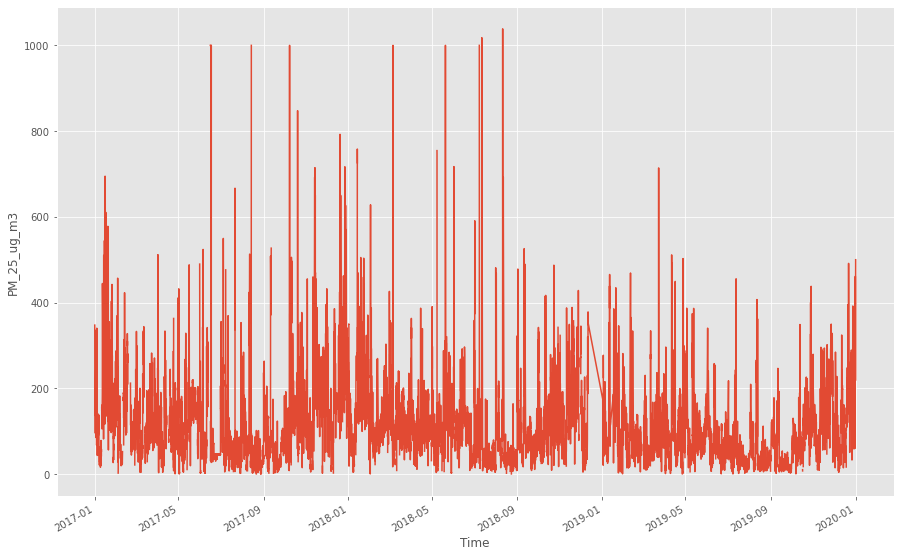

In [65]:
time_series(df1,'PM_25_ug_m3','2017-01-01 00:00:00',)

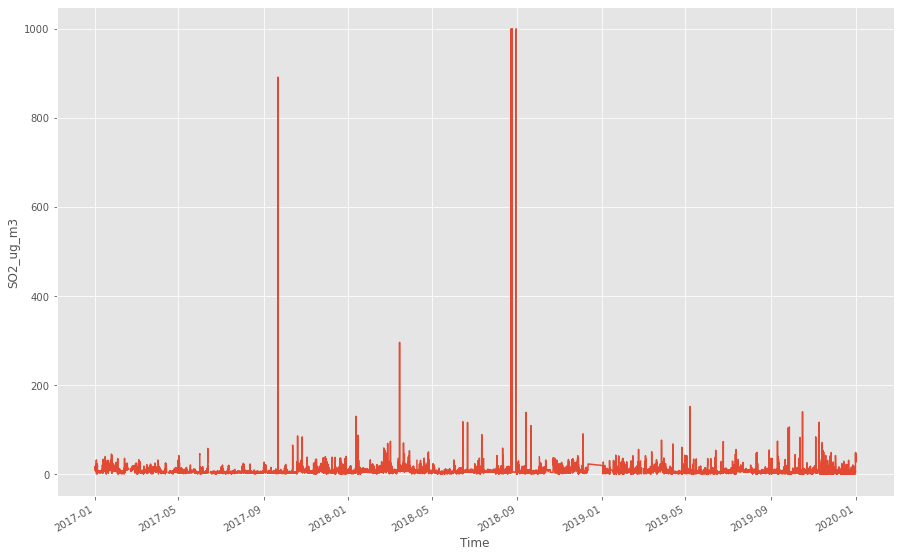

In [66]:
time_series(df1,'SO2_ug_m3','2017-01-01 00:00:00',)

SO2 has most data below 400 ug/m3 with a few outliers. These can again be replaced with a null value

In [67]:
df1.loc[df1['SO2_ug_m3']>800]['SO2_ug_m3']

From (Time)
2017-09-21 15:00:00    828.95
2017-09-21 21:00:00    859.59
2017-09-21 22:00:00    891.55
2018-08-23 02:00:00    999.99
2018-08-23 03:00:00    999.99
2018-08-23 04:00:00    999.99
2018-08-23 05:00:00    999.99
2018-08-23 06:00:00    999.99
2018-08-23 07:00:00    999.99
2018-08-23 08:00:00    999.99
2018-08-23 09:00:00    999.99
2018-08-23 10:00:00    999.99
2018-08-23 11:00:00    999.99
2018-08-23 20:00:00    999.99
2018-08-24 02:00:00    999.99
2018-08-24 03:00:00    999.99
2018-08-24 10:00:00    999.99
2018-08-24 11:00:00    999.99
2018-08-30 12:00:00    999.99
Name: SO2_ug_m3, dtype: float64

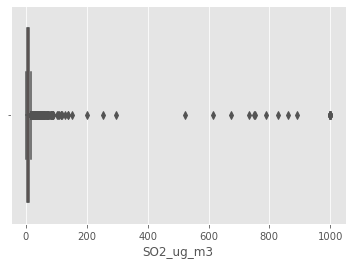

In [68]:
sns.boxplot(df1['SO2_ug_m3'])

In [69]:
#Replacing SO2 ug/m3 outliers (>400 ug/m3) with NaN
df1 = df1.copy()
df1.loc[(df1['SO2_ug_m3']>400),'SO2_ug_m3'] = np.NaN

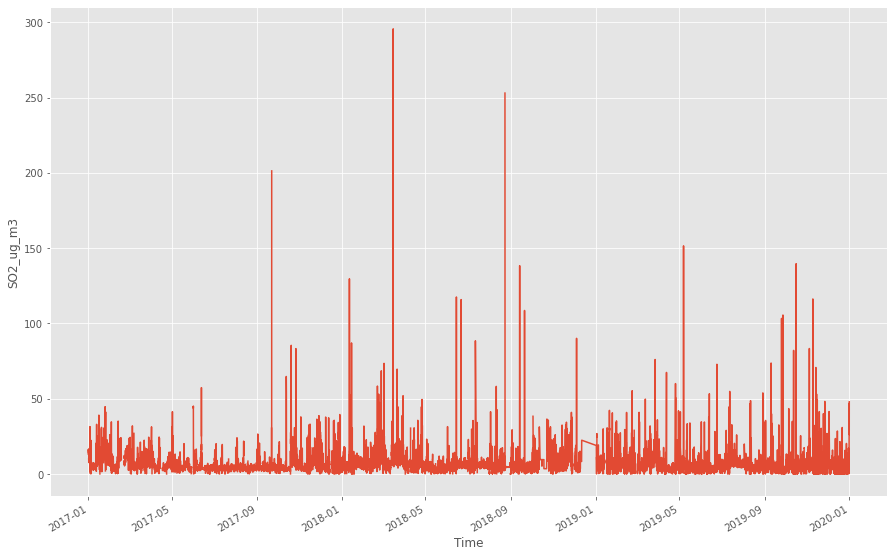

In [70]:
time_series(df1,'SO2_ug_m3','2017-01-01 00:00:00',)

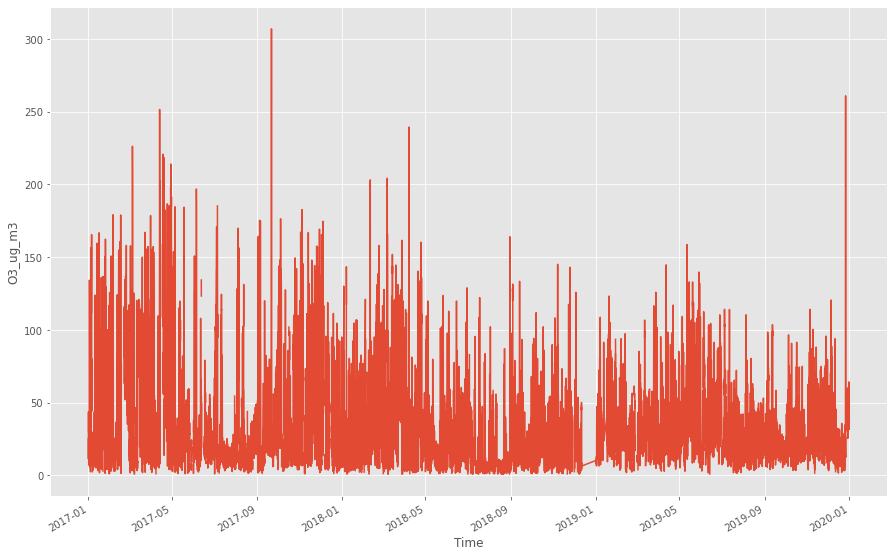

In [71]:
time_series(df1,'O3_ug_m3','2017-01-01 00:00:00',)

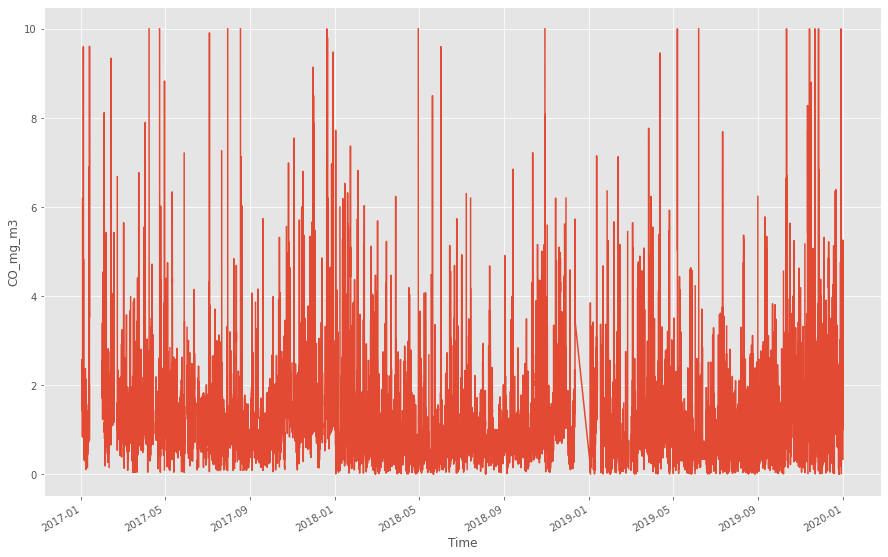

In [72]:
time_series(df1,'CO_mg_m3','2017-01-31 00:00:00',)

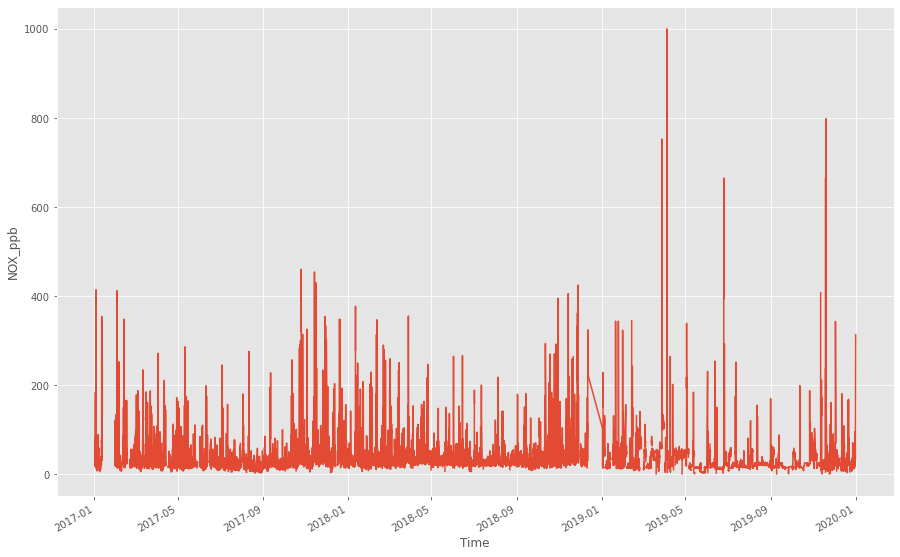

In [73]:
time_series(df1,'NOX_ppb','2017-01-31 00:00:00',)

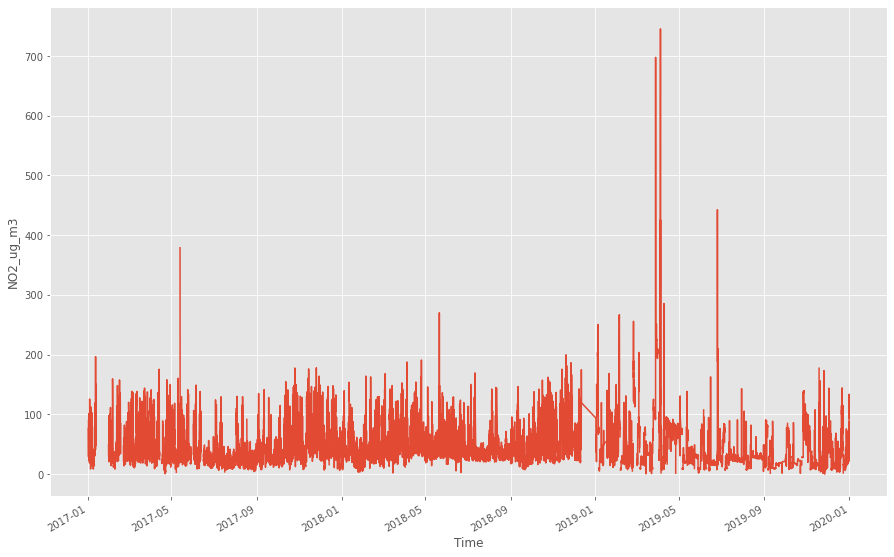

In [74]:
time_series(df1,'NO2_ug_m3','2017-01-31 00:00:00',)

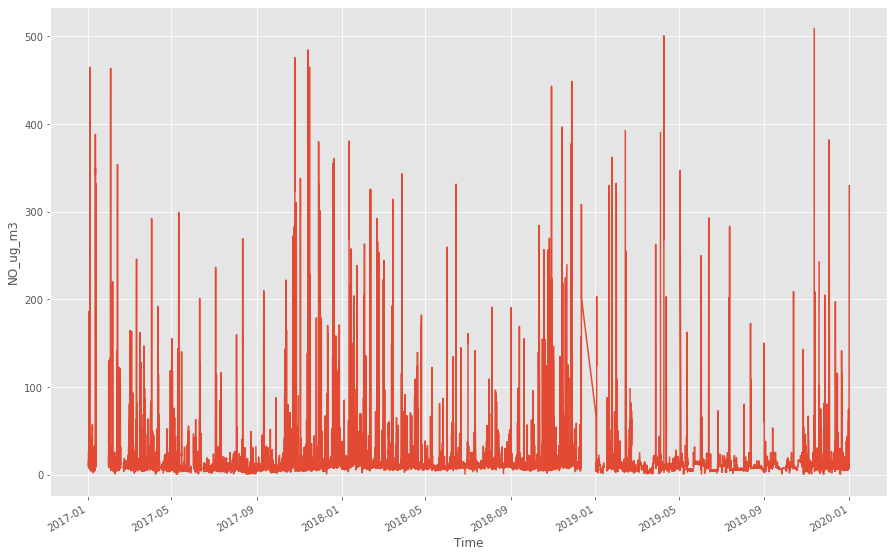

In [75]:
time_series(df1,'NO_ug_m3','2017-01-31 00:00:00',)

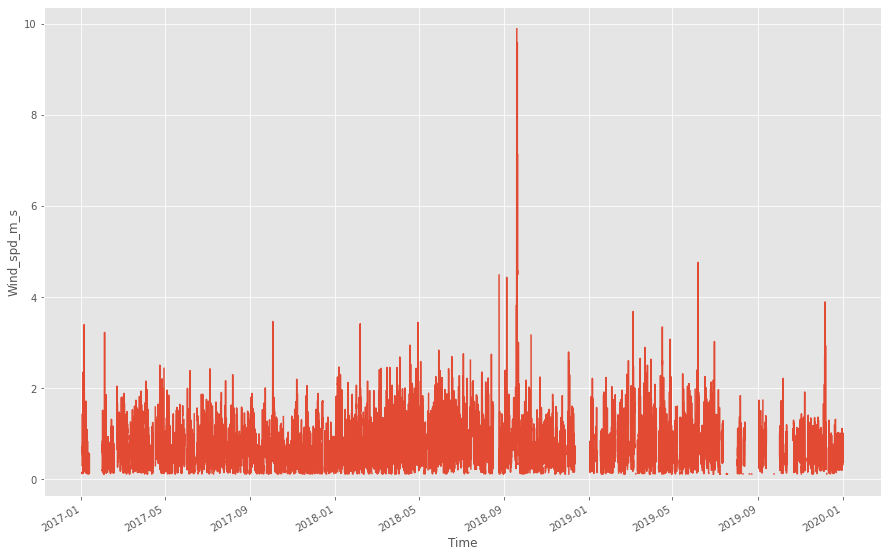

In [76]:
time_series(df1,'Wind_spd_m_s','2017-01-31 00:00:00',)

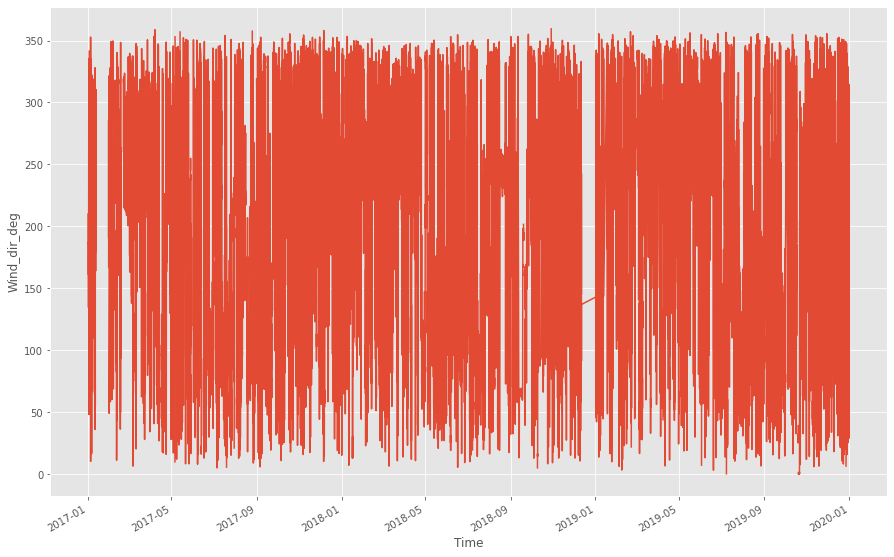

In [77]:
time_series(df1,'Wind_dir_deg','2017-01-31 00:00:00',)

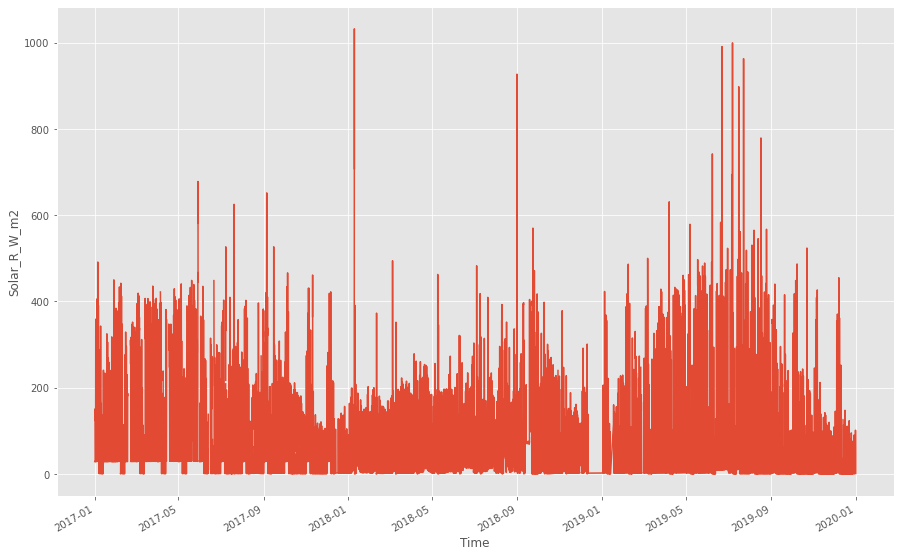

In [78]:
time_series(df1,'Solar_R_W_m2','2017-01-01 00:00:00')

Apart from PM and SO2, none of the other outliers were changed. Next we can plot histograms for all the variables.

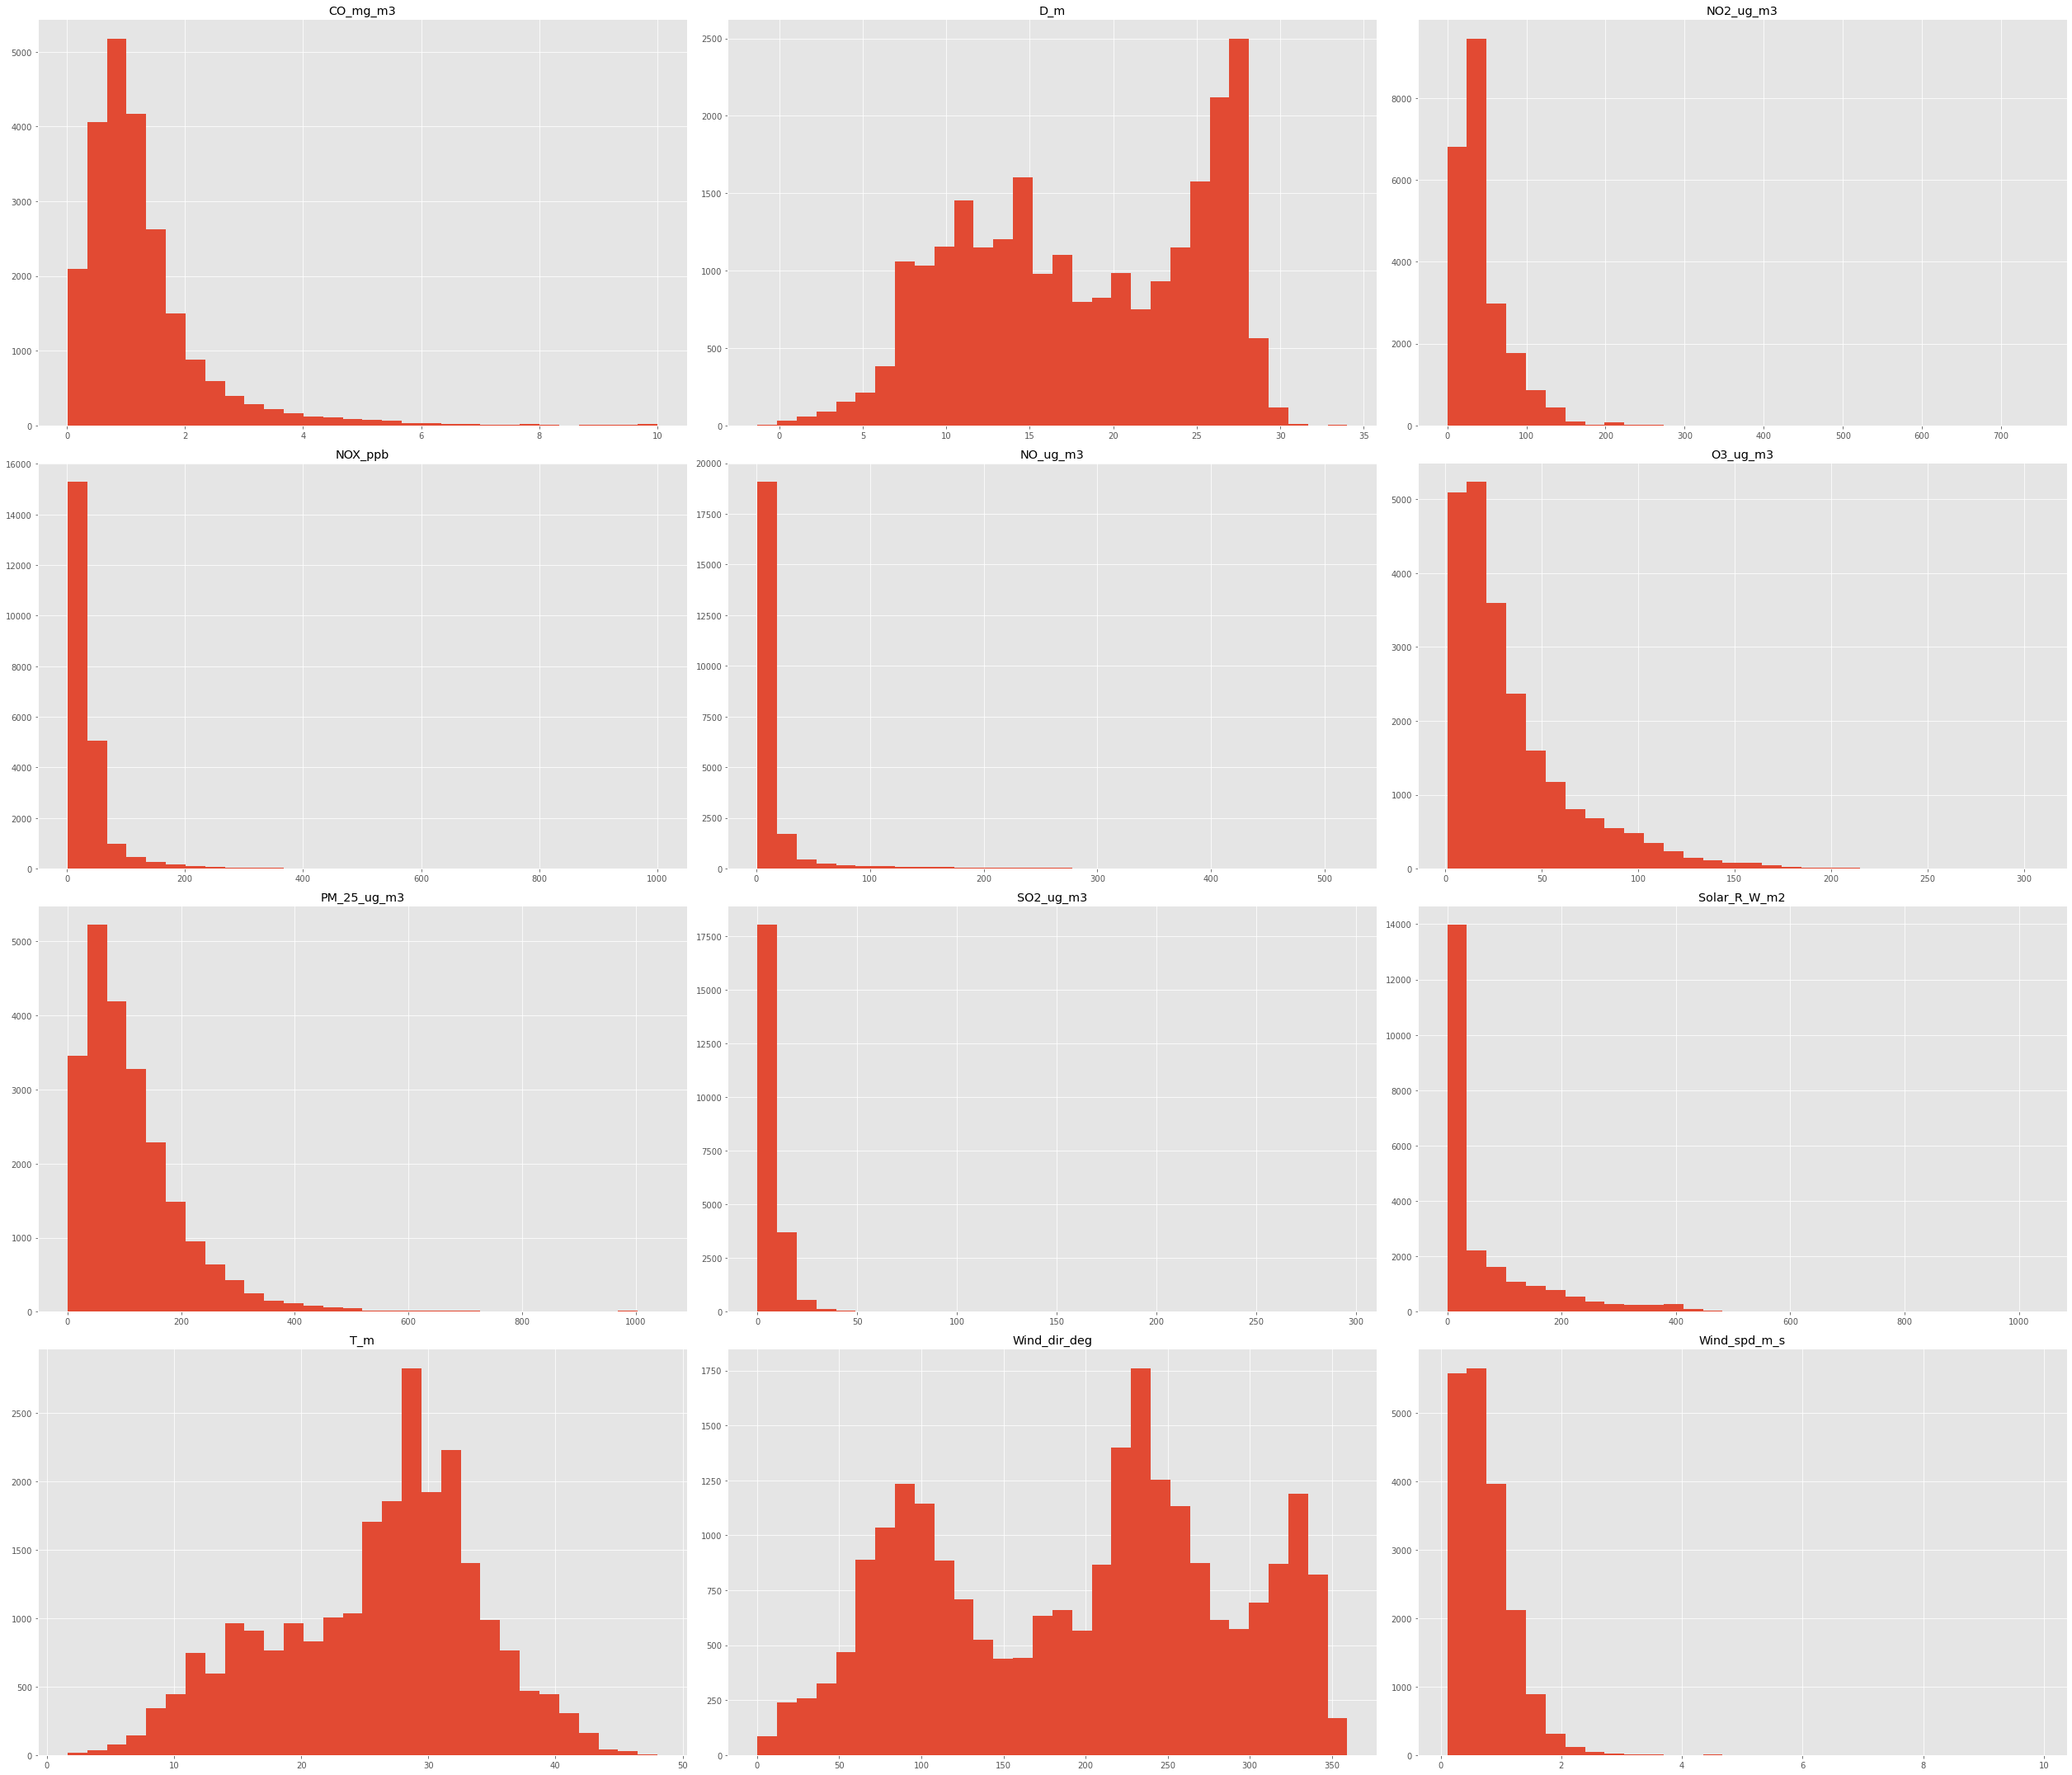

In [79]:
clmns = ['PM_25_ug_m3', 'SO2_ug_m3', 'O3_ug_m3', 'CO_mg_m3','NOX_ppb', 'NO2_ug_m3', 'NO_ug_m3','Wind_spd_m_s', 
     'Wind_dir_deg', 'Solar_R_W_m2', 'T_m','D_m']
df1[clmns].hist(figsize=[35,30],bins=30);
plt.tight_layout()

Most parameters (CO, NO2, NOX, NO, O3, PM25, SO2, Wind Speed and Solar Radiation) show a right skewed distribution.
<br> These parameters can be log transformed to make the distribution more normal and also reduce the influence of outliers for some models. This transformation may help more when trying to use linear regression and not so much while applying bagging and boosting techniques

In [80]:
#Log Transform features to reduce skewed variables seen in the histograms above
clmns_log = [c + '_log' for c in clmns]
for a,b in zip(clmns_log,clmns):
    df1[a] = (df1[b]+1).transform(np.log)
clmns

['PM_25_ug_m3',
 'SO2_ug_m3',
 'O3_ug_m3',
 'CO_mg_m3',
 'NOX_ppb',
 'NO2_ug_m3',
 'NO_ug_m3',
 'Wind_spd_m_s',
 'Wind_dir_deg',
 'Solar_R_W_m2',
 'T_m',
 'D_m']

Plotting non-log vs log distributions to check shape

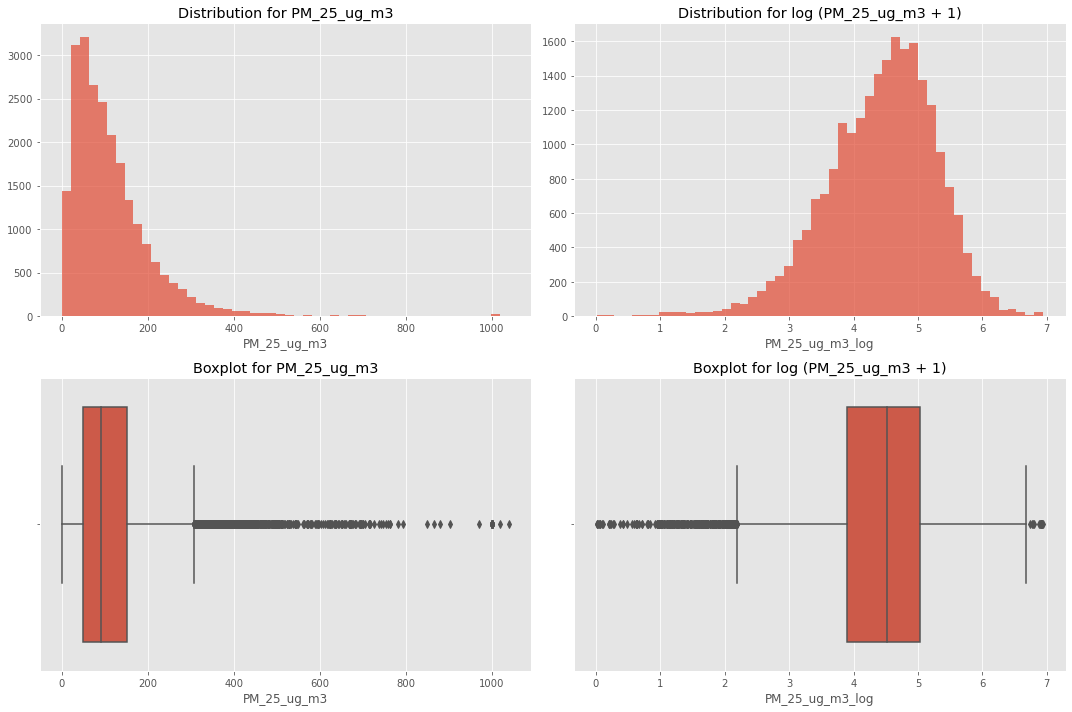

In [81]:
Dist(df1,'PM_25_ug_m3','PM_25_ug_m3_log')

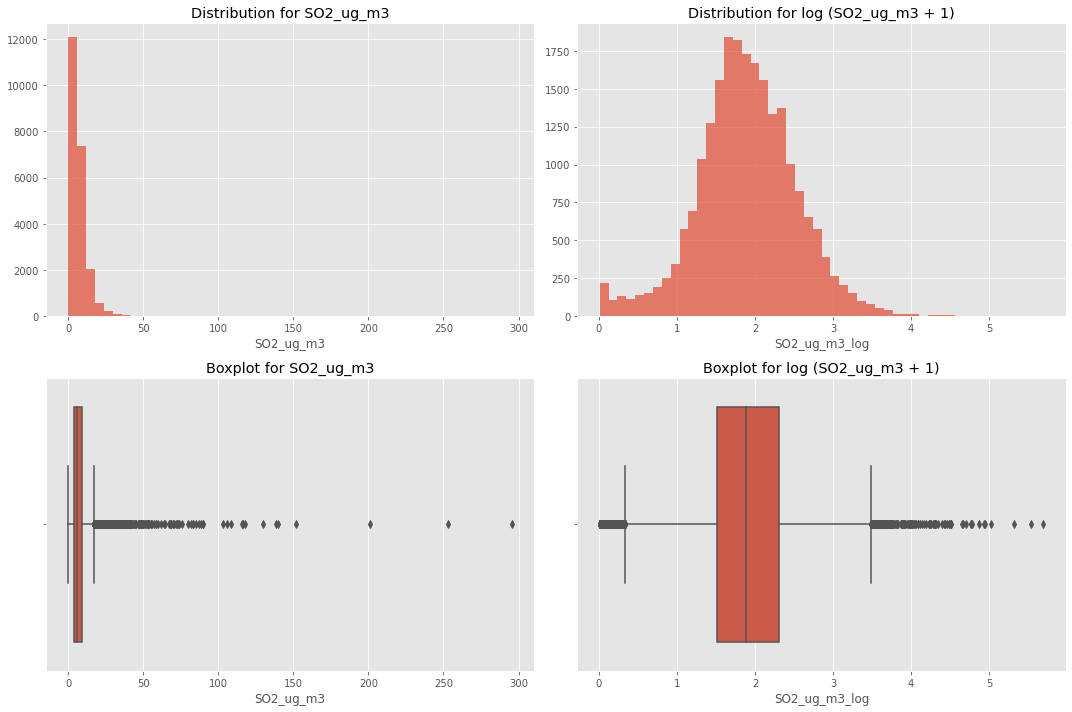

In [82]:
Dist(df1,'SO2_ug_m3','SO2_ug_m3_log')

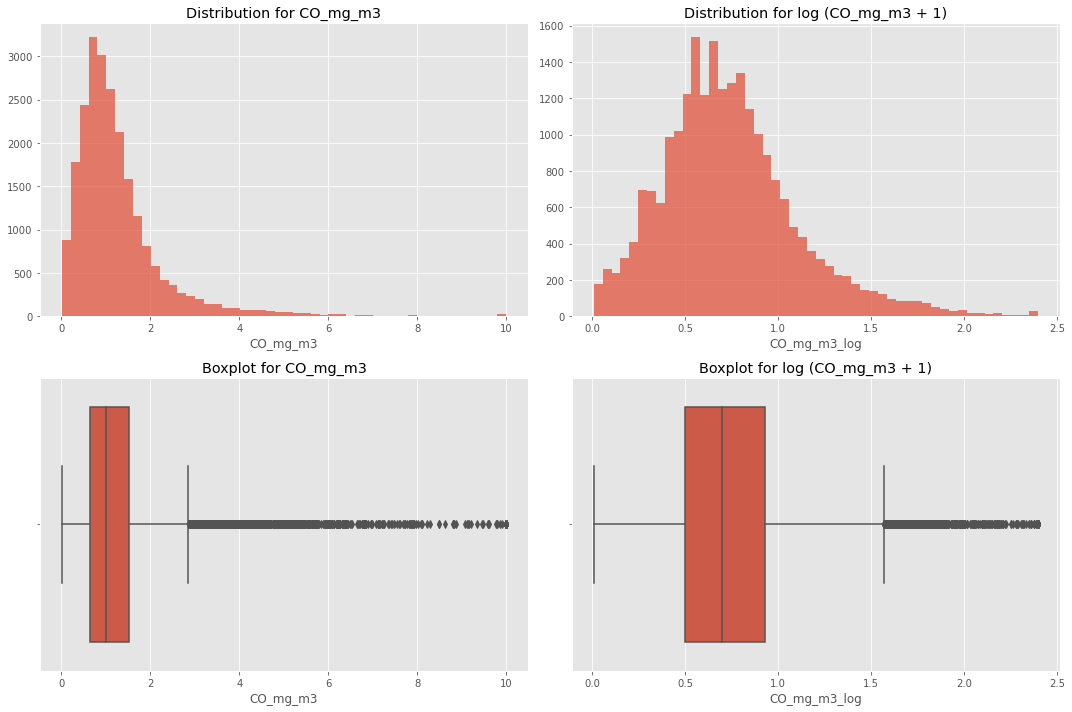

In [83]:
Dist(df1,'CO_mg_m3','CO_mg_m3_log')

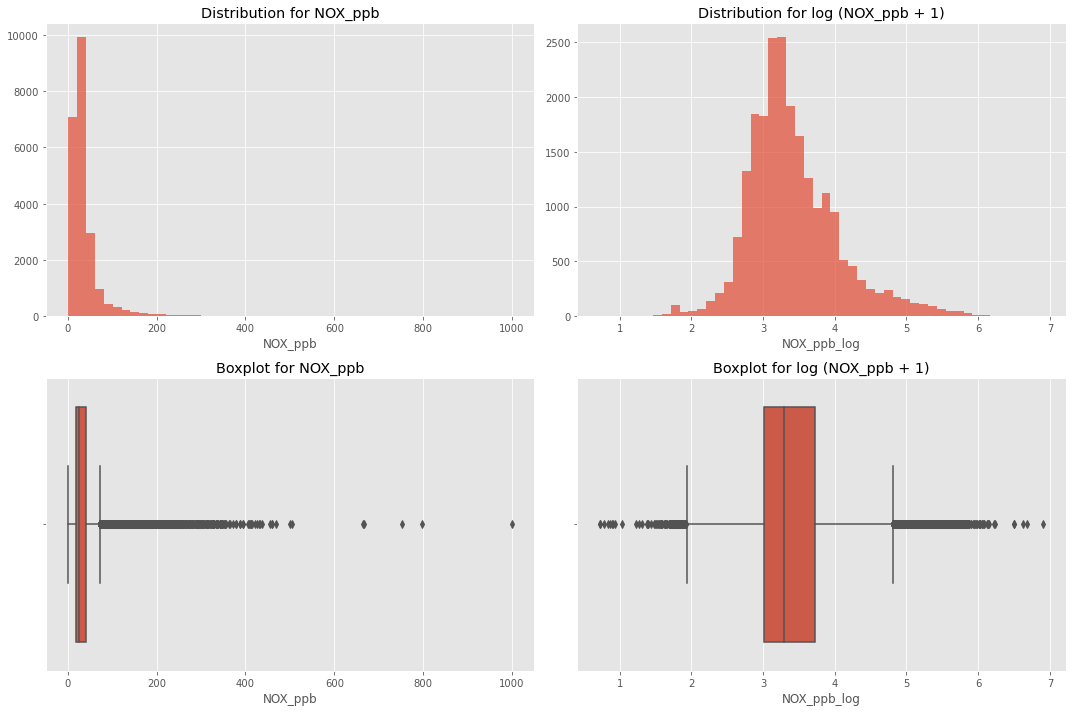

In [84]:
Dist(df1,'NOX_ppb','NOX_ppb_log')

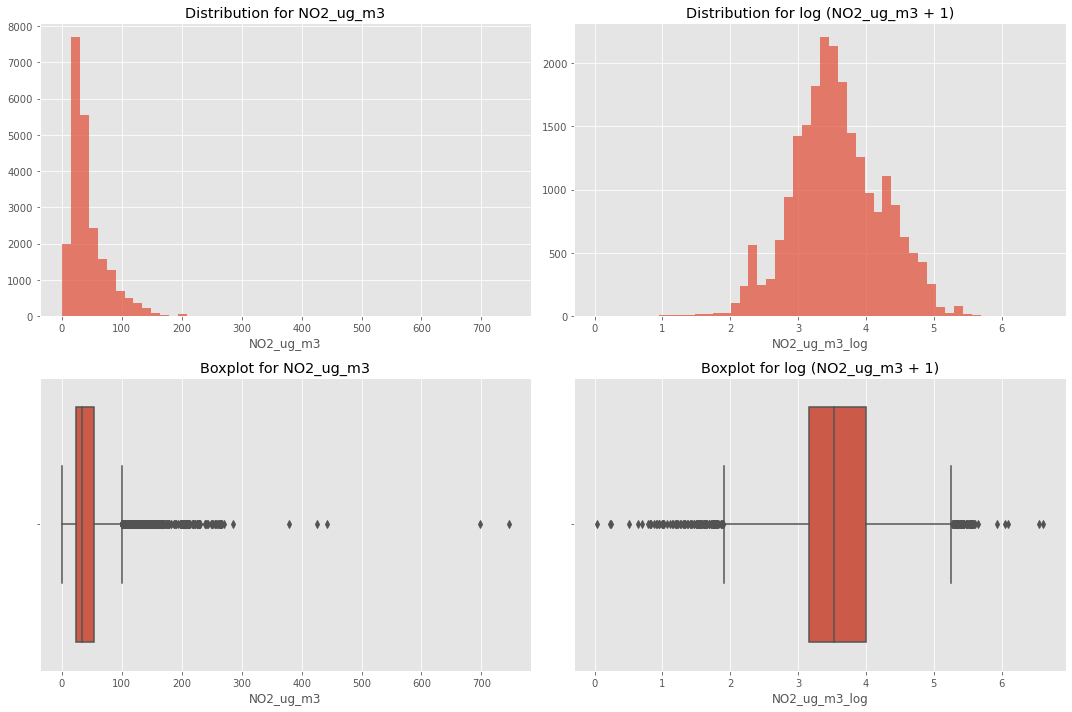

In [85]:
Dist(df1,'NO2_ug_m3','NO2_ug_m3_log')

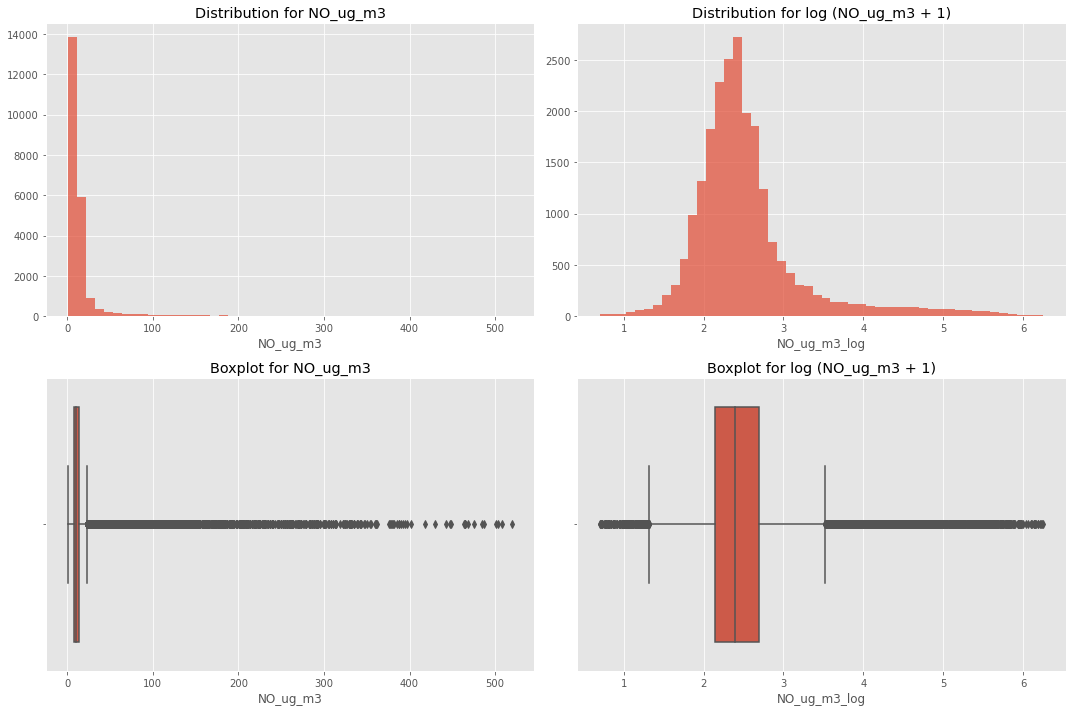

In [86]:
Dist(df1,'NO_ug_m3','NO_ug_m3_log')

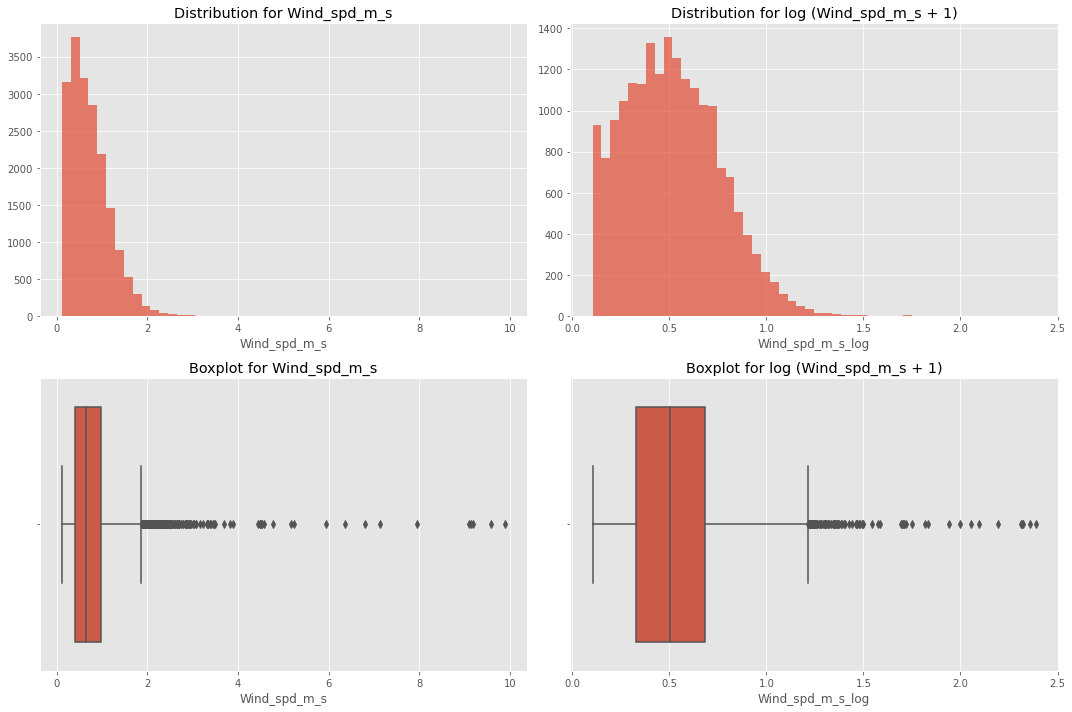

In [87]:
Dist(df1,'Wind_spd_m_s','Wind_spd_m_s_log')

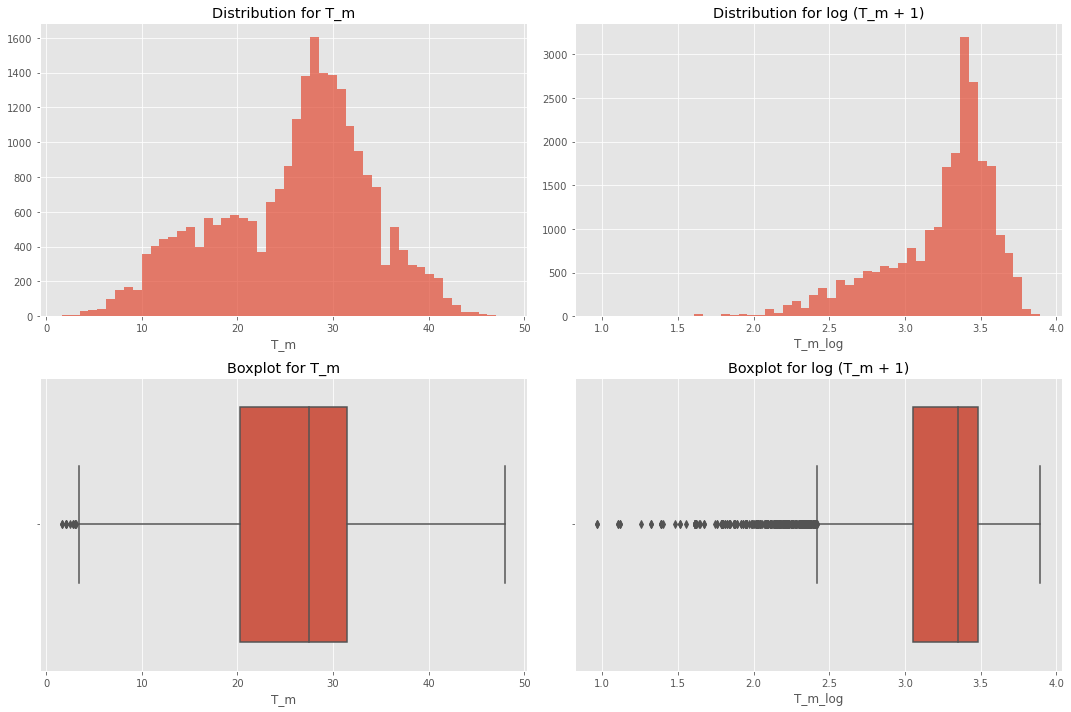

In [88]:
Dist(df1,'T_m','T_m_log')

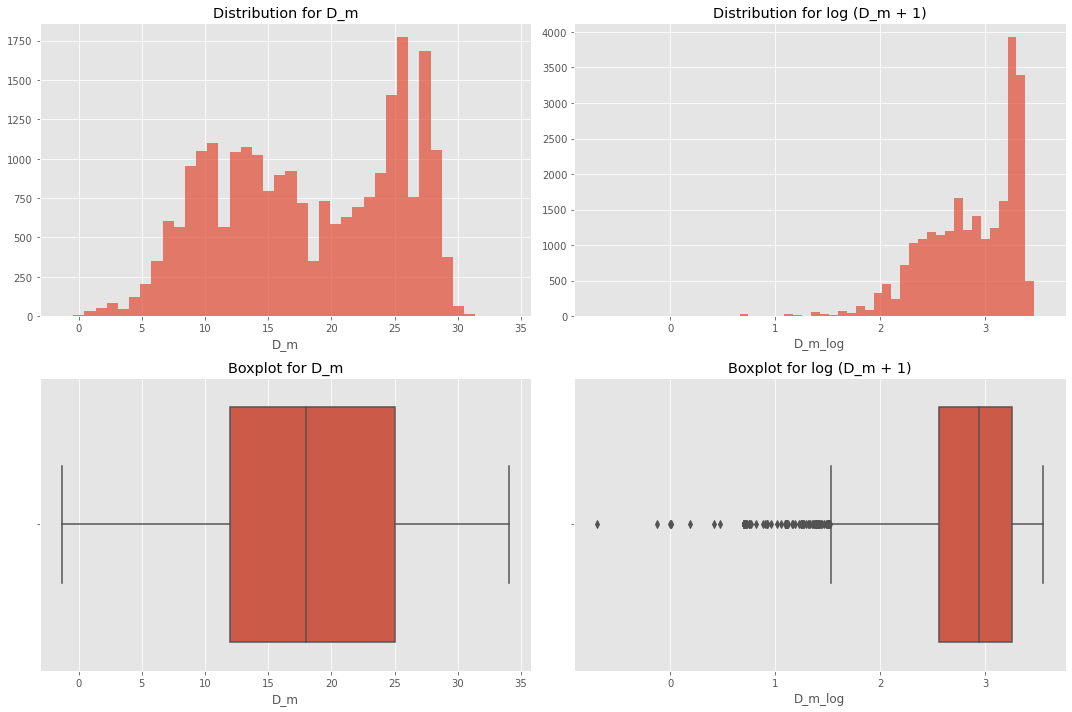

In [89]:
Dist(df1,'D_m','D_m_log')

Except temperatures and Wind speed, all the log transformed variables are seen to be more symmetrically distributed.

In [90]:
df1.isna().sum()

PM_25_ug_m3         1823
SO2_ug_m3           2040
O3_ug_m3            1885
CO_mg_m3            1798
NOX_ppb             2039
NO2_ug_m3           2042
NO_ug_m3            2096
Wind_spd_m_s        5868
Wind_dir_deg        1836
Solar_R_W_m2        1743
Bar_P_mmHg          1636
T_m                  594
D_m                  594
RH_NOAA_augroch      597
PM_25_ug_m3_log     1823
SO2_ug_m3_log       2040
O3_ug_m3_log        1885
CO_mg_m3_log        1798
NOX_ppb_log         2039
NO2_ug_m3_log       2042
NO_ug_m3_log        2096
Wind_spd_m_s_log    5868
Wind_dir_deg_log    1836
Solar_R_W_m2_log    1743
T_m_log              594
D_m_log              595
dtype: int64

In [91]:
df1.resample('1H').mean().isna().sum()

PM_25_ug_m3         3510
SO2_ug_m3           3727
O3_ug_m3            3572
CO_mg_m3            3485
NOX_ppb             3726
NO2_ug_m3           3729
NO_ug_m3            3783
Wind_spd_m_s        7555
Wind_dir_deg        3523
Solar_R_W_m2        3430
Bar_P_mmHg          3323
T_m                 2281
D_m                 2281
RH_NOAA_augroch     2284
PM_25_ug_m3_log     3510
SO2_ug_m3_log       3727
O3_ug_m3_log        3572
CO_mg_m3_log        3485
NOX_ppb_log         3726
NO2_ug_m3_log       3729
NO_ug_m3_log        3783
Wind_spd_m_s_log    7555
Wind_dir_deg_log    3523
Solar_R_W_m2_log    3430
T_m_log             2281
D_m_log             2282
dtype: int64

As can be seen above, resampling values by '1 hour' introduces many null values indicating missing patches in 
the time series. This can be a problem when adding lagging features as these features will not strictly be previous
hour features for some of these data points.
We can create a separate hourly resampled dataset and compare modeling results between both types of datasets

In [92]:
#Create separate hourly resampled dataset
df1_1H = df1.resample('1H').mean()

In [93]:
df1.equals(df1_1H)

False

To plot feature against time (monthly, hourly values), time features need to be created as follows:

In [94]:
#Date Time Features
def time_features(df):
    df['Year'] = df['From (Time)'].dt.year
    df['Month_No'] = df['From (Time)'].dt.month
    df['Day_of_Week'] = df['From (Time)'].dt.dayofweek
    df['Hour'] = df['From (Time)'].dt.hour
    df['Day'] = df['From (Time)'].dt.day_name()
    df['Month'] = df['From (Time)'].dt.month_name()
    df['Y/M'] = (df['From (Time)'].dt.to_period('M')).dt.strftime('(%Y, %m)')
    return df

In [95]:
df1 = time_features(df1.reset_index()).set_index('From (Time)')
df1_1H = time_features(df1_1H.reset_index()).set_index('From (Time)')

In [96]:
df1.equals(df1_1H)

False

In [97]:
df1.head()

PM_25_ug_m3  SO2_ug_m3  O3_ug_m3  CO_mg_m3  NOX_ppb  \
From (Time)                                                                
2017-01-01 00:00:00       347.28      15.93     25.06      1.25    46.35   
2017-01-01 01:00:00       264.13      15.33     24.01      0.98    36.98   
2017-01-01 02:00:00       198.07      15.31     11.37      1.43    25.26   
2017-01-01 03:00:00       153.30      16.27     30.98      1.42    23.16   
2017-01-01 04:00:00       129.17      12.82     43.70      1.58    20.93   

                     NO2_ug_m3  NO_ug_m3  Wind_spd_m_s  Wind_dir_deg  \
From (Time)                                                            
2017-01-01 00:00:00      31.28     36.71          0.38        175.09   
2017-01-01 01:00:00      29.17     26.39          0.43        183.65   
2017-01-01 02:00:00      27.79     12.64          0.37        111.90   
2017-01-01 03:00:00      26.46     10.88          0.35        146.27   
2017-01-01 04:00:00      26.54      8.05          0.32        112.67   

                     Solar_R_W_m2  ...  Solar_R_W_m2_log   T_m_log   D_m_log  \
From (Time)                        ...                                         
2017-01-01 00:00:00         28.76  ...          3.393165       NaN       NaN   
2017-01-01 01:00:00         28.76  ...          3.393165  2.565718  2.485740   
2017-01-01 02:00:00         28.76  ...          3.393165  2.565718  2.565718   
2017-01-01 03:00:00         28.76  ...          3.393165  2.580974  2.573375   
2017-01-01 04:00:00         28.75  ...          3.392829  2.565718  2.565718   

                     Year  Month_No  Day_of_Week  Hour     Day    Month  \
From (Time)                                                               
2017-01-01 00:00:00  2017         1            6     0  Sunday  January   
2017-01-01 01:00:00  2017         1            6     1  Sunday  January   
2017-01-01 02:00:00  2017         1            6     2  Sunday  January   
2017-01-01 03:00:00  2017         1            6     3  Sunday  January   
2017-01-01 04:00:00  2017         1            6     4  Sunday  January   

                            Y/M  
From (Time)                      
2017-01-01 00:00:00  (2017, 01)  
2017-01-01 01:00:00  (2017, 01)  
2017-01-01 02:00:00  (2017, 01)  
2017-01-01 03:00:00  (2017, 01)  
2017-01-01 04:00:00  (2017, 01)  

[5 rows x 33 columns]

In [98]:
df1_1H.head()

PM_25_ug_m3  SO2_ug_m3  O3_ug_m3  CO_mg_m3  NOX_ppb  \
From (Time)                                                                
2017-01-01 00:00:00       347.28      15.93     25.06      1.25    46.35   
2017-01-01 01:00:00       264.13      15.33     24.01      0.98    36.98   
2017-01-01 02:00:00       198.07      15.31     11.37      1.43    25.26   
2017-01-01 03:00:00       153.30      16.27     30.98      1.42    23.16   
2017-01-01 04:00:00       129.17      12.82     43.70      1.58    20.93   

                     NO2_ug_m3  NO_ug_m3  Wind_spd_m_s  Wind_dir_deg  \
From (Time)                                                            
2017-01-01 00:00:00      31.28     36.71          0.38        175.09   
2017-01-01 01:00:00      29.17     26.39          0.43        183.65   
2017-01-01 02:00:00      27.79     12.64          0.37        111.90   
2017-01-01 03:00:00      26.46     10.88          0.35        146.27   
2017-01-01 04:00:00      26.54      8.05          0.32        112.67   

                     Solar_R_W_m2  ...  Solar_R_W_m2_log   T_m_log   D_m_log  \
From (Time)                        ...                                         
2017-01-01 00:00:00         28.76  ...          3.393165       NaN       NaN   
2017-01-01 01:00:00         28.76  ...          3.393165  2.565718  2.485740   
2017-01-01 02:00:00         28.76  ...          3.393165  2.565718  2.565718   
2017-01-01 03:00:00         28.76  ...          3.393165  2.580974  2.573375   
2017-01-01 04:00:00         28.75  ...          3.392829  2.565718  2.565718   

                     Year  Month_No  Day_of_Week  Hour     Day    Month  \
From (Time)                                                               
2017-01-01 00:00:00  2017         1            6     0  Sunday  January   
2017-01-01 01:00:00  2017         1            6     1  Sunday  January   
2017-01-01 02:00:00  2017         1            6     2  Sunday  January   
2017-01-01 03:00:00  2017         1            6     3  Sunday  January   
2017-01-01 04:00:00  2017         1            6     4  Sunday  January   

                            Y/M  
From (Time)                      
2017-01-01 00:00:00  (2017, 01)  
2017-01-01 01:00:00  (2017, 01)  
2017-01-01 02:00:00  (2017, 01)  
2017-01-01 03:00:00  (2017, 01)  
2017-01-01 04:00:00  (2017, 01)  

[5 rows x 33 columns]

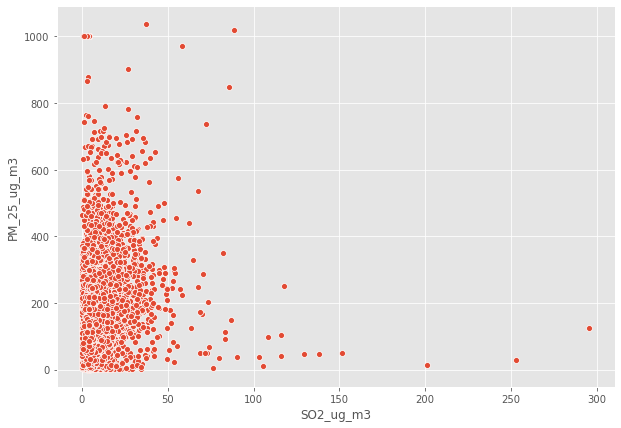

<Figure size 1080x720 with 0 Axes>

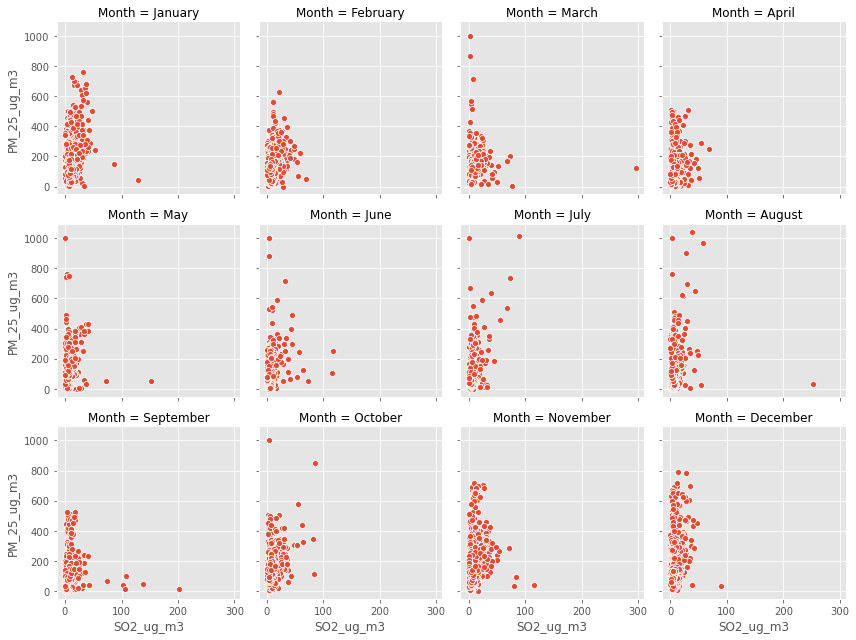

<Figure size 1080x720 with 0 Axes>

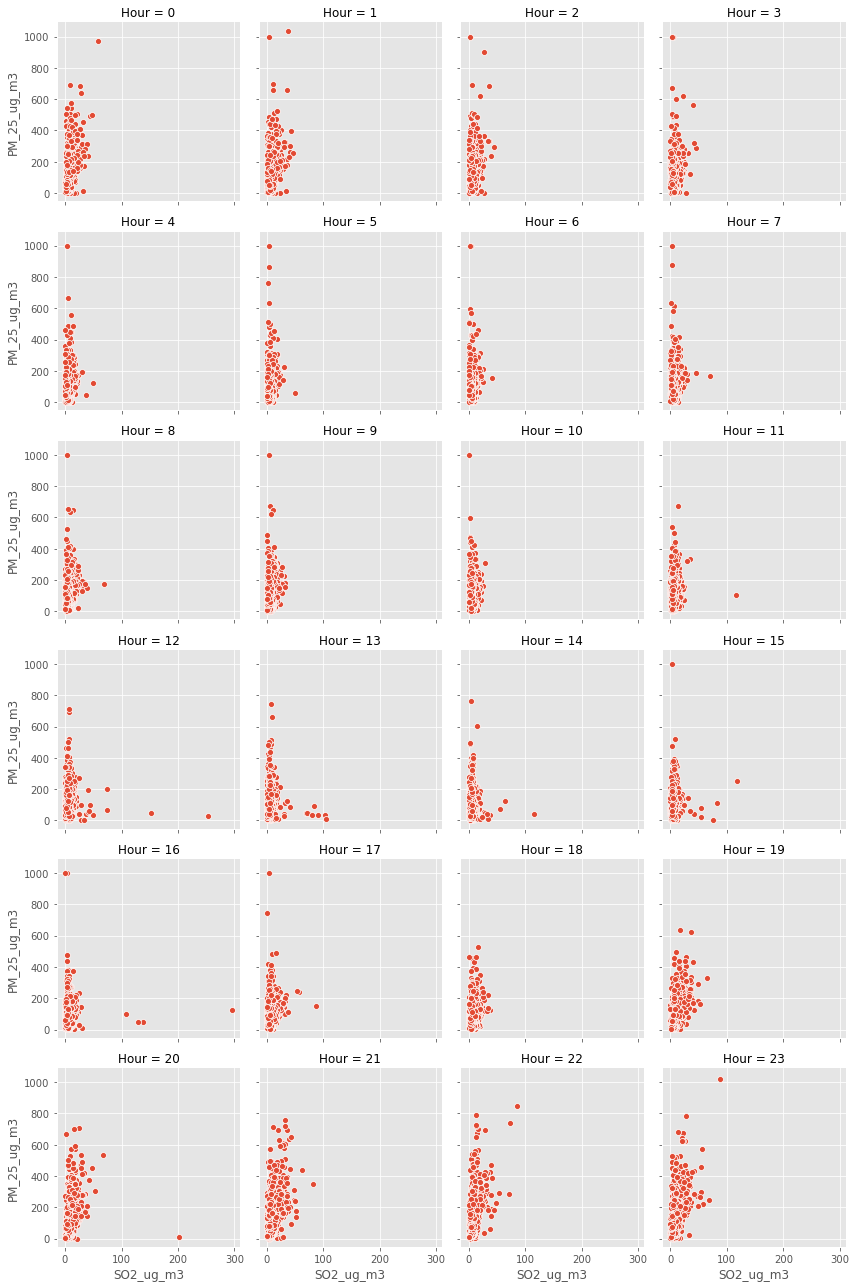

In [99]:
plots_2d(df1,x='SO2_ug_m3')

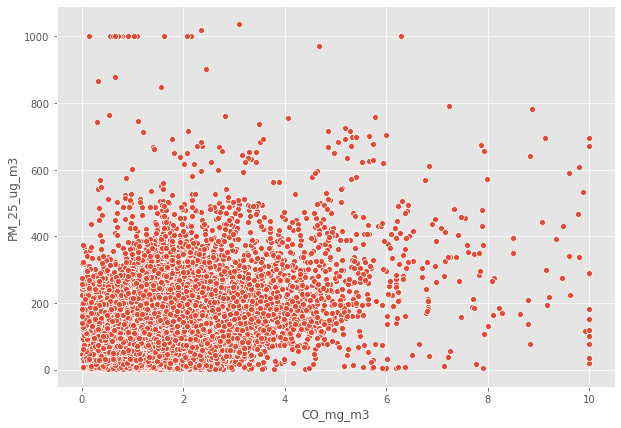

<Figure size 1080x720 with 0 Axes>

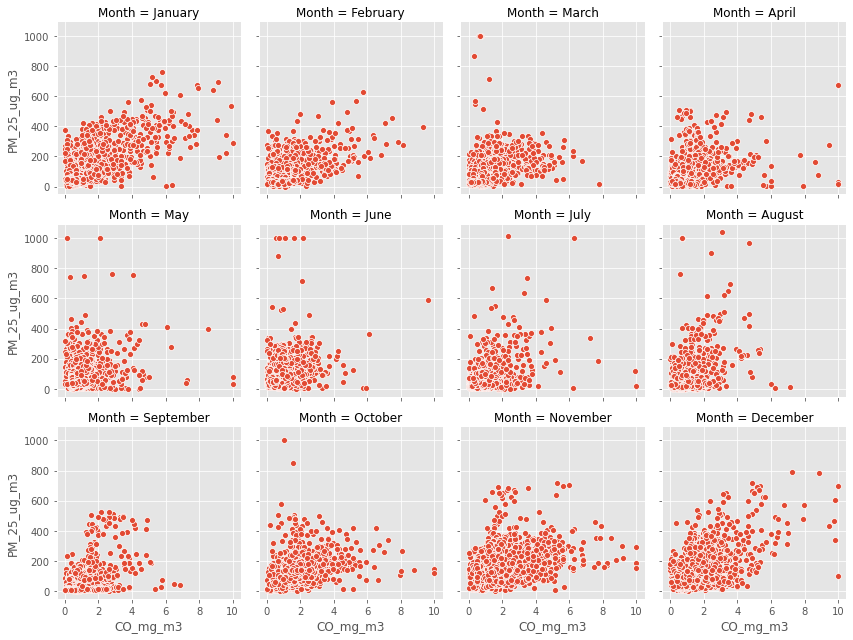

<Figure size 1080x720 with 0 Axes>

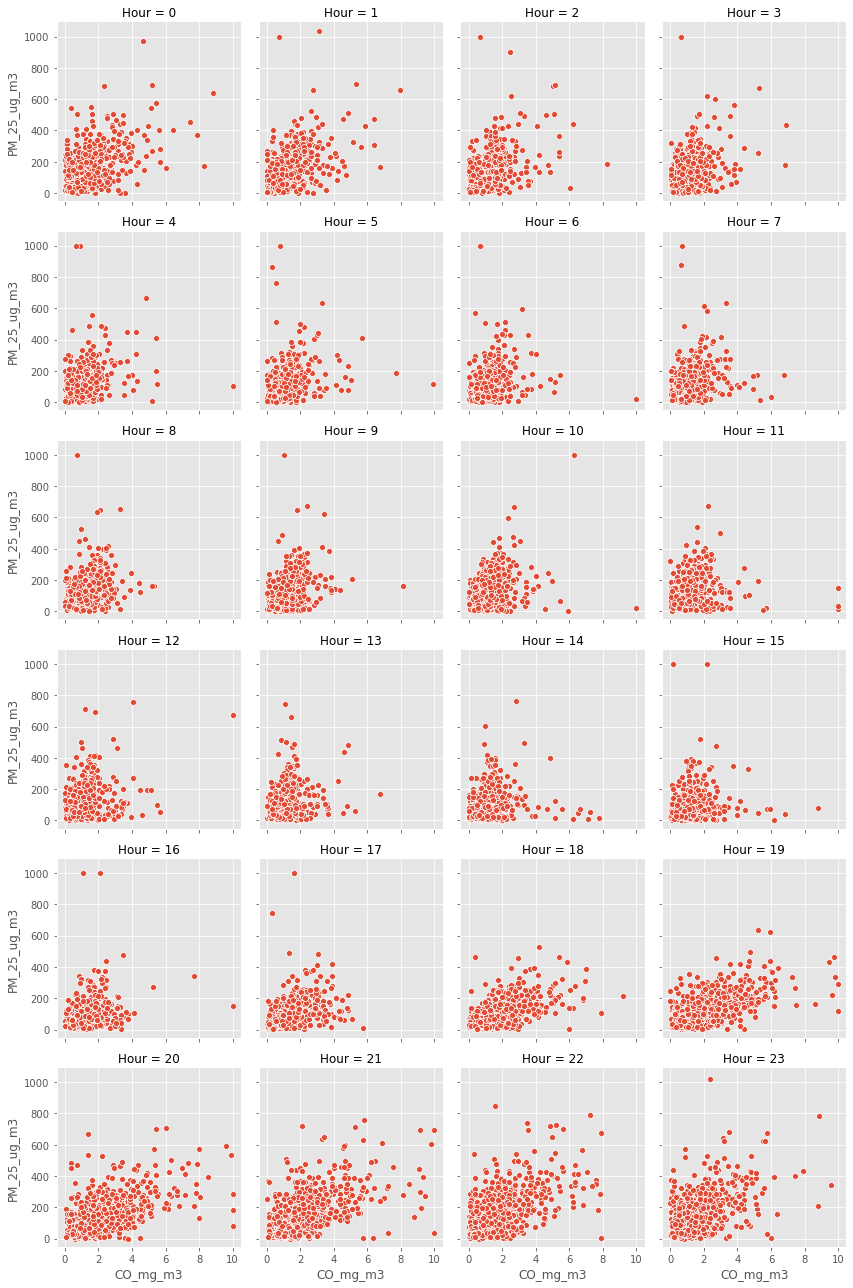

In [100]:
plots_2d(df1,x='CO_mg_m3')

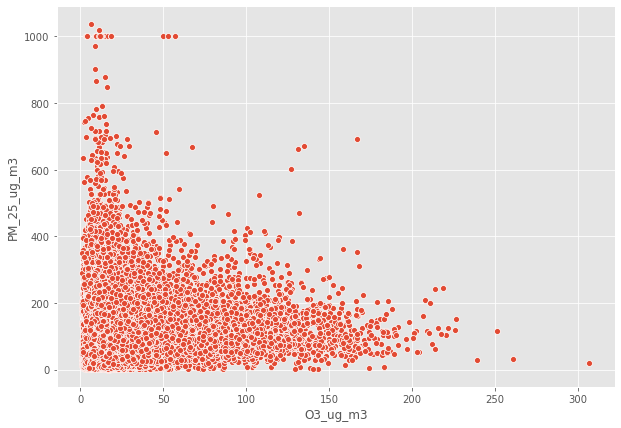

<Figure size 1080x720 with 0 Axes>

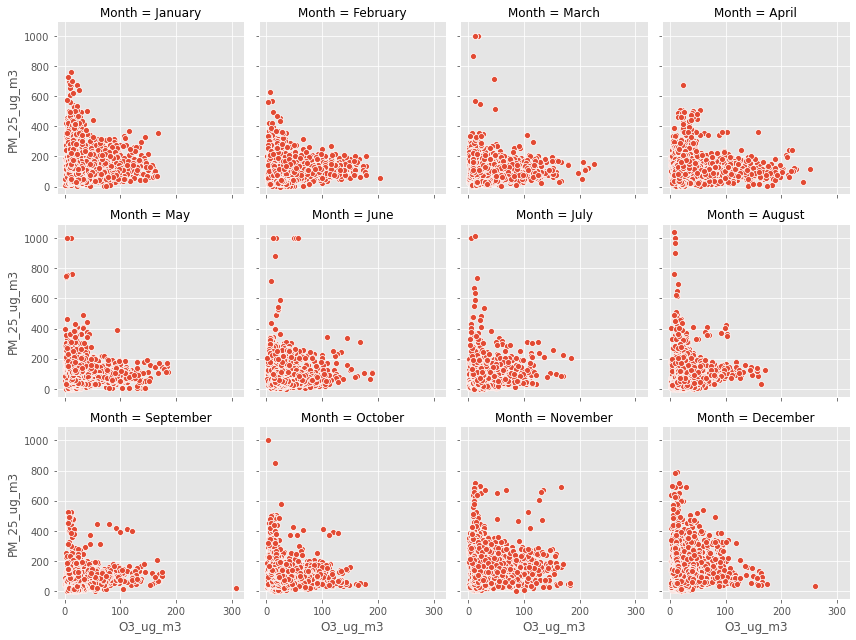

<Figure size 1080x720 with 0 Axes>

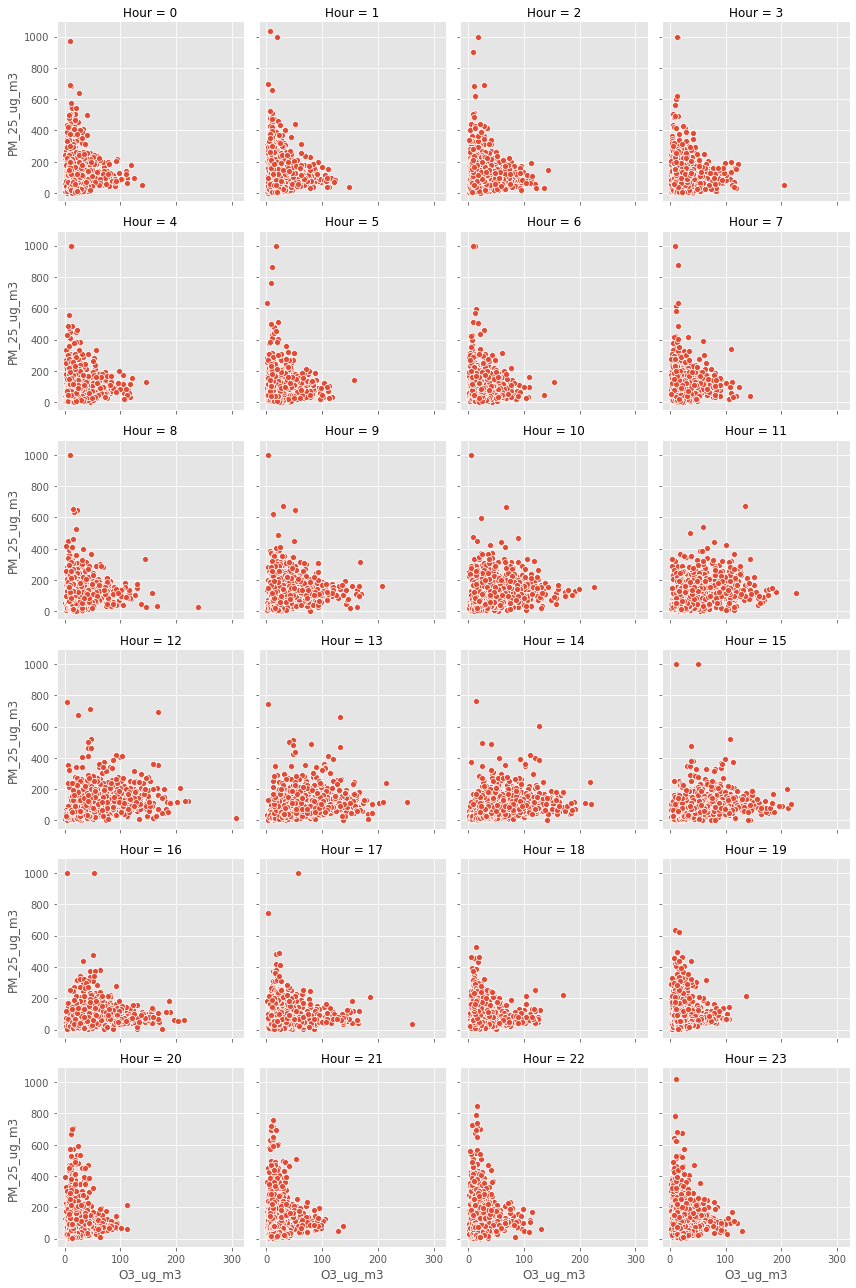

In [101]:
plots_2d(df1,x='O3_ug_m3')

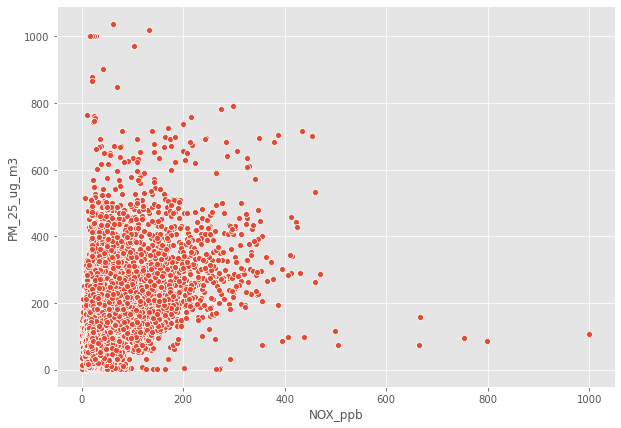

<Figure size 1080x720 with 0 Axes>

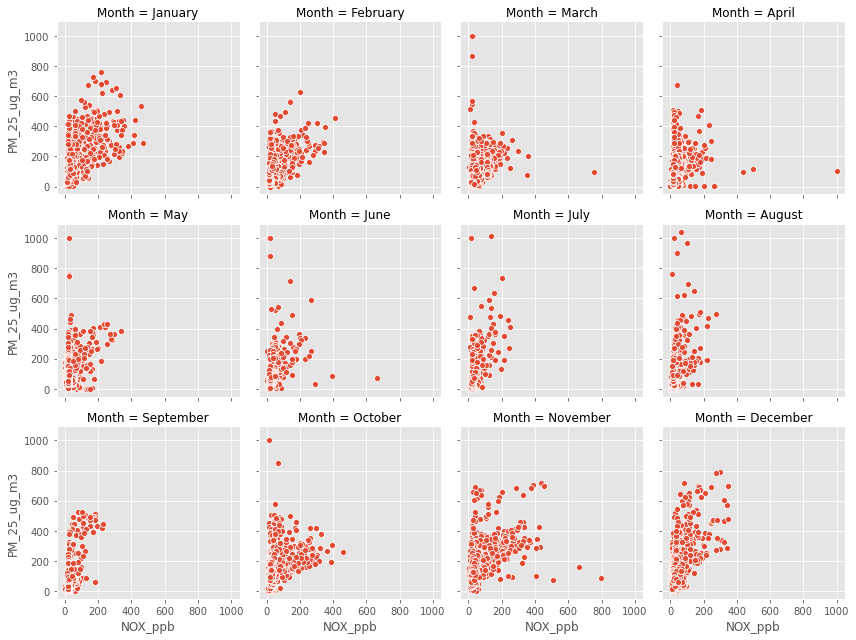

<Figure size 1080x720 with 0 Axes>

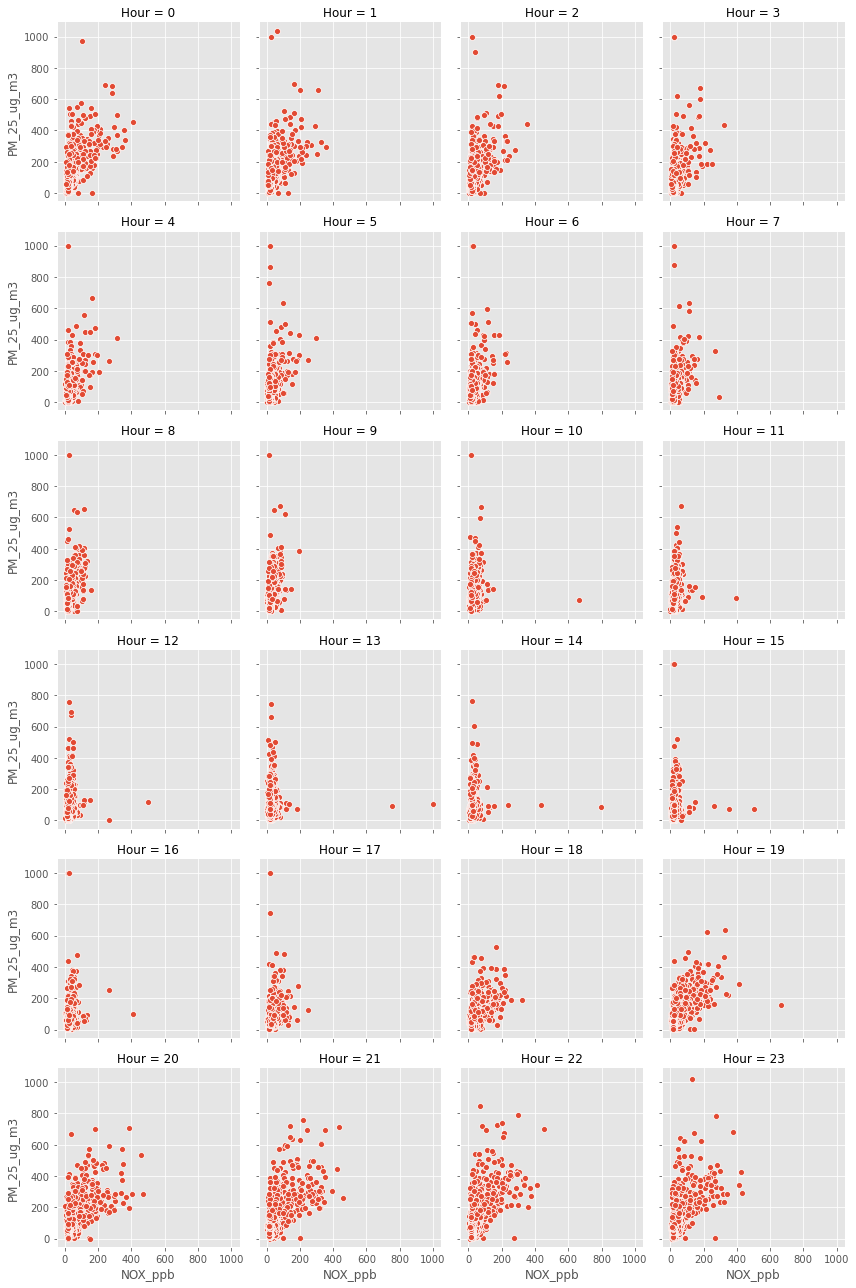

In [102]:
plots_2d(df1,x='NOX_ppb')

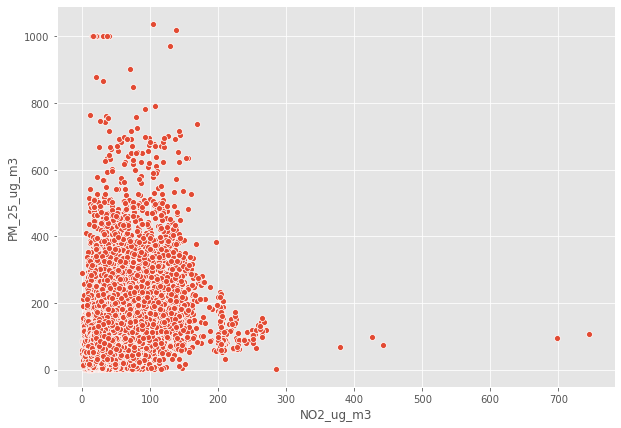

<Figure size 1080x720 with 0 Axes>

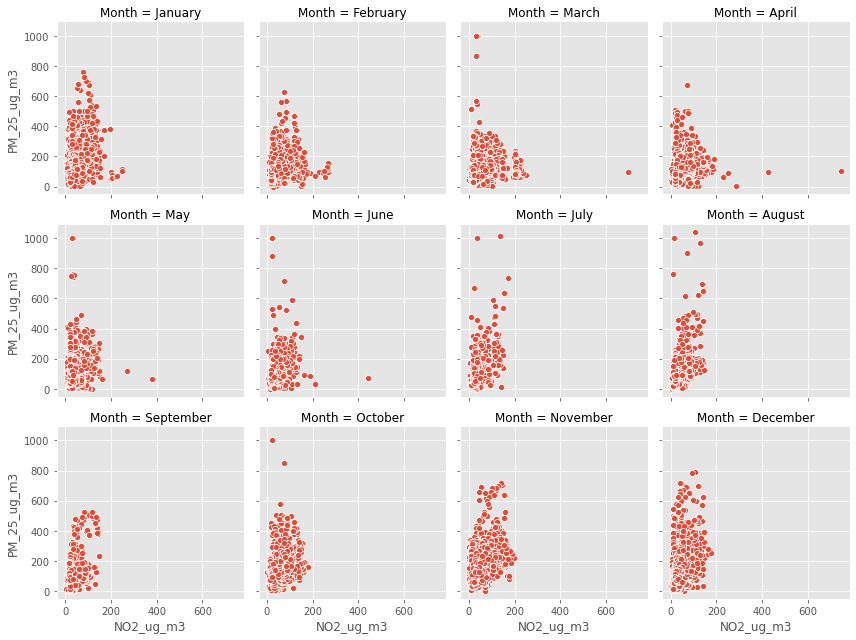

<Figure size 1080x720 with 0 Axes>

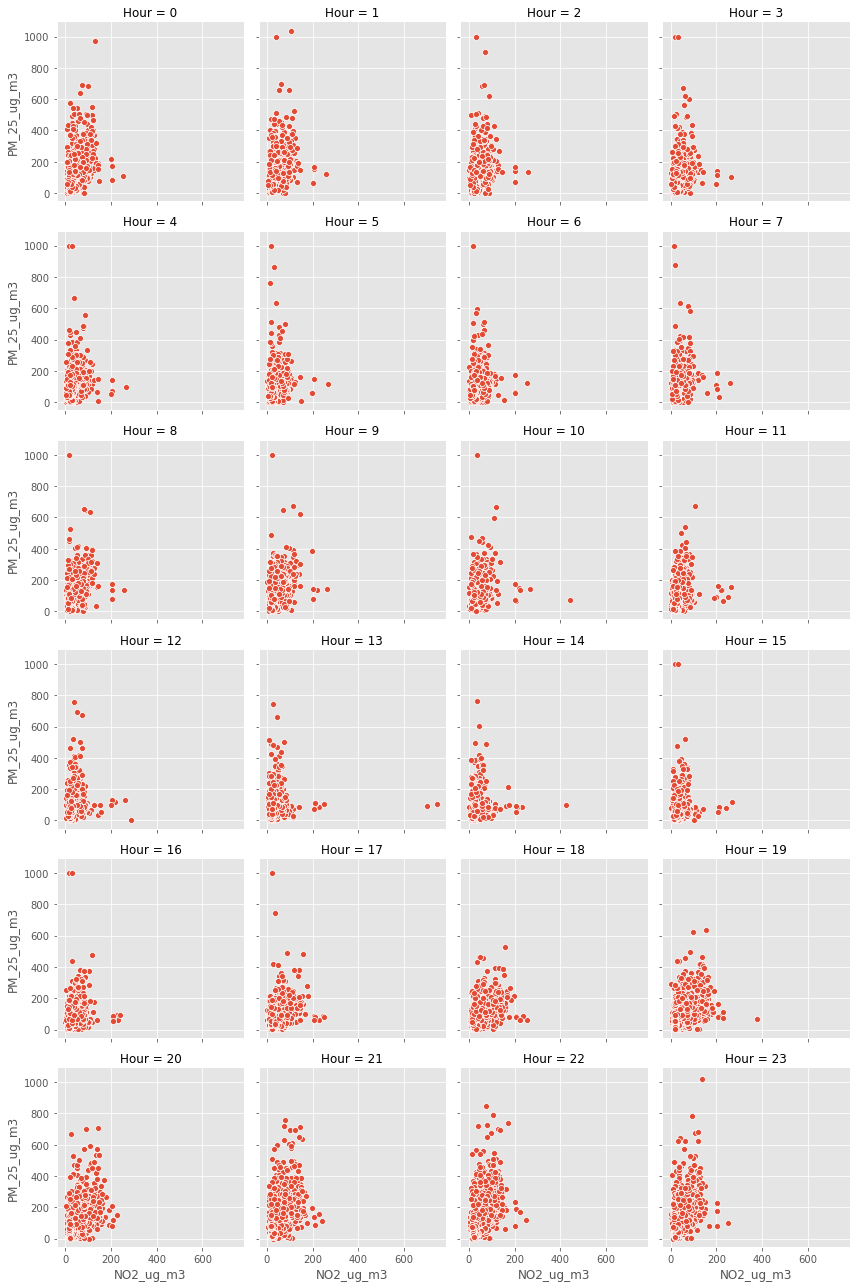

In [103]:
plots_2d(df1,x='NO2_ug_m3')

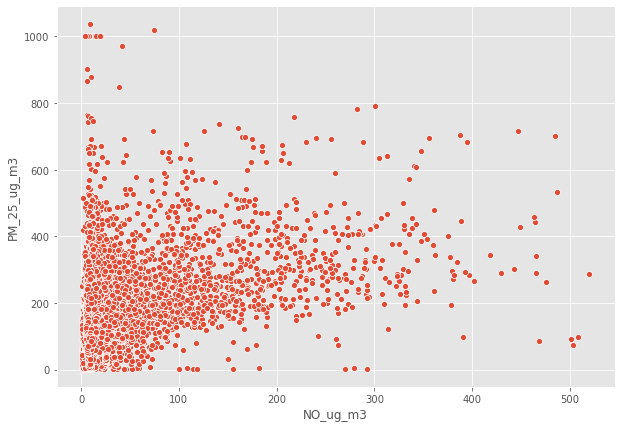

<Figure size 1080x720 with 0 Axes>

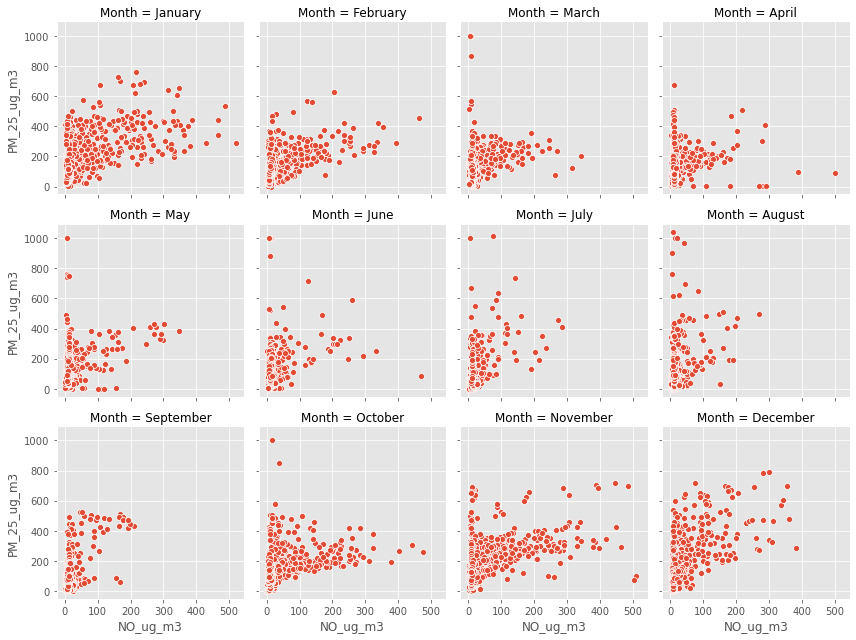

<Figure size 1080x720 with 0 Axes>

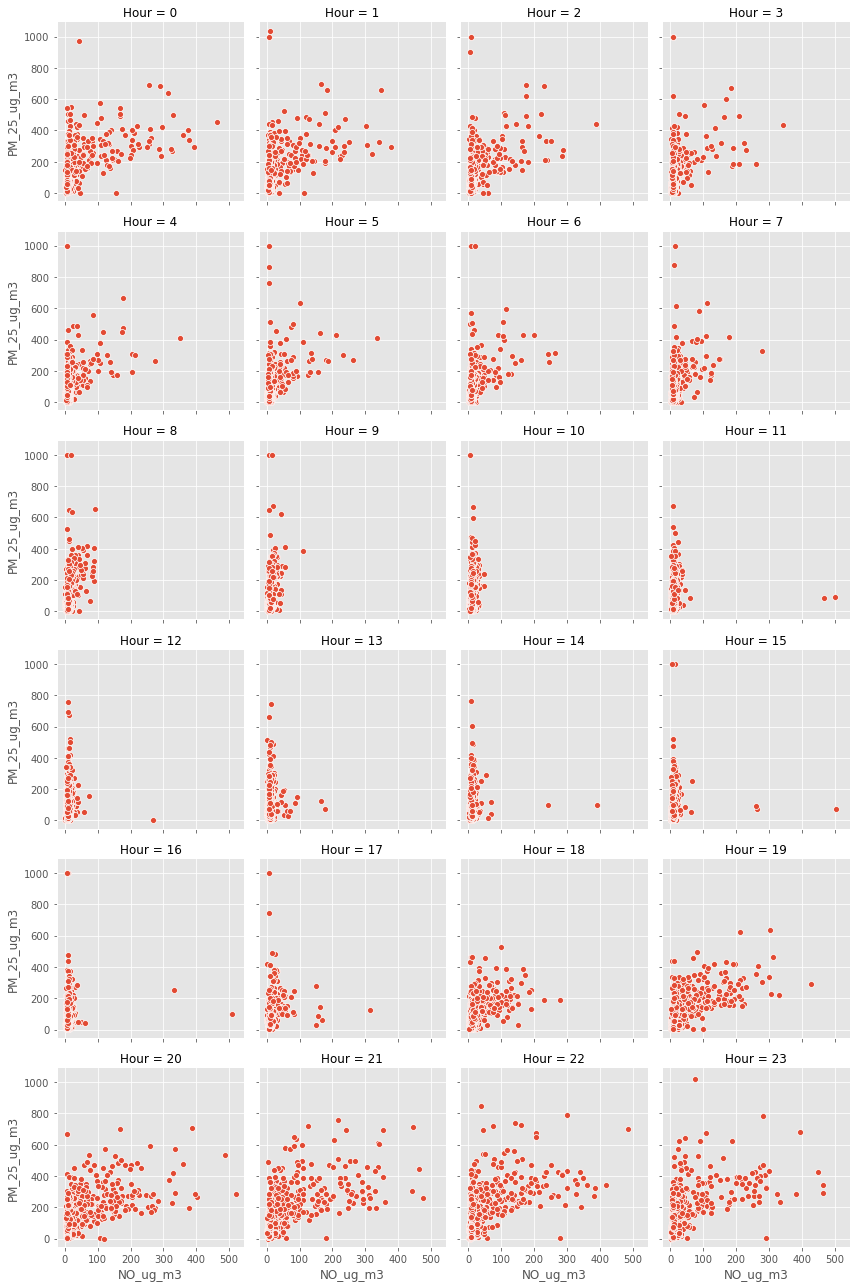

In [104]:
plots_2d(df1,x='NO_ug_m3')

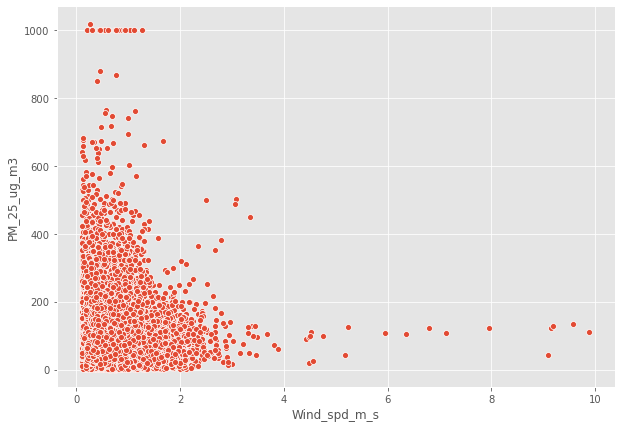

<Figure size 1080x720 with 0 Axes>

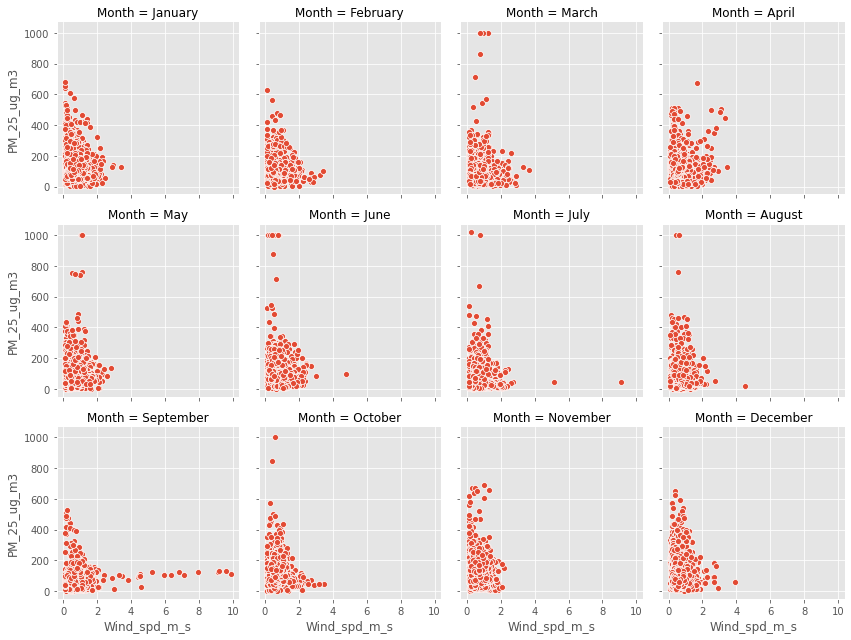

<Figure size 1080x720 with 0 Axes>

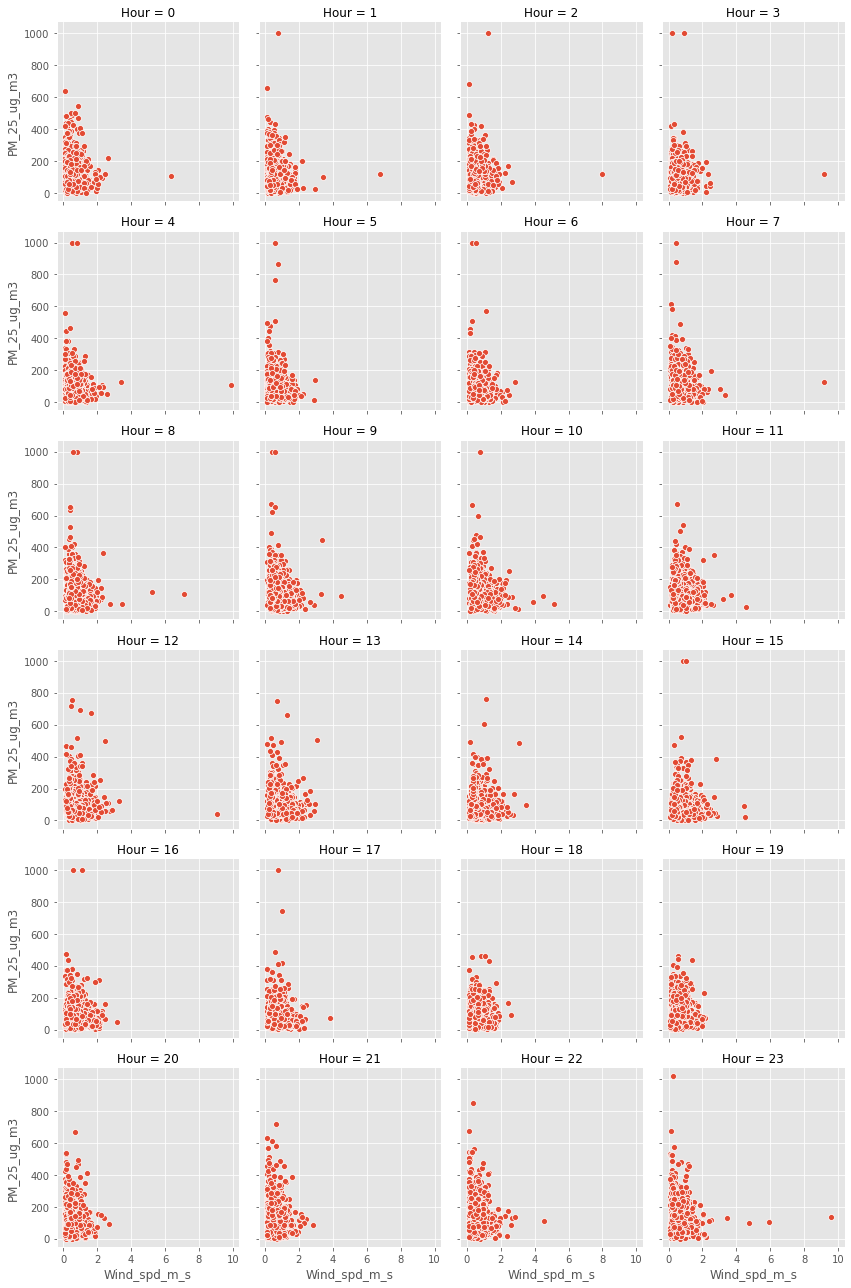

In [105]:
plots_2d(df1,x='Wind_spd_m_s')

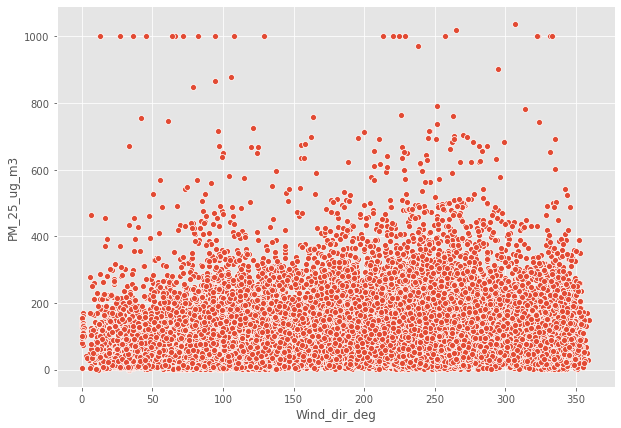

<Figure size 1080x720 with 0 Axes>

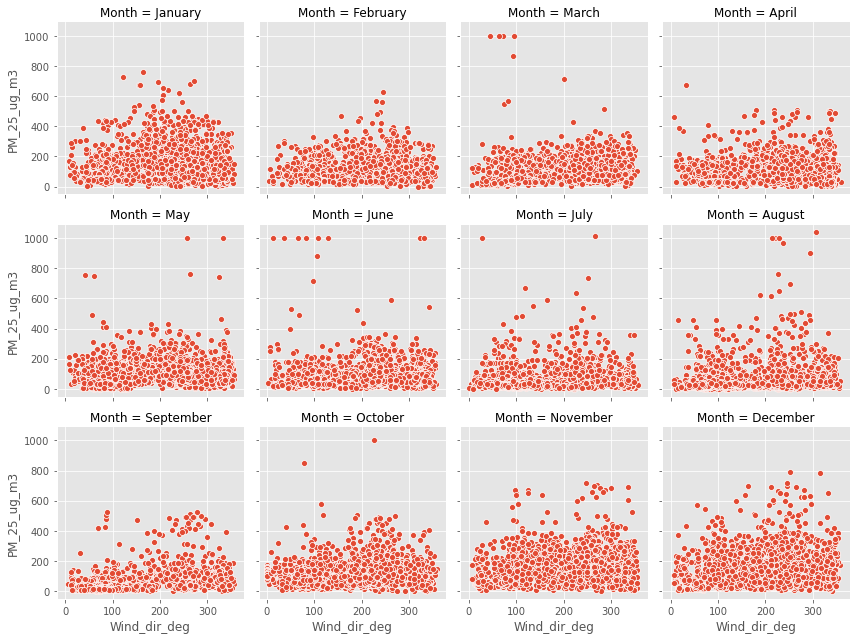

<Figure size 1080x720 with 0 Axes>

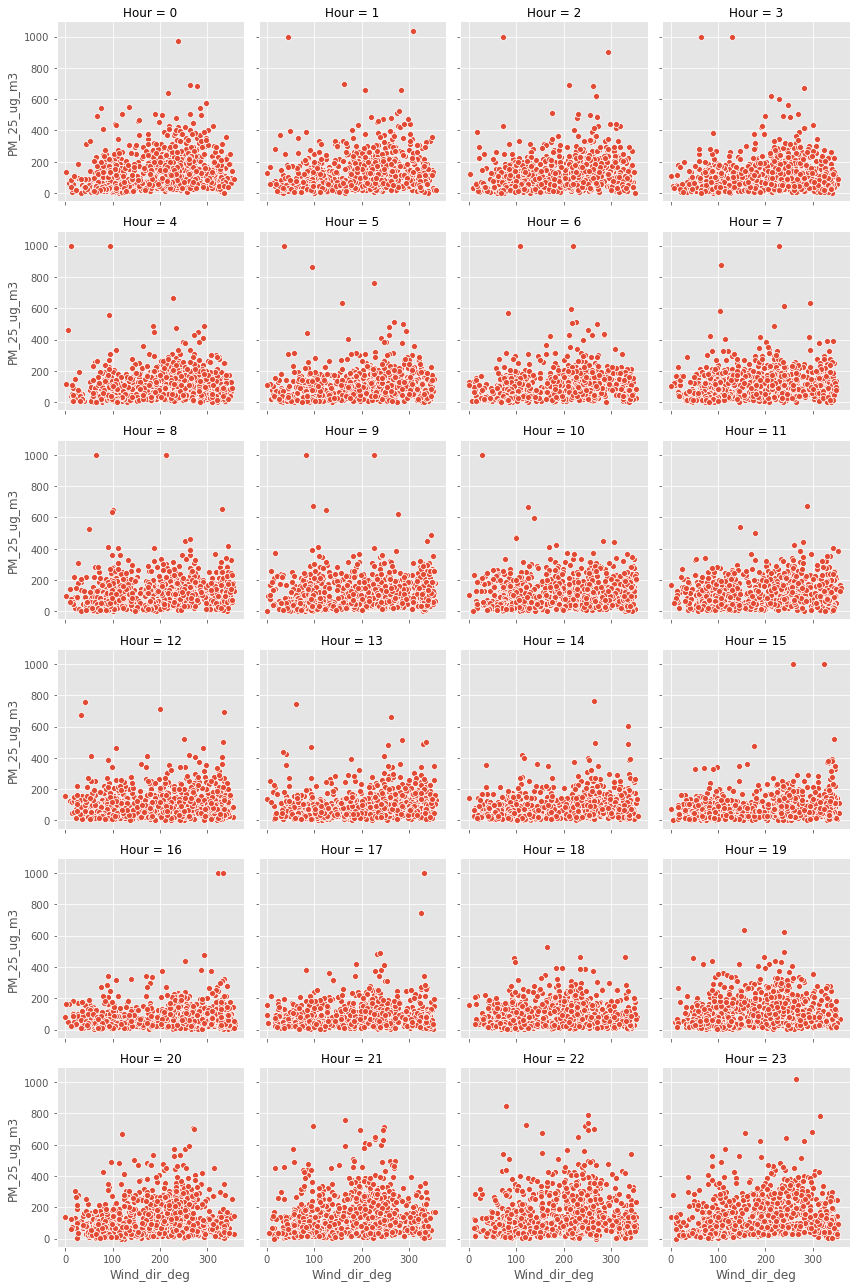

In [106]:
plots_2d(df1,x='Wind_dir_deg')

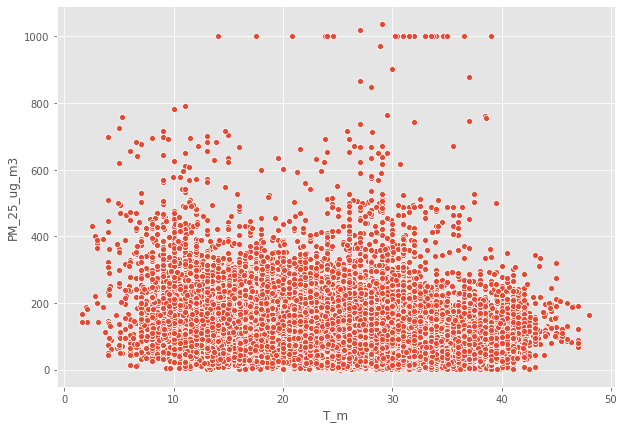

<Figure size 1080x720 with 0 Axes>

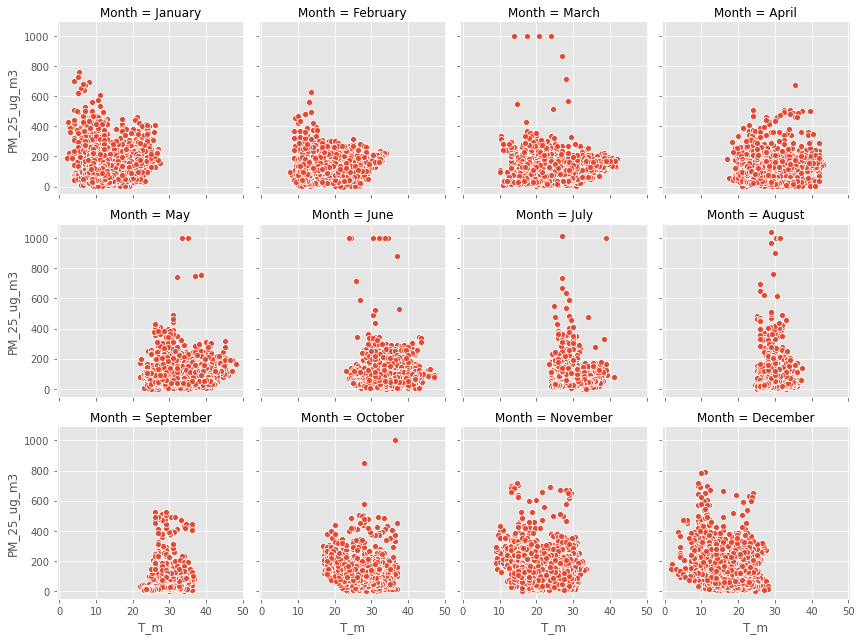

<Figure size 1080x720 with 0 Axes>

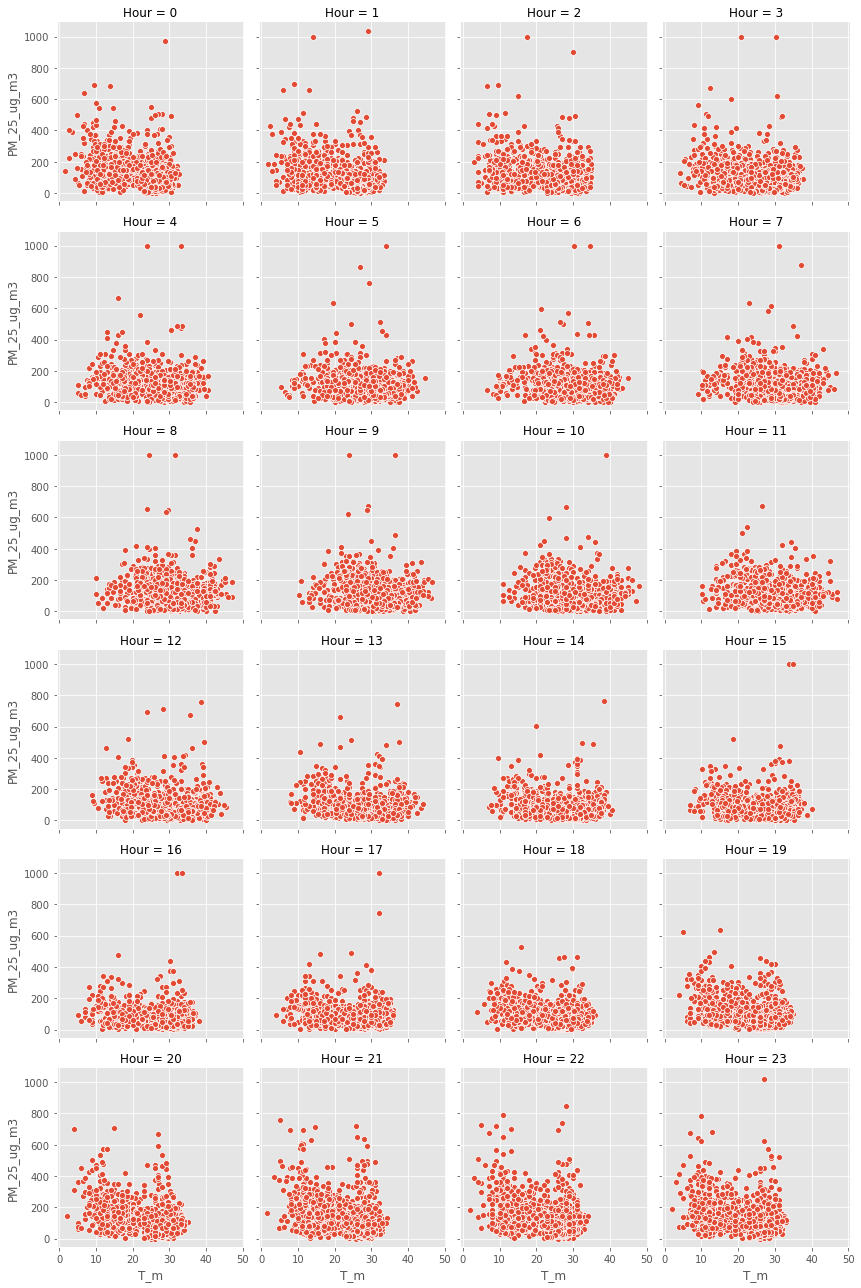

In [107]:
plots_2d(df1,x='T_m')

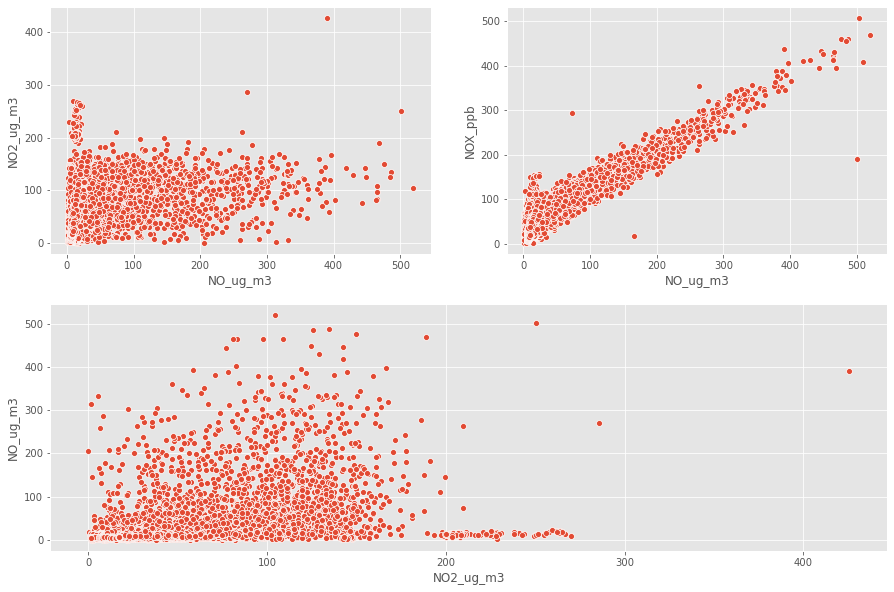

In [108]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(gs[0,0])
sns.scatterplot('NO_ug_m3','NO2_ug_m3',data=df1);
ax2 = fig.add_subplot(gs[0,1])
sns.scatterplot('NO_ug_m3','NOX_ppb',data=df1);
ax3 = fig.add_subplot(gs[1,:])
sns.scatterplot('NO2_ug_m3','NO_ug_m3',data=df1);

SO2 values tend to increase over the winter months (Nov-Dec) and tend to drop during the summer and monsoon period
<br>CO shows a moderate positive trend with PM2.5 as seen in all the scatterplots.
<br>NOX shows a moderate positive trend with PM2.5 as seen in all the scatterplots.
<br>NO shows a moderate positive trend with PM2.5 as seen in all the scatterplots.
<br>Wind speed shows a negative trend the PM 2.5 values. Few datapoints associated with high wind speeds (most of the high speed points during September) could be outliers but have been kept in the data and will be log transformed later during modeling.
<br>Temperature shows a slight negative trend with PM2.5 values. Winter months also show a slight uptick in PM values with drop in temperature
<br>The nitrogen compounds are correlated as seen. These could be decomposed as 1-2 features applying PCA or can be dropped during modeling as well. <br> The strongest linear correlation is seen between NOX and NO

In [109]:
df1.describe()

PM_25_ug_m3     SO2_ug_m3      O3_ug_m3      CO_mg_m3       NOX_ppb  \
count  22771.000000  22554.000000  22709.000000  22796.000000  22555.000000   
mean     113.994796      7.204229     34.812659      1.259228     38.024548   
std       95.411087      7.145177     32.273082      1.042414     40.843307   
min        0.010000      0.010000      1.020000      0.010000      1.060000   
25%       47.965000      3.540000     12.250000      0.650000     19.310000   
50%       90.950000      5.570000     24.060000      1.010000     25.950000   
75%      151.195000      8.980000     46.060000      1.530000     40.690000   
max     1038.500000    295.650000    306.980000     10.000000    999.990000   

          NO2_ug_m3      NO_ug_m3  Wind_spd_m_s  Wind_dir_deg  Solar_R_W_m2  \
count  22552.000000  22498.000000  18726.000000  22758.000000  22851.000000   
mean      43.456825     18.610433      0.732364    196.091990     65.758424   
std       32.999854     36.762339      0.486056     91.556869    100.174727   
min        0.030000      1.010000      0.110000      0.150000      0.010000   
25%       22.550000      7.550000      0.390000    108.000000      2.300000   
50%       33.030000     10.000000      0.650000    215.330000     23.470000   
75%       53.682500     13.830000      0.980000    264.860000     86.765000   
max      745.550000    519.820000      9.890000    359.400000   1032.070000   

       ...  NO_ug_m3_log  Wind_spd_m_s_log  Wind_dir_deg_log  \
count  ...  22498.000000      18726.000000      22758.000000   
mean   ...      2.538606          0.517228          5.126364   
std    ...      0.715313          0.246736          0.642442   
min    ...      0.698135          0.104360          0.139762   
25%    ...      2.145931          0.329304          4.691348   
50%    ...      2.397895          0.500775          5.376805   
75%    ...      2.696652          0.683097          5.582970   
max    ...      6.255404          2.387845          5.887215   

       Solar_R_W_m2_log       T_m_log       D_m_log          Year  \
count      22851.000000  24000.000000  23999.000000  24594.000000   
mean           2.935976      3.235866      2.868340   2017.975116   
std            1.776539      0.363234      0.442223      0.822338   
min            0.009950      0.963174     -0.703198   2017.000000   
25%            1.193922      3.056239      2.565718   2017.000000   
50%            3.197448      3.348500      2.944965   2018.000000   
75%            4.474663      3.481548      3.258481   2019.000000   
max            6.940290      3.892228      3.555777   2020.000000   

           Month_No   Day_of_Week          Hour  
count  24594.000000  24594.000000  24594.000000  
mean       6.455192      2.996219     11.499553  
std        3.389388      1.997341      6.916586  
min        1.000000      0.000000      0.000000  
25%        4.000000      1.000000      6.000000  
50%        6.000000      3.000000     12.000000  
75%        9.000000      5.000000     17.000000  
max       12.000000      6.000000     23.000000  

[8 rows x 30 columns]

Cyclical features can be transformed into two components (sine and cosine). This will help to emphasize that 23:00 and 0:00 hours are close to each other similar to months.

In [110]:
#Cyclical feature transformation into sine and cosine components
#Ref: https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
def cyclic_feat(df):
    #Month Cyclicity
    df['Month_sin'] = np.sin(df.Month_No*(2*np.pi/12))
    df['Month_cos'] = np.cos(df.Month_No*(2*np.pi/12))
    #Day Cyclicity
    df['Day_of_Week_sin'] = np.sin(df.Day_of_Week*(2*np.pi/7))
    df['Day_of_Week_cos'] = np.cos(df.Day_of_Week*(2*np.pi/7))
    #Hour Cyclicity
    df['Hour_sin'] = np.sin(df.Hour*(2*np.pi/24))
    df['Hour_cos'] = np.cos(df.Hour*(2*np.pi/24))
    #Wind Direction Cyclicity
    df['Wind_dir_sin'] = np.sin(df1.Wind_dir_deg*(2*np.pi/360))
    df['Wind_dir_cos'] = np.cos(df1.Wind_dir_deg*(2*np.pi/360))
    
    return df

# Check time cyclical encoding
def cyclical(x,y,annot):
    xy = list(zip(x,y))
    xy_dict = dict(zip(annot,xy))
    plt.figure(figsize=[10,10])
    plt.scatter(x,y)
    for a,b in xy_dict.items():
        #print(a,b)
        plt.annotate(str(a),(b[0],b[1]),fontsize=15)

#sns.scatterplot(x='Wind_dir_deg',y='Wind_dir_cos',data=df1,label='Cos',color='b')
#sns.scatterplot(x='Wind_dir_deg',y='Wind_dir_sin',data=df1,label='Sine',color='r')
#sns.scatterplot(x='Hour',y='Hour_cos',data=df1,label='Cos',color='b')
#sns.scatterplot(x='Hour',y='Hour_sin',data=df1,label='Sine',color='r')
#plt.figure(figsize=[5,5])
#sns.scatterplot(x='Day_No',y='Day_cos',data=df1,label='Cos',color='b')
#sns.scatterplot(x='Day_No',y='Day_sin',data=df1,label='Sine',color='r')

In [111]:
df1.equals(df1_1H)

False

In [112]:
df1 = cyclic_feat(df1)
df1_1H = cyclic_feat(df1_1H)

In [113]:
df1.equals(df1_1H)

False

In [114]:
df1.columns

Index(['PM_25_ug_m3', 'SO2_ug_m3', 'O3_ug_m3', 'CO_mg_m3', 'NOX_ppb',
       'NO2_ug_m3', 'NO_ug_m3', 'Wind_spd_m_s', 'Wind_dir_deg', 'Solar_R_W_m2',
       'Bar_P_mmHg', 'T_m', 'D_m', 'RH_NOAA_augroch', 'PM_25_ug_m3_log',
       'SO2_ug_m3_log', 'O3_ug_m3_log', 'CO_mg_m3_log', 'NOX_ppb_log',
       'NO2_ug_m3_log', 'NO_ug_m3_log', 'Wind_spd_m_s_log', 'Wind_dir_deg_log',
       'Solar_R_W_m2_log', 'T_m_log', 'D_m_log', 'Year', 'Month_No',
       'Day_of_Week', 'Hour', 'Day', 'Month', 'Y/M', 'Month_sin', 'Month_cos',
       'Day_of_Week_sin', 'Day_of_Week_cos', 'Hour_sin', 'Hour_cos',
       'Wind_dir_sin', 'Wind_dir_cos'],
      dtype='object')

In [115]:
df1_1H.columns

Index(['PM_25_ug_m3', 'SO2_ug_m3', 'O3_ug_m3', 'CO_mg_m3', 'NOX_ppb',
       'NO2_ug_m3', 'NO_ug_m3', 'Wind_spd_m_s', 'Wind_dir_deg', 'Solar_R_W_m2',
       'Bar_P_mmHg', 'T_m', 'D_m', 'RH_NOAA_augroch', 'PM_25_ug_m3_log',
       'SO2_ug_m3_log', 'O3_ug_m3_log', 'CO_mg_m3_log', 'NOX_ppb_log',
       'NO2_ug_m3_log', 'NO_ug_m3_log', 'Wind_spd_m_s_log', 'Wind_dir_deg_log',
       'Solar_R_W_m2_log', 'T_m_log', 'D_m_log', 'Year', 'Month_No',
       'Day_of_Week', 'Hour', 'Day', 'Month', 'Y/M', 'Month_sin', 'Month_cos',
       'Day_of_Week_sin', 'Day_of_Week_cos', 'Hour_sin', 'Hour_cos',
       'Wind_dir_sin', 'Wind_dir_cos'],
      dtype='object')

In [116]:
df1.columns.equals(df1_1H.columns)

True

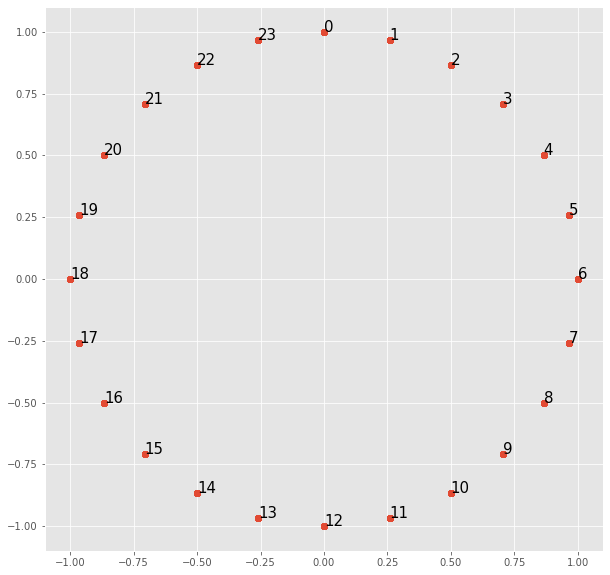

In [117]:
cyclical(df1['Hour_sin'],df1['Hour_cos'],df1['Hour'])

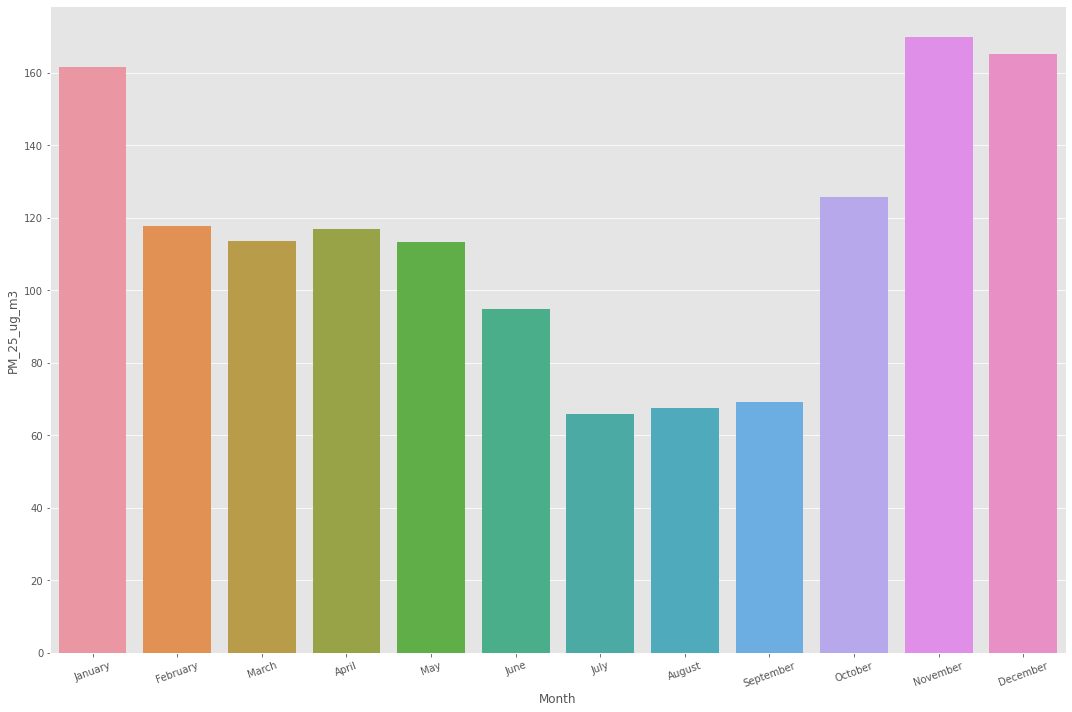

In [118]:
plt.figure(figsize=(15,10))
mth = ['January','February','March','April','May','June','July','August','September','October','November','December']
sns.barplot(x='Month',y='PM_25_ug_m3',data=df1.groupby('Month').mean().reset_index(),order=mth)
plt.xticks(rotation=20);
plt.tight_layout()

As seen, seasonality seems to affect PM2.5 values with higher values during winter and progressive drop over the summer and monsoon months

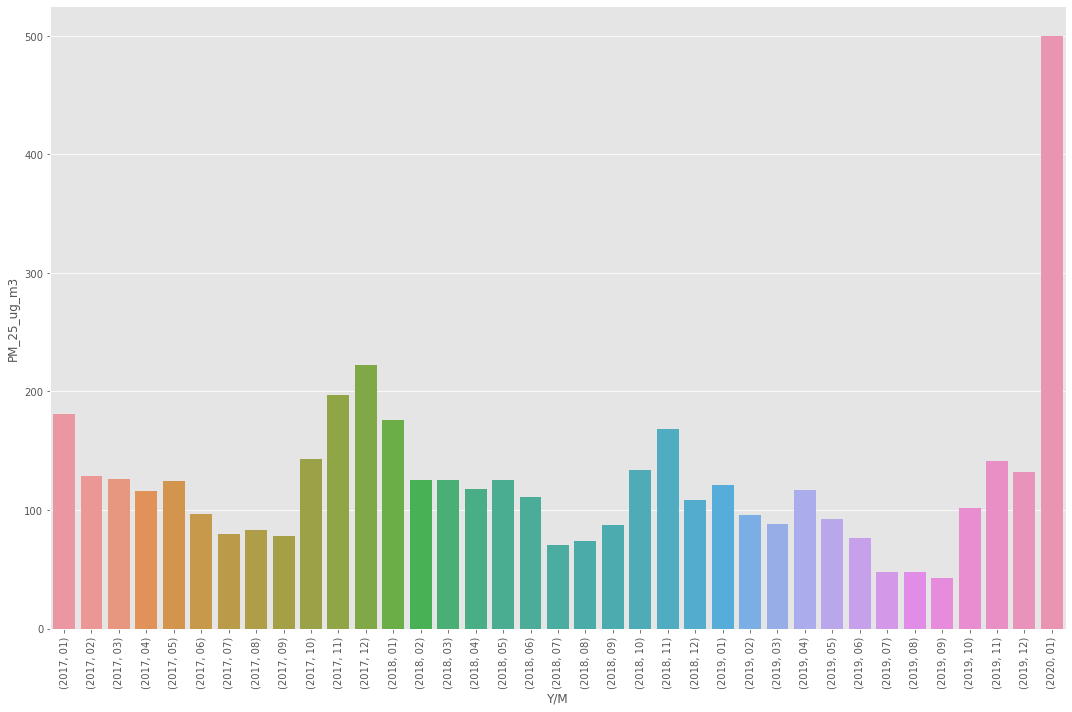

In [119]:
df1.groupby('Y/M').mean().reset_index()
plt.figure(figsize=(15,10))
sns.barplot(x='Y/M',y='PM_25_ug_m3',data=df1.groupby('Y/M').mean().reset_index())
plt.xticks(rotation=90);
plt.tight_layout()

Month effects as seen in the two plots above show high PM values during winter months (Oct-January), drop during summer and are in their lowest range during the monsoon season.

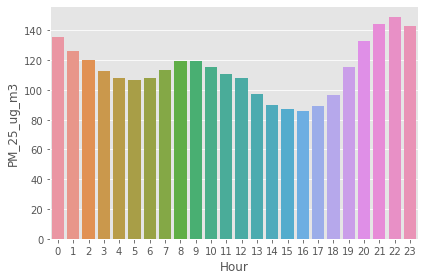

In [120]:
sns.barplot(x='Hour',y='PM_25_ug_m3',data=df1.groupby('Hour').mean().reset_index())
plt.xticks(rotation=0);
plt.tight_layout()

Time of day shows appears to correlate with the PM 2.5 values. As seen the values drop from midnight to 6 am, peak at 9 am, drop again until 4 pm and show another peak at 10 pm. 

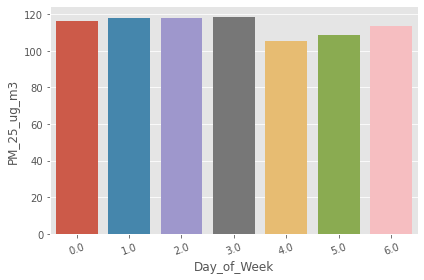

In [121]:
sns.barplot(x='Day_of_Week',y='PM_25_ug_m3',data=df1.groupby('Day').mean().reset_index())
plt.xticks(rotation=20);
plt.tight_layout()

PM 2.5 values are higher during weekdays with slight drops over Friday-Sunday

In [122]:
df1.columns

Index(['PM_25_ug_m3', 'SO2_ug_m3', 'O3_ug_m3', 'CO_mg_m3', 'NOX_ppb',
       'NO2_ug_m3', 'NO_ug_m3', 'Wind_spd_m_s', 'Wind_dir_deg', 'Solar_R_W_m2',
       'Bar_P_mmHg', 'T_m', 'D_m', 'RH_NOAA_augroch', 'PM_25_ug_m3_log',
       'SO2_ug_m3_log', 'O3_ug_m3_log', 'CO_mg_m3_log', 'NOX_ppb_log',
       'NO2_ug_m3_log', 'NO_ug_m3_log', 'Wind_spd_m_s_log', 'Wind_dir_deg_log',
       'Solar_R_W_m2_log', 'T_m_log', 'D_m_log', 'Year', 'Month_No',
       'Day_of_Week', 'Hour', 'Day', 'Month', 'Y/M', 'Month_sin', 'Month_cos',
       'Day_of_Week_sin', 'Day_of_Week_cos', 'Hour_sin', 'Hour_cos',
       'Wind_dir_sin', 'Wind_dir_cos'],
      dtype='object')

In [123]:
list1 = ['PM_25_ug_m3_log','SO2_ug_m3_log','O3_ug_m3_log','CO_mg_m3_log','NOX_ppb_log','NO2_ug_m3_log',
         'NO_ug_m3_log','Wind_spd_m_s_log','Solar_R_W_m2_log','T_m_log','D_m_log','Month_sin', 
         'Month_cos','Day_sin','Day_cos', 'Hour_sin', 'Hour_cos', 'Wind_dir_sin', 'Wind_dir_cos','Bar_P_mmHg']

list2 = ['PM_25_ug_m3_log','SO2_ug_m3_log','O3_ug_m3_log','CO_mg_m3_log','NO_ug_m3_log','Wind_spd_m_s_log',
         'T_m_log','D_m_log','Year','Month_sin', 'Month_cos','Day_of_Week_sin','Day_of_Week_cos', 'Hour_sin', 
         'Hour_cos','Wind_dir_sin', 'Wind_dir_cos','Bar_P_mmHg']

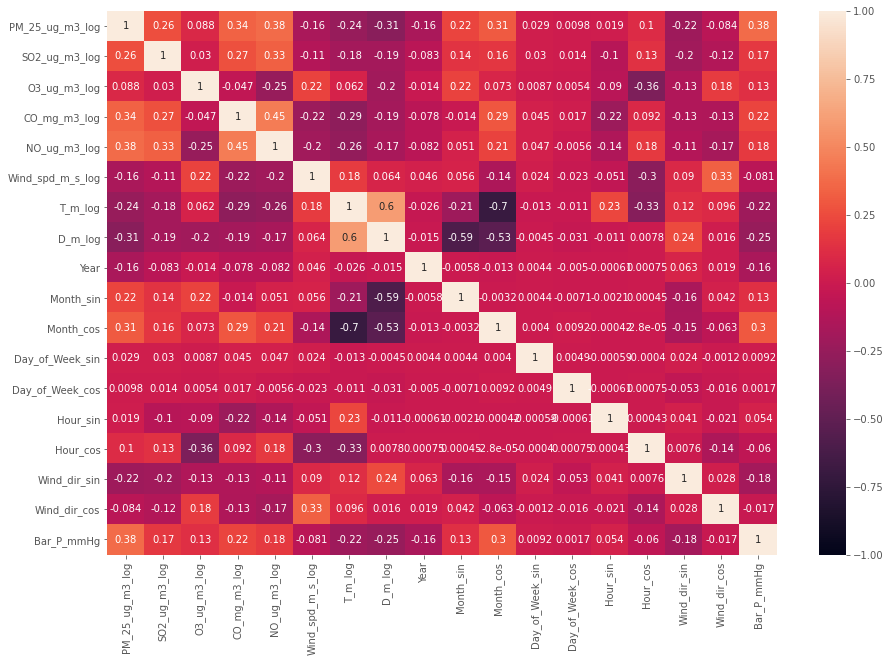

In [124]:
plt.figure(figsize=[15,10])
sns.heatmap(df1[list2].corr(),annot=True,vmin=-1,vmax=+1);

PM2.5 slightly negatively correlated with Wind Speed, ambient and dew temparatures
<br>PM2.5 shows positive correlation with other pollutants SO2, CO, NOx, NO2, NO
<br>There appears high multi-collinearity between the nitrogen compounds (NOX_ppb, NO2_ug_m3 & NO_ug_m3). All but one of these features can be dropped during modeling.
<br> O3_ug_m3 and Solar radiation do not show a strong correlation with the PM values and could be dropped during modeling
<br>

In [125]:
df1.columns

Index(['PM_25_ug_m3', 'SO2_ug_m3', 'O3_ug_m3', 'CO_mg_m3', 'NOX_ppb',
       'NO2_ug_m3', 'NO_ug_m3', 'Wind_spd_m_s', 'Wind_dir_deg', 'Solar_R_W_m2',
       'Bar_P_mmHg', 'T_m', 'D_m', 'RH_NOAA_augroch', 'PM_25_ug_m3_log',
       'SO2_ug_m3_log', 'O3_ug_m3_log', 'CO_mg_m3_log', 'NOX_ppb_log',
       'NO2_ug_m3_log', 'NO_ug_m3_log', 'Wind_spd_m_s_log', 'Wind_dir_deg_log',
       'Solar_R_W_m2_log', 'T_m_log', 'D_m_log', 'Year', 'Month_No',
       'Day_of_Week', 'Hour', 'Day', 'Month', 'Y/M', 'Month_sin', 'Month_cos',
       'Day_of_Week_sin', 'Day_of_Week_cos', 'Hour_sin', 'Hour_cos',
       'Wind_dir_sin', 'Wind_dir_cos'],
      dtype='object')

In [126]:
missing_17_19 = pd.concat([df1.isna().sum(), 100 * df1.isna().mean()], axis=1)
missing_17_19.columns = ['Count', '%']
missing_17_19.sort_values(by=['Count'],ascending=False)

Count          %
Wind_spd_m_s       5868  23.859478
Wind_spd_m_s_log   5868  23.859478
NO_ug_m3_log       2096   8.522404
NO_ug_m3           2096   8.522404
NO2_ug_m3          2042   8.302838
NO2_ug_m3_log      2042   8.302838
SO2_ug_m3_log      2040   8.294706
SO2_ug_m3          2040   8.294706
NOX_ppb            2039   8.290640
NOX_ppb_log        2039   8.290640
O3_ug_m3           1885   7.664471
O3_ug_m3_log       1885   7.664471
Wind_dir_sin       1836   7.465235
Wind_dir_deg_log   1836   7.465235
Wind_dir_cos       1836   7.465235
Wind_dir_deg       1836   7.465235
PM_25_ug_m3_log    1823   7.412377
PM_25_ug_m3        1823   7.412377
CO_mg_m3_log       1798   7.310726
CO_mg_m3           1798   7.310726
Solar_R_W_m2       1743   7.087094
Solar_R_W_m2_log   1743   7.087094
Bar_P_mmHg         1636   6.652029
RH_NOAA_augroch     597   2.427421
D_m_log             595   2.419289
D_m                 594   2.415223
T_m_log             594   2.415223
T_m                 594   2.415223
Month_cos             0   0.000000
Hour_cos              0   0.000000
Hour_sin              0   0.000000
Day_of_Week_cos       0   0.000000
Day_of_Week_sin       0   0.000000
Hour                  0   0.000000
Month_sin             0   0.000000
Y/M                   0   0.000000
Month                 0   0.000000
Day                   0   0.000000
Month_No              0   0.000000
Year                  0   0.000000
Day_of_Week           0   0.000000

In [127]:
df1.isnull().any(axis=1).sum()
df1.shape

(24594, 41)

To finally build a regression model predicting PM 2.5, we will test two approaches:
    1. Directly apply scikit-learn's train_test_split to the data without considering it's order based on time and make predictions for the test dataset.
        This approach will be susceptible to data leakage as there is a possibility for future datapoints to be included in the training dataset and be used to predict past values.
    2. As a realistic approach,  the data will be split based on the temporal order.
        Ex. Train on data between Jan 2017 - Nov 2019. Make predictions for Dec 2019.

Two prediction approaches will be tested for both the cases above:
    1. Use a single model to predict for the test set.
    2. Apply walk forward validation to retrain models by updating training data with the observed value for the predicted forecast to use in building the next prediction.
    
Both approaches will be checked for random split as well as time based split to compare results.
    
Missing Value Imputation: Mean imputation will be used to impute missing values.

Modeling with/without Lag Variables: Test the effect of predicting with and without lagging variables for all the parameters in our data. It is expected that the last few hour value features for PM2.5 would be a good predictor for the next hourly forecast.

As was mentioned before, there are gaps in the dataset and thus adding these features as is would not strictly represent previous hourly features for all datapoints.
Thus a resampled dataset was created to check if that improves the results. 

Define a function to add lag variables to the dataframe

In [346]:
#Define lag function
def add_lags(df,periods=5):
    for a in df.columns:
        for b in range(periods):
            df[a+'_(H-'+str(b+1)+')'] = df[a].shift(b+1)
    df = df.copy()
    #Drop previous rows (# of periods)
    df = df.iloc[periods:]
    #df = df.dropna()
    return df

Define a function to model both random as well as sequential split. <br>This model splits data as specified, 
<br>adds lag variables if specified, <br>imputes with the mean if specified, <br>fits a model <br>and prints scores and plots the observed and predicted values. This function trains a single model to predict the entire test set.

In [347]:
def mod_eval(DF,start,end,mod,cols,impute=False,predictions=100,test_size=0.2,lags=False,
             periods=3,random=True,log_c=True,plots=True):
    #Define data to be used for the model
    
    target = 'PM_25_ug_m3'
    
    if log_c == True:

        target = 'PM_25_ug_m3_log'
    
    df = DF[cols].loc[start:end,:].sort_index()
    
    # Add lag variables if needed
    
    if lags == True:
        df = add_lags(df.copy(),periods)
    
    if random == True: 
        #Randomly split into train and test sets without considering the temporal order
        #print(df.columns)
        X = df.drop([target],axis=1)
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=100)
        train = pd.concat([X_train,y_train],axis=1)
        test = pd.concat([X_test,y_test],axis=1)
        test_time = test.index
        #tren = train
        #tst = test
        
    elif random == False:
        train = df.iloc[:-predictions,:]
        test = df.iloc[-predictions:,:]
        test_time = test.index
        #tren = train
        #tst = test
    
    #Impute all missing data with mean
    if impute == True:
        sm = SimpleImputer(strategy='mean')
        sm.fit(train)
        train = pd.DataFrame(sm.transform(train),columns=train.columns)
        test = pd.DataFrame(sm.transform(test),columns=test.columns)
    
    #Scale the data before fitting
    sl_x = StandardScaler()
    sl_y = StandardScaler()
    xcols = train.drop([target],axis=1).columns
    #print(train.columns)
    sl_x.fit(train[xcols])
    sl_y.fit(train[target].values.reshape(-1,1))
    
    train_y = pd.DataFrame(sl_y.transform(train[target].values.reshape(-1,1)),columns=[target])
    train = pd.DataFrame(sl_x.transform(train[xcols]),columns=xcols)
    train = pd.concat([train,train_y],axis=1)
    
    test_y = pd.DataFrame(sl_y.transform(test[target].values.reshape(-1,1)),columns=[target])
    test = pd.DataFrame(sl_x.transform(test[xcols]),columns=xcols)
    test = pd.concat([test,test_y],axis=1)
    
    #Fit a model
    X_train = train.drop([target],axis=1)
    X_test = test.drop([target],axis=1)
    y_train = train[target]
    y_test = test[target]
    mod.fit(X_train,y_train)
    y_test_pred = mod.predict(X_test)
    
    y_test = sl_y.inverse_transform(y_test.values.reshape(-1,1))
    y_test_pred = sl_y.inverse_transform(y_test_pred)
    
    if log_c == True:
        y_test_pred = np.exp(y_test_pred)-1
        y_test = np.exp(y_test)-1
        
    #Results
    
    if random == True:
        
        print('Mean Absolute Error: ',mae(y_test,y_test_pred),'RMSE: ',np.sqrt(mse(y_test,y_test_pred)))
        obs = pd.DataFrame(y_test).rename(columns={0:'Observed_PM25'}).set_index(test_time)
        pred = pd.DataFrame(y_test_pred).rename(columns={0:'Predicted_PM25'}).set_index(test_time)
        results = pd.concat([obs,pred],axis=1)
        print('Random split predictions for all ',len(pred) ,' requested points')
        
        if plots == True:
            #Plots
            gs = gridspec.GridSpec(1,2)
            fig = plt.figure(figsize=(15,10))

            ax1 = fig.add_subplot(gs[0,0])
            ax1.title.set_text('Scatter plot Observed vs Predicted')
            ax1.set(xlabel='Observed PM2.5 Values',ylabel='Predicted PM2.5 Values')
            xy = np.arange(0,700)
            sns.lineplot(xy,xy,ax= ax1,color='blue')
            sns.scatterplot(results['Observed_PM25'],results['Predicted_PM25'],ax=ax1)

            ax2 = fig.add_subplot(gs[0,1])
            ax2.title.set_text('Feature Importance')
            imp = pd.DataFrame(mod.feature_importances_,X_train.columns).reset_index()
            imp = imp.rename(columns={'index':'Features',0:'Feature_Importance'})
            sns.barplot(x='Feature_Importance',y='Features',data=imp.nlargest(15,'Feature_Importance'),ax=ax2)
            plt.tight_layout()
            #results = {'obs':obs,'pred':pred,'rmse':RMSE_ind}
    
    else:
        print('Mean Absolute Error: ',mae(y_test,y_test_pred),'RMSE: ',np.sqrt(mse(y_test,y_test_pred)))
        obs = pd.DataFrame(y_test).rename(columns={0:'Observed_PM25'}).set_index(test_time)
        pred = pd.DataFrame(y_test_pred).rename(columns={0:'Predicted_PM25'}).set_index(test_time)
        results = pd.concat([obs,pred],axis=1)
        print('Time based predictions for all ',predictions ,' requested points')
        
        if plots == True:
            #Plots
            gs = gridspec.GridSpec(2,2)
            fig = plt.figure(figsize=(15,10))

            ax1 = fig.add_subplot(gs[0,0])
            ax1.title.set_text('Scatter plot Observed vs Predicted')
            ax1.set(xlabel='Observed PM2.5 Values',ylabel='Predicted PM2.5 Values')
            xy = np.arange(0,600)
            sns.lineplot(xy,xy,ax= ax1,color='blue')
            sns.scatterplot(results['Observed_PM25'],results['Predicted_PM25'],ax=ax1)

            ax2 = fig.add_subplot(gs[0,1])
            ax2.title.set_text('Feature Importance')
            imp = pd.DataFrame(mod.feature_importances_,X_train.columns).reset_index()
            imp = imp.rename(columns={'index':'Features',0:'Feature_Importance'})
            sns.barplot(x='Feature_Importance',y='Features',data=imp.nlargest(15,'Feature_Importance'),ax=ax2)

            ax3 = fig.add_subplot(gs[1,:])
            ax3.title.set_text('Observed vs Predicted Series')
            sns.lineplot(data=results,ax=ax3)
            plt.xticks(rotation=40)

            plt.tight_layout()
            #ax1 = plt.plot(c.index,c['Observed_PM25'])
            #ax2 = plt.plot(c.index,c['Predicted_PM25'])
            #ax1 = (c['Observed_PM25']).plot(label='Observed')
            #ax2 = (c['Predicted_PM25']).plot(label='Predicted')
            #ax3 = df1.loc['2017-11-18 12:00:00':'2017-11-30 23:00:00','PM_25_ug_m3'].plot()
        
    return results

Function to test walk forward validation on a random split as well as a sequential split

In [363]:
#Walk Forward Validation
def walk_forward(DF,start,end,mod,cols,impute=False,periods=2,log_c=True,predictions=20,
                 random=False,test_size=0.01,plots=True):
    #Define data columns to be used for the walk forward training
    
    target = 'PM_25_ug_m3'
    
    if log_c == True:
        
        target = 'PM_25_ug_m3_log'
    
    df = DF[cols]
    #data = df.loc['2017-01-01 00:00:00':'2017-11-30 23:00:00'].sort_index()
    
    #Specify dataset to be used for modeling
    
    data = df.loc[start:end,:].sort_index()
    #print(len(data))
    
    # Add lag variables and remove first period # of rows that get filled with np.nan
    data = add_lags(data.copy(),periods)
    
    if random == True:
        
        X = data.drop(target,axis=1)
        y = data[target]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=100)
        train = pd.concat([X_train,y_train],axis=1)
        #train['is_train'] = 1
        test = pd.concat([X_test,y_test],axis=1)
        #test['is_train'] = 0
        data = pd.concat([train,test],axis=0)
        print('Train size: ',len(X_train),'Test size: ',len(X_test))
    
    data_time = data.index
    test_time = data.iloc[-predictions:].index

    tot = len(data)
    tr = len(data.iloc[:-predictions])
    
    if random == True:
        tr = len(train)
    
    obs = []
    pred = []
    
    train_ind = []
    test_ind = []
    test_data = []
    RMSE_ind = []
    print('Total data: ',tot,'Initial training data: ',tr)
    b = 0
    for a in range(tr,tot):

        train = data.iloc[0:a]
        train_ind.append(train.index[-1])
        #print('last train: ',train.iloc[-1])
        #print('train: ',len(train))
        test = data.iloc[a:a+1]
        test_data.append(test)
        test_ind.append(test.index)
        #print('train: ',len(train),'test: ',len(test))

        if impute == True:
            #Impute all missing data with mean
            sm = SimpleImputer(strategy='mean')
            sm.fit(train)
            train = pd.DataFrame(sm.transform(train),columns=train.columns)
            test = pd.DataFrame(sm.transform(test),columns=test.columns)
            t_imp_mean = train
            
        #Scale the data before fitting
        sl_x = StandardScaler()
        sl_y = StandardScaler()
        xcols = train.drop([target],axis=1).columns
        #print(train.columns)
        sl_x.fit(train[xcols])
        sl_y.fit(train[target].values.reshape(-1,1))
        
        
        train_y = pd.DataFrame(sl_y.transform(train[target].values.reshape(-1,1)),columns=[target])
        train = pd.DataFrame(sl_x.transform(train[xcols]),columns=xcols)
        train = pd.concat([train,train_y],axis=1)
    
        test_y = pd.DataFrame(sl_y.transform(test[target].values.reshape(-1,1)),columns=[target])
        test = pd.DataFrame(sl_x.transform(test[xcols]),columns=xcols)
        test = pd.concat([test,test_y],axis=1)
            
        #Fit a model
        #print('Splitting into train and test')
        X_train = train.drop([target],axis=1)
        X_test = test.drop([target],axis=1)
        y_train = train[target]
        y_test = test[target]
        #print('Starting to fit for predicting: ',test['PM_25_ug_m3_log'])
        mod.fit(X_train,y_train)
        b = b+1
        if b%20 == 0:    
            print('Fitted',b,'/',(tot-tr),'th model')
        y_test_pred = mod.predict(X_test)
        
        #y_test = sl_y.inverse_transform(y_test.values.reshape(1,-1))
        y_test = sl_y.inverse_transform(y_test)
        y_test_pred = sl_y.inverse_transform(y_test_pred)
        
        if log_c == True:
            y_test = np.exp(y_test)-1
            y_test_pred = (np.exp(y_test_pred) - 1)
        #print('Predicted: ',y_test_pred,' for ',y_test)
        #print('appending results')
        
        obs.append(y_test)
        #print(y_test,type(y_test))
        #print(obs)
        pred.append(y_test_pred)
        #print(pred)
        RMSE_ind.append(np.sqrt(mse(y_test,y_test_pred)))
        #print(RMSE_ind)
    #Results
    if random == True:
        #obs_df = pd.DataFrame(pd.concat(obs)).reset_index()[target]
        obs_df = pd.DataFrame(obs).rename(columns={0:'Observed_PM25'})
        #.reset_index().drop(['index'],axis=1)
        pred_df = pd.DataFrame(pred).rename(columns={0:'Predicted_PM25'})
        rmse_df = pd.DataFrame(RMSE_ind).rename(columns={0:'RMSE'})
        #print(obs_df.shape,pred_df.shape,rmse_df.shape)
        results = pd.concat([obs_df,pred_df,rmse_df],axis=1)
        #.rename(columns={target:'Observed_PM25'})
        print('Random split predictions for all ',len(pred_df) ,' requested points')
        
        if plots == True:
            #Plots
            gs = gridspec.GridSpec(1,2)
            fig = plt.figure(figsize=(15,10))

            ax1 = fig.add_subplot(gs[0,0])
            ax1.title.set_text('Scatter plot Observed vs Predicted')
            ax1.set(xlabel='Observed PM2.5 Values',ylabel='Predicted PM2.5 Values')
            xy = np.arange(0,700)
            sns.lineplot(xy,xy,ax= ax1,color='blue')
            sns.scatterplot(results['Observed_PM25'],results['Predicted_PM25'],ax=ax1)

            ax2 = fig.add_subplot(gs[0,1])
            ax2.title.set_text('Feature Importance')
            imp = pd.DataFrame(mod.feature_importances_,X_train.columns).reset_index()
            imp = imp.rename(columns={'index':'Features',0:'Feature_Importance'})
            sns.barplot(x='Feature_Importance',y='Features',data=imp.nlargest(15,'Feature_Importance'),ax=ax2)
            ax2.set_title('Feature Importance for the last model')
            plt.tight_layout()
            #results = {'obs':obs,'pred':pred,'rmse':RMSE_ind}
        
    else:
        
        #obs_df = pd.DataFrame(pd.concat(obs)).rename(columns={0:'Observed_PM25'}).set_index(test_time)
        obs_df = pd.DataFrame(obs).rename(columns={0:'Observed_PM25'}).set_index(test_time)
        pred_df = pd.DataFrame(pred).rename(columns={0:'Predicted_PM25'}).set_index(test_time)
        rmse_df = pd.DataFrame(RMSE_ind).rename(columns={0:'RMSE'}).set_index(test_time)
        results = pd.concat([obs_df,pred_df,rmse_df],axis=1).rename(columns={target:'Observed_PM25'})
        print('Time based predictions for all ',predictions ,' requested points')
        
        if plots == True:
            #Plots
            gs = gridspec.GridSpec(2,2)
            fig = plt.figure(figsize=(15,10))

            ax1 = fig.add_subplot(gs[0,0])
            ax1.title.set_text('Scatter plot Observed vs Predicted')
            ax1.set(xlabel='Observed PM2.5 Values',ylabel='Predicted PM2.5 Values')
            xy = np.arange(0,600)
            sns.lineplot(xy,xy,ax= ax1,color='blue')
            sns.scatterplot(results['Observed_PM25'],results['Predicted_PM25'],ax=ax1)

            ax2 = fig.add_subplot(gs[0,1])
            ax2.title.set_text('Feature Importance')
            imp = pd.DataFrame(mod.feature_importances_,X_train.columns).reset_index()
            imp = imp.rename(columns={'index':'Features',0:'Feature_Importance'})
            sns.barplot(x='Feature_Importance',y='Features',data=imp.nlargest(15,'Feature_Importance'),ax=ax2)
            ax2.set_title('Feature Importance for the last model')

            ax3 = fig.add_subplot(gs[1,0])
            ax3.title.set_text('Observed vs Predicted Series')
            sns.lineplot(data=results.drop(['RMSE'],axis=1),ax=ax3)
            plt.xticks(rotation=40)

            ax4 = fig.add_subplot(gs[1,1])
            ax4.title.set_text('RMSE for individiual predictions')
            #plt.xticks(rotation=50)
            sns.lineplot(x=range(len(results)),y=results['RMSE'],ax=ax4)

            #ax1 = plt.plot(c.index,c['Observed_PM25'])
            #ax2 = plt.plot(c.index,c['Predicted_PM25'])
            #ax1 = (c['Observed_PM25']).plot(label='Observed')
            #ax2 = (c['Predicted_PM25']).plot(label='Predicted')
            #ax3 = df1.loc['2017-11-18 12:00:00':'2017-11-30 23:00:00','PM_25_ug_m3'].plot()

            plt.tight_layout()
        
    mean_ae = mae(results['Observed_PM25'],results['Predicted_PM25'])
    rmse = np.sqrt(mse(results['Observed_PM25'],results['Predicted_PM25']))
    print('Overall Root Mean Square Error: ',rmse, 'Overall Mean Absolute Error: ',mean_ae)
        
    return results

In [349]:
n_cols = ['PM_25_ug_m3', 'SO2_ug_m3', 'O3_ug_m3', 'CO_mg_m3', 'NOX_ppb',
           'NO2_ug_m3', 'NO_ug_m3', 'Wind_spd_m_s', 'Wind_dir_deg', 'Solar_R_W_m2',
           'Bar_P_mmHg', 'T_m', 'D_m', 'Year', 'Month_sin', 'Month_cos',
           'Day_of_Week_sin', 'Day_of_Week_cos', 'Hour_sin', 'Hour_cos',
           'Wind_dir_sin', 'Wind_dir_cos']
    
log_cols = ['PM_25_ug_m3_log','SO2_ug_m3_log', 'O3_ug_m3_log', 'CO_mg_m3_log', 'NOX_ppb_log',
        'NO2_ug_m3_log', 'NO_ug_m3_log', 'Wind_spd_m_s_log', 'Wind_dir_deg_log',
        'Solar_R_W_m2_log', 'T_m_log', 'D_m_log', 'Month_sin', 'Month_cos','Day_of_Week_sin',
        'Day_of_Week_cos', 'Hour_sin', 'Hour_cos','Wind_dir_sin', 'Wind_dir_cos']

Case1: Random Split / No lag variables / Use original non-log features

Mean Absolute Error:  31.313212260146642 RMSE:  51.422026139791555
Random split predictions for all  1004  requested points


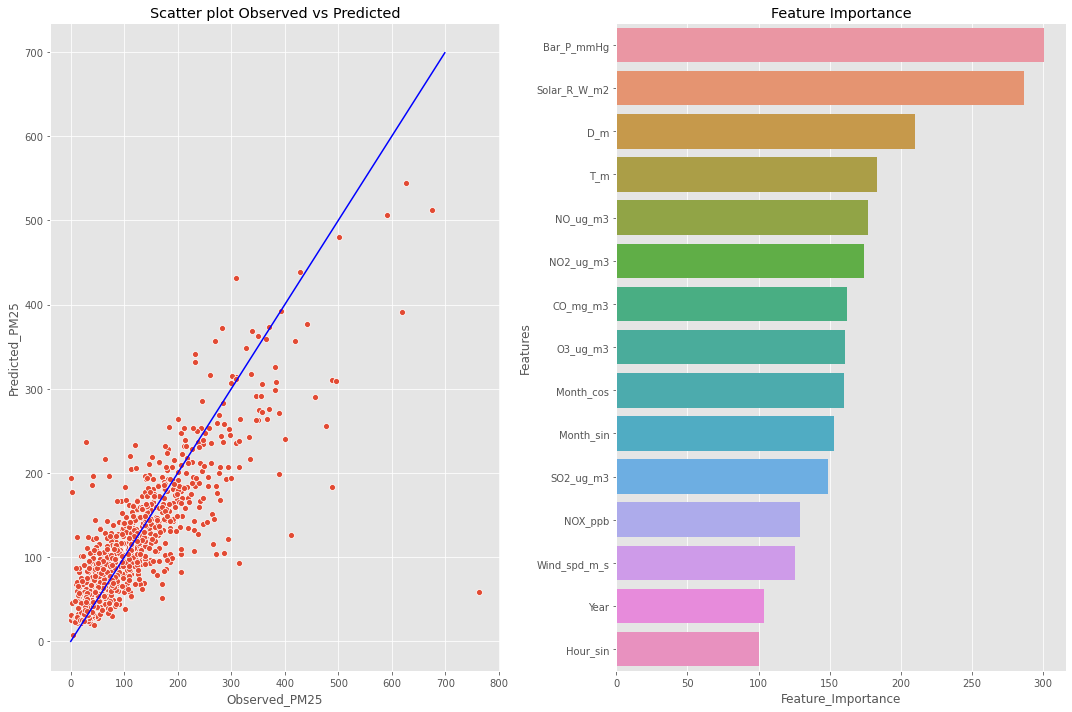

In [350]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = n_cols
mod = LGBMRegressor()
results = mod_eval(df1,start,end,mod,cols,impute=True, test_size = 0.042, 
                   predictions=50,lags=False,random=True,log_c=False)

This model yields an RMSE of 51
<br>Case2: Time based Split / No lag variables / Use original non-log features

Mean Absolute Error:  48.210395548257175 RMSE:  64.82513057998047
Time based predictions for all  1000  requested points


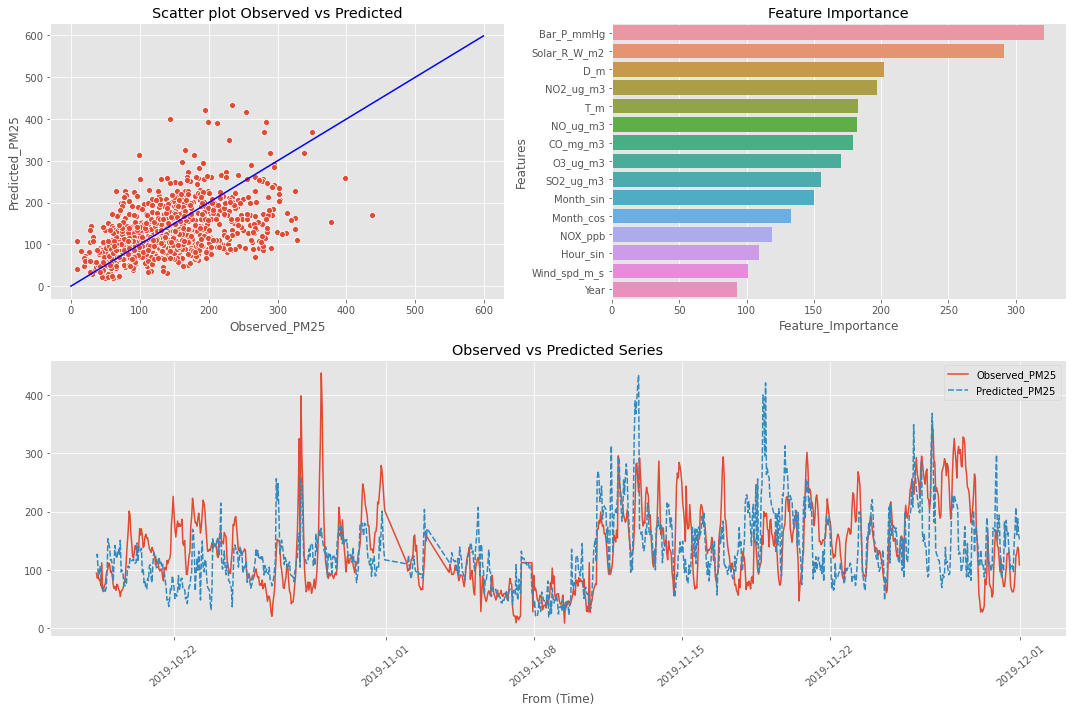

In [351]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = n_cols
mod = LGBMRegressor()
results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=1000,
                   lags=False,random=False,log_c=False)

This model with time based split has a worse RMSE of ~65 compared to the previous case based on random splitting.
The RMSE comparison is not a like for like comparison between cases 1 and 2 as the test set is randomly created in case 1 whereas it will be fixed based on the specified time window in Case 2.

<br> Case3: Random Split / 3 lag variables / Use original non-log features

Mean Absolute Error:  13.845208080979667 RMSE:  26.072706352394082
Random split predictions for all  1004  requested points


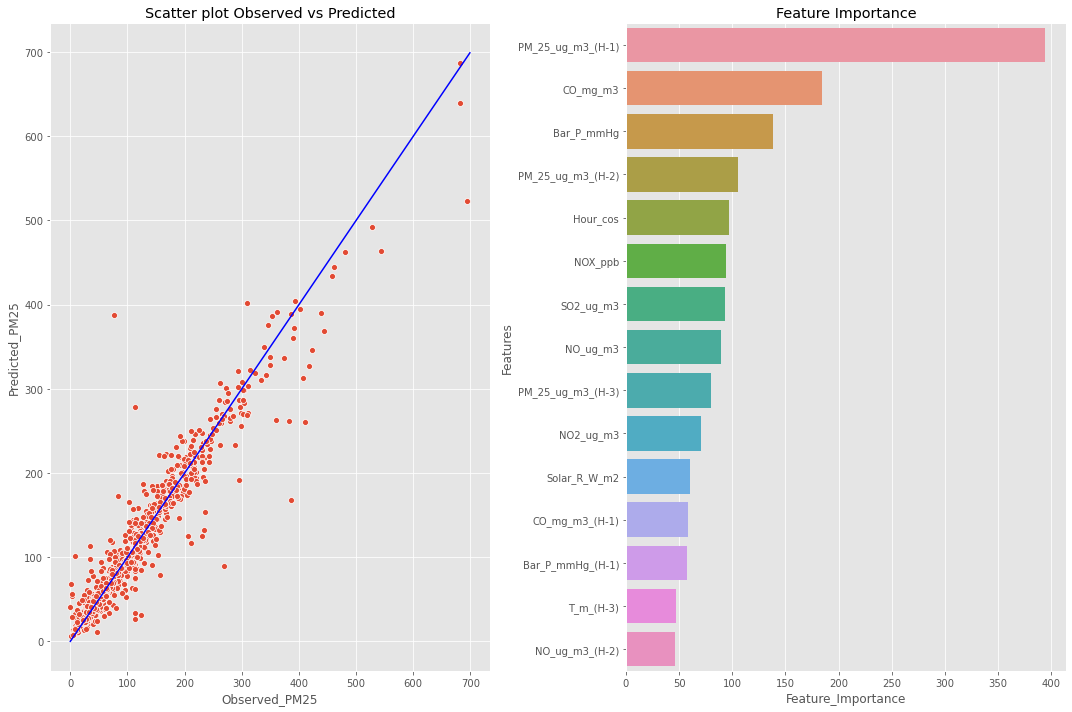

In [352]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = n_cols
mod = LGBMRegressor()
results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=1000,
                   test_size=0.042,lags=True,random=True,periods=3,log_c=False)

This shows an improved performance compared to a random split without lag variables. The (H-1) value for PM 2.5 is the most important feature in this case.
<br> Case4: Time based Split / 3 lag variables / Use original non-log features

Mean Absolute Error:  16.55568752373418 RMSE:  24.70393478131587
Time based predictions for all  1000  requested points


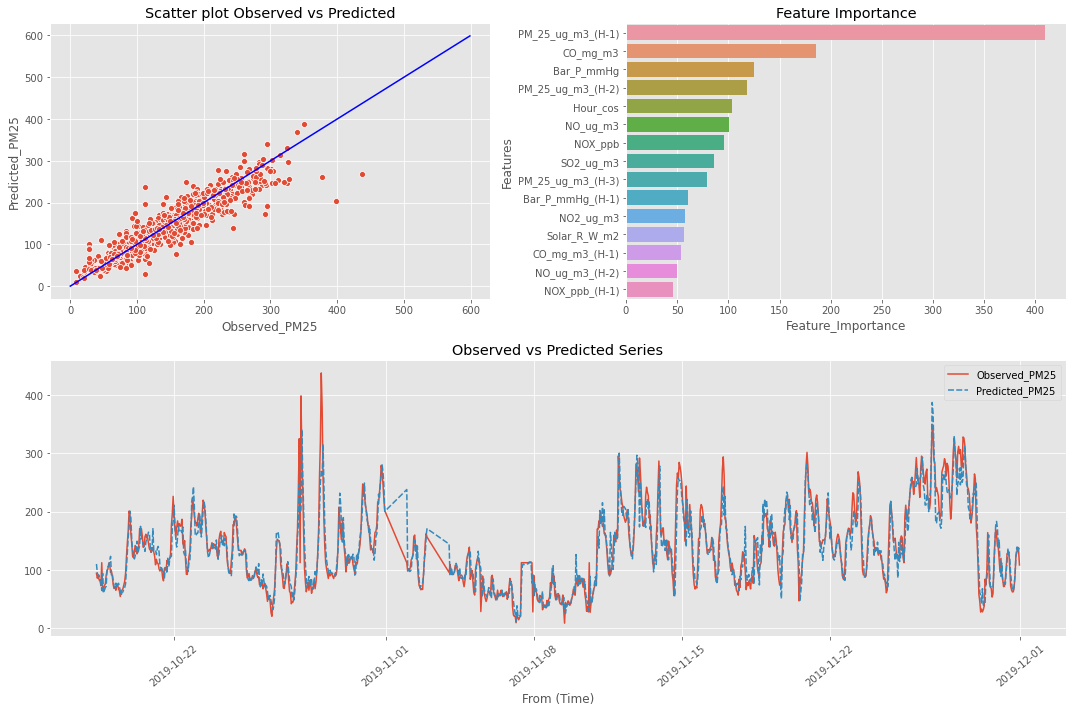

In [353]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
mod = LGBMRegressor()
cols = n_cols
results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=1000,
                   lags=True,random=False,periods=3,log_c=False)

The RMSE values are similar across cases 3 and 4 which shows that lagging features produce better results compared
to datasets without these features.
Again, the RMSE although similar between cases 3 and 4, may not be a like for like comparison as the test set is randomly split for Case 3 and remains fixed by the time window specified for Case 4.

We can next check the resampled (1H) dataset (df1_1H) replicating conditions in cases 1-4.

Case5. Random Split / No lag variables / Use original non-log features

Mean Absolute Error:  28.46115902065263 RMSE:  43.877839902558264
Random split predictions for all  1073  requested points


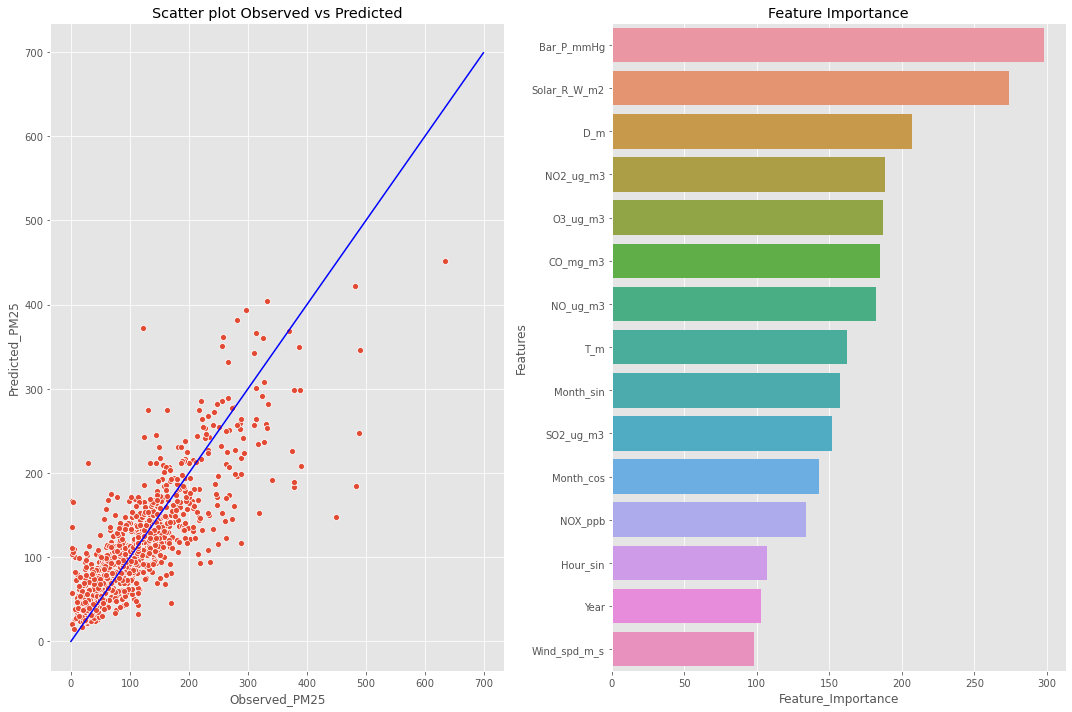

In [354]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
mod = LGBMRegressor()
cols = n_cols
results = mod_eval(df1_1H,start,end,mod,cols,impute=True, test_size = 0.042, 
                   predictions=50,lags=False,random=True,log_c=False)

The RMSE has slightly improved compared to Case1. As was seen before, there were more null features due to resmapling and had been imputed with the mean

Case6. Time based Split / No lag variables / Use original non-log features

Mean Absolute Error:  47.017033258918715 RMSE:  64.69684319265477
Time based predictions for all  1000  requested points


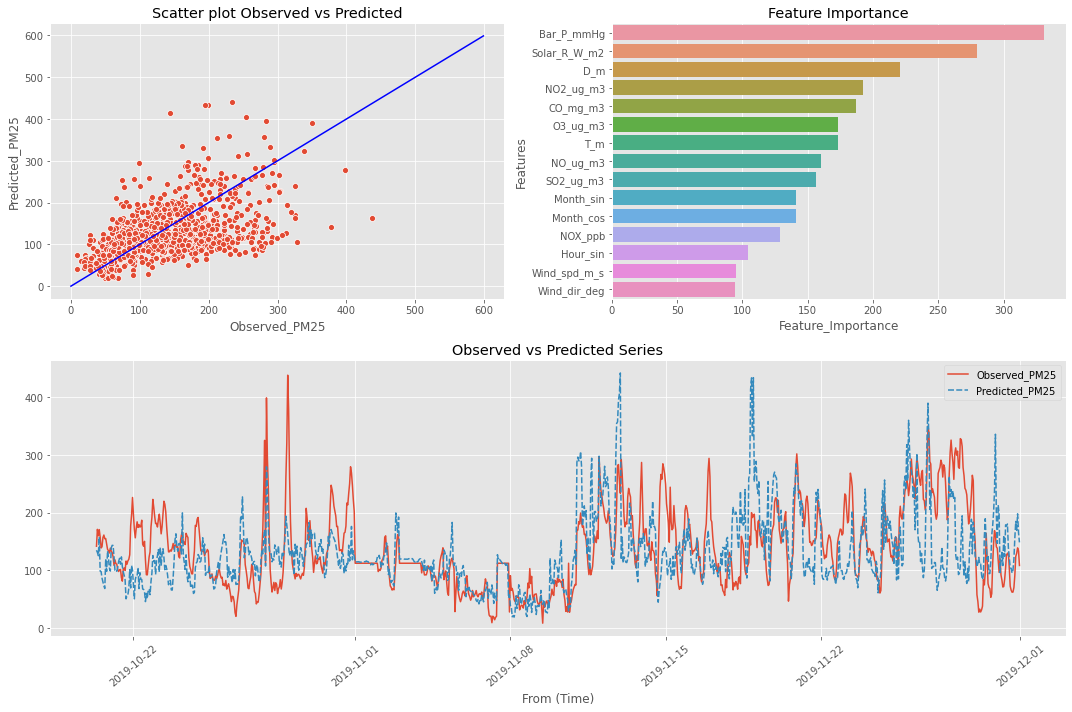

In [355]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = n_cols
mod = LGBMRegressor()
results = mod_eval(df1_1H,start,end,mod,cols,impute=True,predictions=1000,
                   lags=False,random=False,log_c=False)

The RMSE here is similar to case 2. The effect of resampling does not seem to affect this case.

Case7: Random Split / 3 lag variables / Use original non-log features

Mean Absolute Error:  12.88274095844909 RMSE:  24.82219422023312
Random split predictions for all  1073  requested points


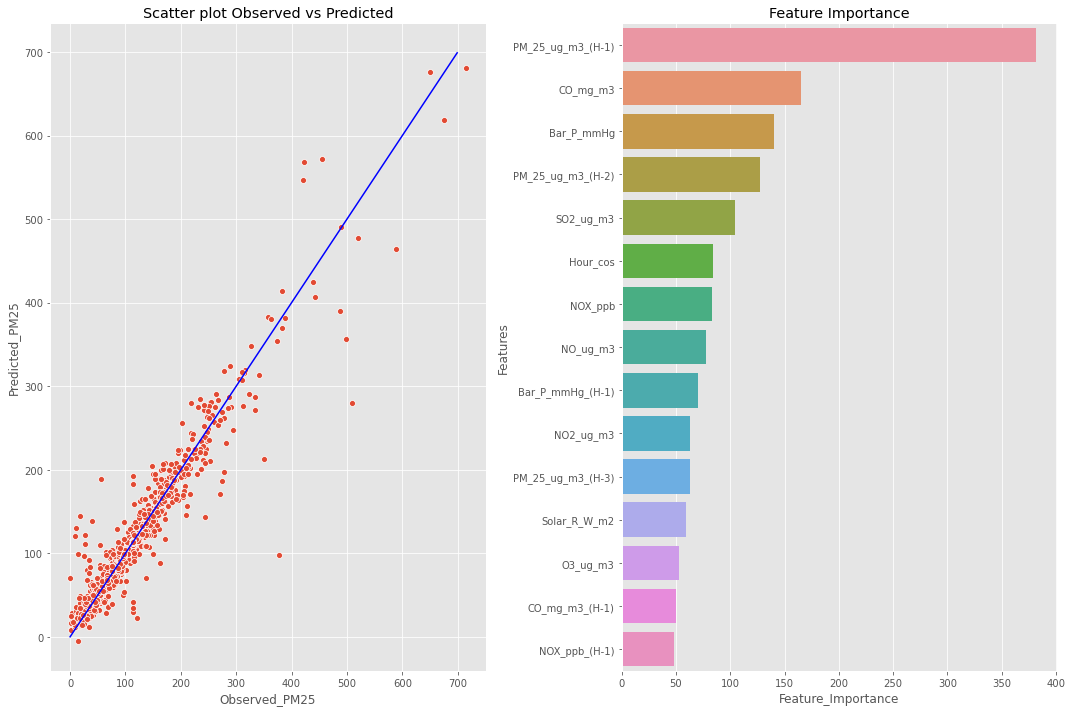

In [356]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = n_cols
mod = LGBMRegressor()
results = mod_eval(df1_1H,start,end,mod,cols,impute=True,predictions=1000,
                   test_size=0.042,lags=True,random=True,periods=3,log_c=False)

The RMSE is similar to Case3, thus no noticeable effect of resampling.

Case8: Time based Split / 3 lag variables / Use original non-log features

Mean Absolute Error:  16.057881081990455 RMSE:  24.404654558904483
Time based predictions for all  1000  requested points


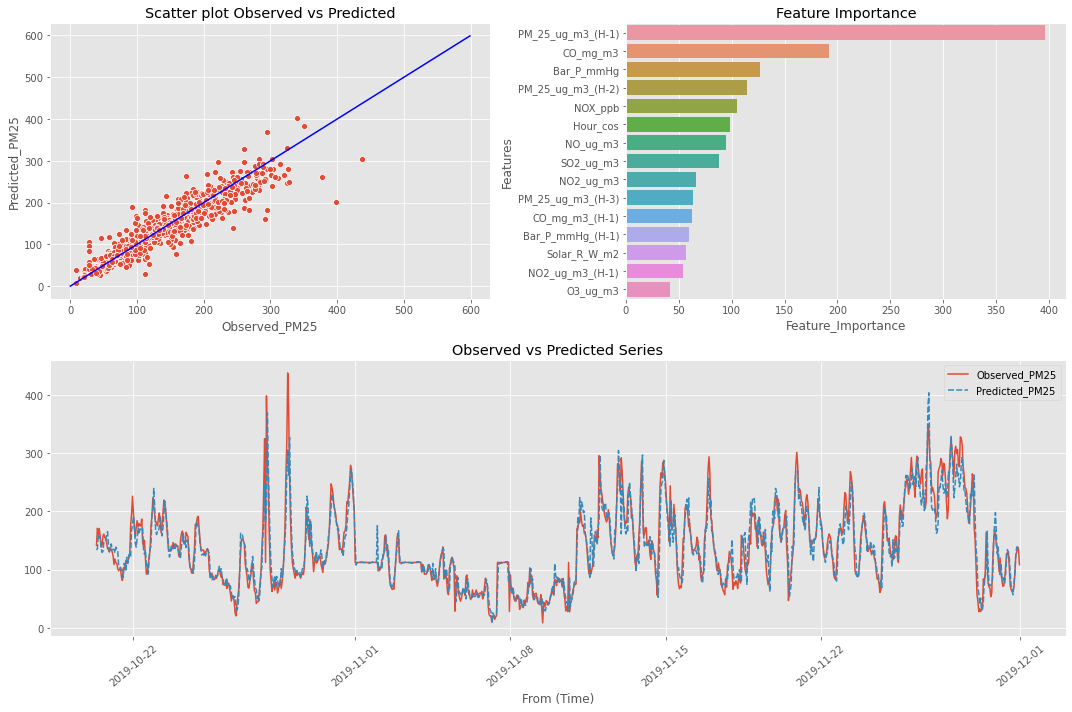

In [357]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = n_cols
mod = LGBMRegressor()
results = mod_eval(df1_1H,start,end,mod,cols,impute=True,predictions=1000,
                   lags=True,random=False,periods=3,log_c=False)

Again, the RMSE is similar to case 4. Thus overall, resampling does not seem to show any changes in the results except for Case 1 where there was an improvement of 10%. A random split however is not a realistic way to deal with this dataset.

Next, we can check walk forward validation for a random split versus a time based split. We will use three lagging features for both the datasets.

Case9: Random split / 3 lagging features / 300 predictions / Original non-log features

Train size:  23585 Test size:  301
Total data:  23886 Initial training data:  23585
Fitted 10 / 301 th model
Fitted 20 / 301 th model
Fitted 30 / 301 th model
Fitted 40 / 301 th model
Fitted 50 / 301 th model
Fitted 60 / 301 th model
Fitted 70 / 301 th model
Fitted 80 / 301 th model
Fitted 90 / 301 th model
Fitted 100 / 301 th model
Fitted 110 / 301 th model
Fitted 120 / 301 th model
Fitted 130 / 301 th model
Fitted 140 / 301 th model
Fitted 150 / 301 th model
Fitted 160 / 301 th model
Fitted 170 / 301 th model
Fitted 180 / 301 th model
Fitted 190 / 301 th model
Fitted 200 / 301 th model
Fitted 210 / 301 th model
Fitted 220 / 301 th model
Fitted 230 / 301 th model
Fitted 240 / 301 th model
Fitted 250 / 301 th model
Fitted 260 / 301 th model
Fitted 270 / 301 th model
Fitted 280 / 301 th model
Fitted 290 / 301 th model
Fitted 300 / 301 th model
Random split predictions for all  301  requested points
Overall Root Mean Square Error:  26.14139550887337 Overall Mean Absolute Error:  14.48038

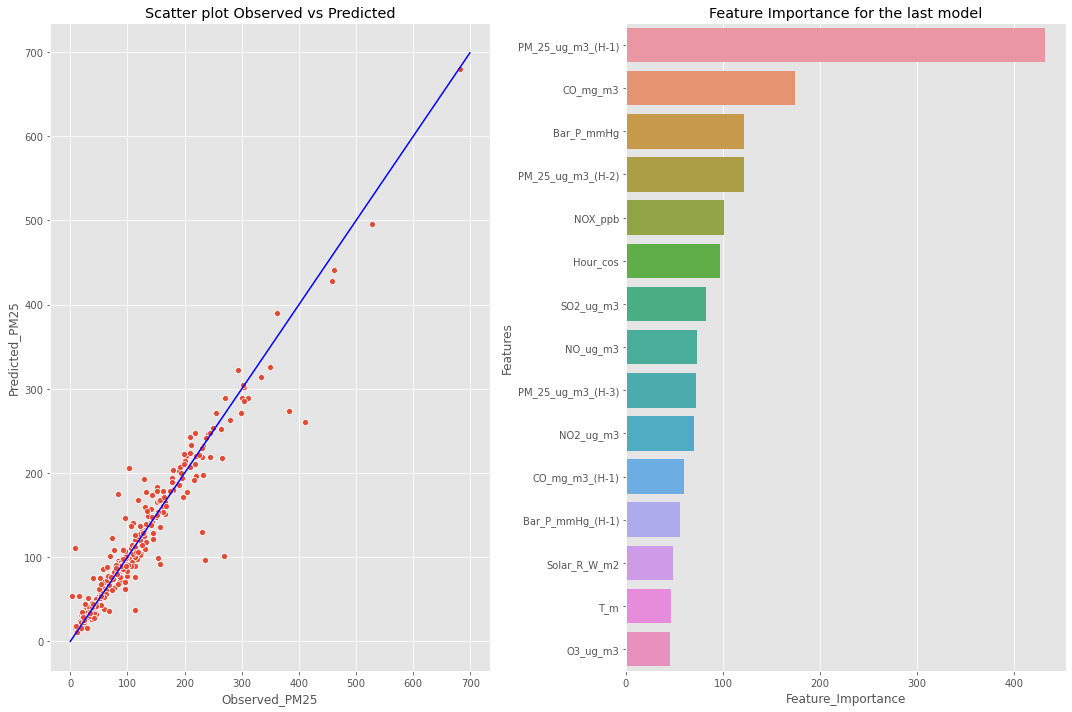

In [359]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = n_cols
mod = LGBMRegressor()
results = walk_forward(df1,start,end,mod,cols,impute=True,periods=3,log_c=False,
                       predictions=300,test_size=0.0126,random=True)

The RMSE for walk forward validation with a random split shows a similar performance compared to Case 3 where a single model was used to predict all the test dataset.

Case10: Time based split / 3 lagging features / 300 predictions / Original non-log features

Total data:  23886 Initial training data:  23586
Fitted 10 / 300 th model
Fitted 20 / 300 th model
Fitted 30 / 300 th model
Fitted 40 / 300 th model
Fitted 50 / 300 th model
Fitted 60 / 300 th model
Fitted 70 / 300 th model
Fitted 80 / 300 th model
Fitted 90 / 300 th model
Fitted 100 / 300 th model
Fitted 110 / 300 th model
Fitted 120 / 300 th model
Fitted 130 / 300 th model
Fitted 140 / 300 th model
Fitted 150 / 300 th model
Fitted 160 / 300 th model
Fitted 170 / 300 th model
Fitted 180 / 300 th model
Fitted 190 / 300 th model
Fitted 200 / 300 th model
Fitted 210 / 300 th model
Fitted 220 / 300 th model
Fitted 230 / 300 th model
Fitted 240 / 300 th model
Fitted 250 / 300 th model
Fitted 260 / 300 th model
Fitted 270 / 300 th model
Fitted 280 / 300 th model
Fitted 290 / 300 th model
Fitted 300 / 300 th model
Time based predictions for all  300  requested points
Overall Root Mean Square Error:  22.757746623994827 Overall Mean Absolute Error:  16.680524908357675


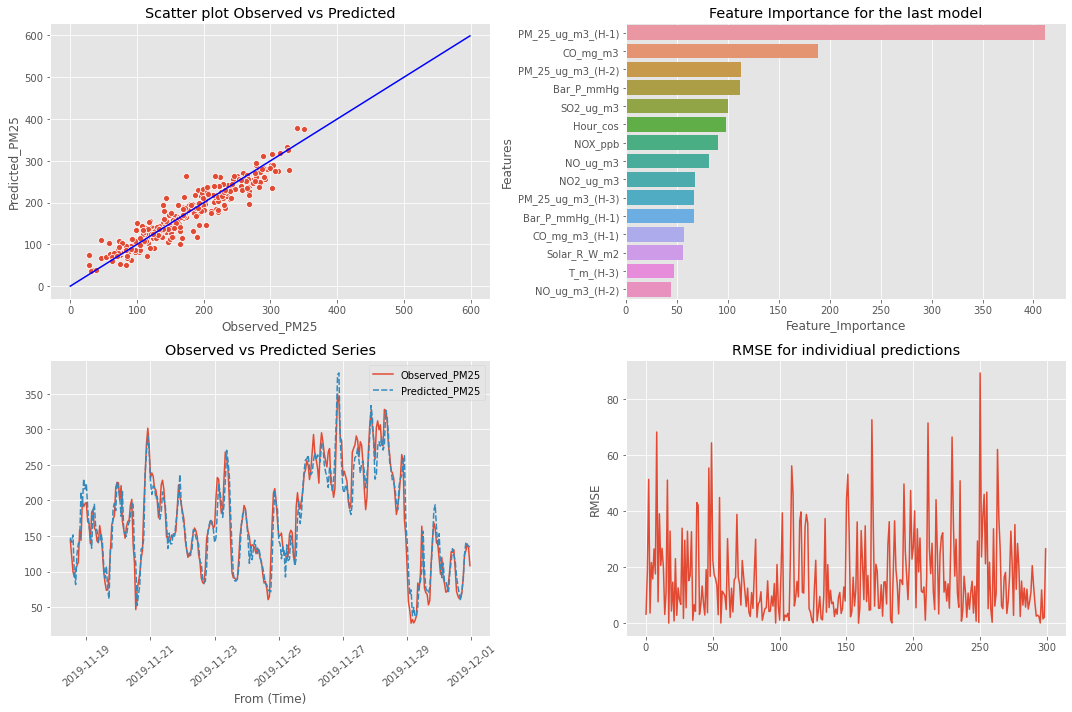

In [360]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = n_cols
mod = LGBMRegressor()
results = walk_forward(df1,start,end,mod,cols,impute=True,periods=3,log_c=False,
                       predictions=300,test_size=0.0126,random=False)

Case 10 shows an improvement over Case 4 where a single model predicted for all the test data.

We can similarly test walk forward validation on the resampled dataset.

Case11: Random split / 3 lagging features / 300 predictions / Original non-log features

Train size:  25211 Test size:  322
Total data:  25533 Initial training data:  25211
Fitted 10 / 322 th model
Fitted 20 / 322 th model
Fitted 30 / 322 th model
Fitted 40 / 322 th model
Fitted 50 / 322 th model
Fitted 60 / 322 th model
Fitted 70 / 322 th model
Fitted 80 / 322 th model
Fitted 90 / 322 th model
Fitted 100 / 322 th model
Fitted 110 / 322 th model
Fitted 120 / 322 th model
Fitted 130 / 322 th model
Fitted 140 / 322 th model
Fitted 150 / 322 th model
Fitted 160 / 322 th model
Fitted 170 / 322 th model
Fitted 180 / 322 th model
Fitted 190 / 322 th model
Fitted 200 / 322 th model
Fitted 210 / 322 th model
Fitted 220 / 322 th model
Fitted 230 / 322 th model
Fitted 240 / 322 th model
Fitted 250 / 322 th model
Fitted 260 / 322 th model
Fitted 270 / 322 th model
Fitted 280 / 322 th model
Fitted 290 / 322 th model
Fitted 300 / 322 th model
Fitted 310 / 322 th model
Fitted 320 / 322 th model
Random split predictions for all  322  requested points
Overall Root Mean Square Error:  27.4

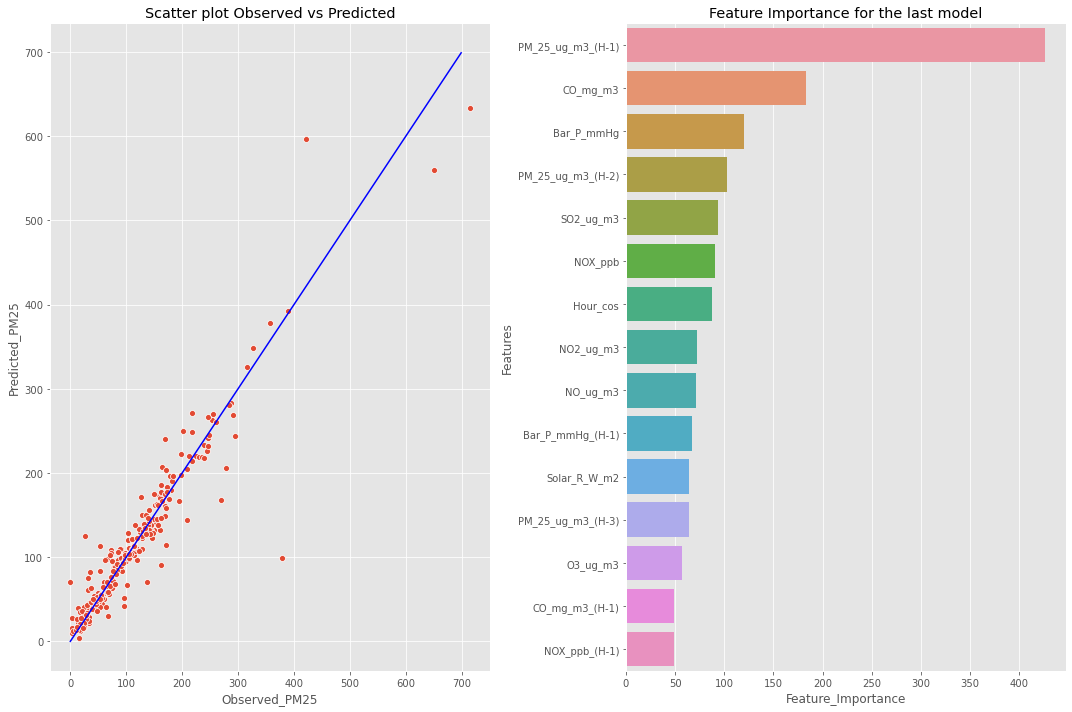

In [361]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = n_cols
mod = LGBMRegressor()
results = walk_forward(df1_1H,start,end,mod,cols,impute=True,periods=3,
                       log_c=False,predictions=300,test_size=0.0126,random=True)

The RMSE is similar to Case 9 again indicating that resampling is not changing the results by a lot.

Case12: Time based split / 3 lagging features / 300 predictions / Original non-log features

Total data:  25533 Initial training data:  25233
Fitted 10 / 300 th model
Fitted 20 / 300 th model
Fitted 30 / 300 th model
Fitted 40 / 300 th model
Fitted 50 / 300 th model
Fitted 60 / 300 th model
Fitted 70 / 300 th model
Fitted 80 / 300 th model
Fitted 90 / 300 th model
Fitted 100 / 300 th model
Fitted 110 / 300 th model
Fitted 120 / 300 th model
Fitted 130 / 300 th model
Fitted 140 / 300 th model
Fitted 150 / 300 th model
Fitted 160 / 300 th model
Fitted 170 / 300 th model
Fitted 180 / 300 th model
Fitted 190 / 300 th model
Fitted 200 / 300 th model
Fitted 210 / 300 th model
Fitted 220 / 300 th model
Fitted 230 / 300 th model
Fitted 240 / 300 th model
Fitted 250 / 300 th model
Fitted 260 / 300 th model
Fitted 270 / 300 th model
Fitted 280 / 300 th model
Fitted 290 / 300 th model
Fitted 300 / 300 th model
Time based predictions for all  300  requested points
Overall Root Mean Square Error:  22.845634857599332 Overall Mean Absolute Error:  17.027972498508188


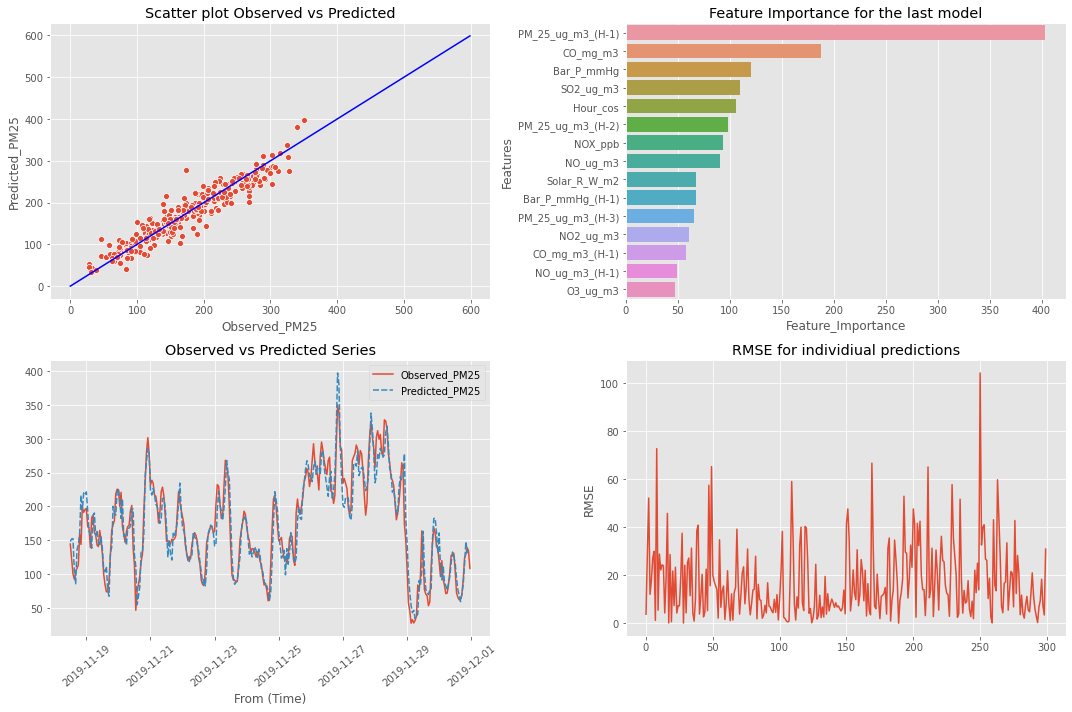

In [362]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = n_cols
mod = LGBMRegressor()
results = walk_forward(df1_1H,start,end,mod,cols,impute=True,periods=3,
                       log_c=False,predictions=300,test_size=0.0126,random=False)

Again results are similar to Case 10 for the resampled dataset

To summarize the above experiments for Case 1-12,

1. Random split without adding lag features showed a better RMSE performance compared to a time based split
2. Adding lagging variables improved results for both random and time based split models. In these cases, the performances were similar between splitting randomly vs based on time.
3. Walk forward validation produced the best RMSE for a time based split and a worse result for a random split. Doing a walk forward validation on a random split is not an ideal way to test the model but was just checked to compare with the time based studies.
4. Using an hourly resampled dataset (to remove discontinuity) in the original dataset did not show any increase or decrease in performance compared to using the original dataset.

For all these studies, a Light Gradient Boost Regressor was used due to its speed. No hyper-parameters were tuned nor were any features dropped to check for performance improvements.

The next step in this process is to test multiple models and tune them for improving the RMSE performance.
<br> From this point forward, a time based split will be used.

1. Linear Regression / Ridge / Lasso
2. Decision Tree Classifier
3. Random Forest
4. Gradient Boosting
5. Light Gradient Boosting
6. Cat Boosting
7. XG Boosting

In [125]:
df1.columns

Index(['PM_25_ug_m3', 'SO2_ug_m3', 'O3_ug_m3', 'CO_mg_m3', 'NOX_ppb',
       'NO2_ug_m3', 'NO_ug_m3', 'Wind_spd_m_s', 'Wind_dir_deg', 'Solar_R_W_m2',
       'Bar_P_mmHg', 'T_m', 'D_m', 'RH_NOAA_augroch', 'PM_25_ug_m3_log',
       'SO2_ug_m3_log', 'O3_ug_m3_log', 'CO_mg_m3_log', 'NOX_ppb_log',
       'NO2_ug_m3_log', 'NO_ug_m3_log', 'Wind_spd_m_s_log', 'Wind_dir_deg_log',
       'Solar_R_W_m2_log', 'T_m_log', 'D_m_log', 'Year', 'Month_No',
       'Day_of_Week', 'Hour', 'Day', 'Month', 'Y/M', 'Month_sin', 'Month_cos',
       'Day_of_Week_sin', 'Day_of_Week_cos', 'Hour_sin', 'Hour_cos',
       'Wind_dir_sin', 'Wind_dir_cos'],
      dtype='object')

We can start with using a Random Forest Regressor.
Initially, only PM_25_ug_m3 and its lagging features can be used to test the RMSE results. Post that features can be added to check for improvement
For tuning, we will follow an approach of training one model and testing it on a test set.
<br>Ex. Train 2017-Nov 2019. Test Dec 2019

Mean Absolute Error:  19.33176515634133 RMSE:  26.25040049224322
Time based predictions for all  400  requested points


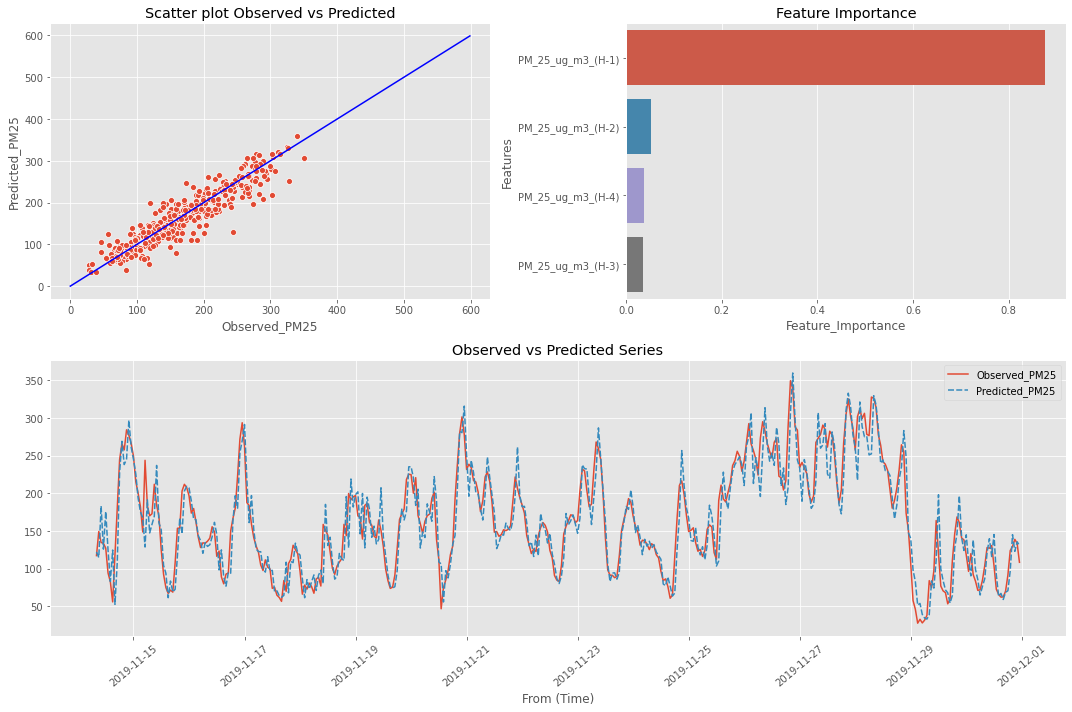

In [364]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3']
mod = RandomForestRegressor()
results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=400,
                   lags=True,random=False,periods=4,log_c=False)

A random forest model without any tuning and only considering PM_25_ug_m3 and its lagging variables results in an RMSE of 26. We can next varying the number of lagging variables to see changes in RMSE performance before tuning hyper-parameters or adding new features such as weather, time and other pollutant variables

Calculating for  1  periods
Mean Absolute Error:  24.463408351506246 RMSE:  33.07104088114639
Time based predictions for all  400  requested points
Calculating for  2  periods
Mean Absolute Error:  20.45556431525471 RMSE:  27.34294643586318
Time based predictions for all  400  requested points
Calculating for  3  periods
Mean Absolute Error:  19.634163235395228 RMSE:  26.639690620785608
Time based predictions for all  400  requested points
Calculating for  4  periods
Mean Absolute Error:  19.16115593078372 RMSE:  25.981826005118645
Time based predictions for all  400  requested points
Calculating for  5  periods
Mean Absolute Error:  19.505235777700864 RMSE:  26.195137287222504
Time based predictions for all  400  requested points
Calculating for  6  periods
Mean Absolute Error:  19.17654385760107 RMSE:  25.61028177558666
Time based predictions for all  400  requested points
Calculating for  7  periods
Mean Absolute Error:  18.831211765772835 RMSE:  25.39318646947297
Time based predict

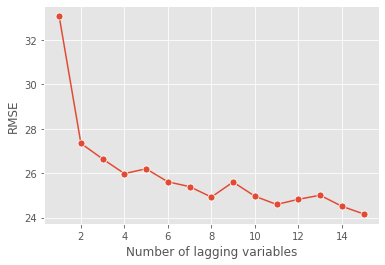

In [365]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3']
mod = RandomForestRegressor()
r_lags = []
rmse = []
l = []
#Lagging variables from 1 through 15
for a in range(1,16):
    #periods=a
    print('Calculating for ',a, ' periods')
    results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=400,lags=True,
                       random=False,periods=a,log_c=False,plots=False)
    r_lags.append(results)
    rmse.append(np.sqrt(mse(results['Observed_PM25'],results['Predicted_PM25'])))
    l.append(a)
ax = sns.lineplot(l,rmse,marker='o',markersize=7)
ax.set(xlabel='Number of lagging variables',ylabel='RMSE');

The RMSE does not significantly drop beyond 3-4 lagging variables.
<br> Next, lets try adding cyclical time features to check model improvements

Calculating for  1  periods
Mean Absolute Error:  17.337148580490872 RMSE:  24.054000828273704
Time based predictions for all  400  requested points
Calculating for  2  periods
Mean Absolute Error:  17.56885207262597 RMSE:  24.082863310938137
Time based predictions for all  400  requested points
Calculating for  3  periods
Mean Absolute Error:  17.36992203194361 RMSE:  23.76853861289838
Time based predictions for all  400  requested points
Calculating for  4  periods
Mean Absolute Error:  17.424080475991573 RMSE:  24.00854057870844
Time based predictions for all  400  requested points
Calculating for  5  periods
Mean Absolute Error:  17.077001743578577 RMSE:  23.383828306161238
Time based predictions for all  400  requested points
Calculating for  6  periods
Mean Absolute Error:  17.034127655522575 RMSE:  23.484451880598755
Time based predictions for all  400  requested points
Calculating for  7  periods
Mean Absolute Error:  16.89109546363133 RMSE:  23.502833342272364
Time based predi

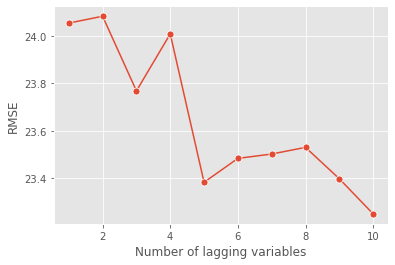

In [366]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
        'Day_of_Week_cos','Hour_sin','Hour_cos',]
mod = RandomForestRegressor()
r_lags = []
rmse = []
l = []
#Lagging variables from 1 through 10
for a in range(1,11):
    #periods=a
    print('Calculating for ',a, ' periods')
    results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=400,lags=True,
                       random=False,periods=a,log_c=False,plots=False)
    r_lags.append(results)
    rmse.append(np.sqrt(mse(results['Observed_PM25'],results['Predicted_PM25'])))
    l.append(a)
ax = sns.lineplot(l,rmse,marker='o',markersize=7)
ax.set(xlabel='Number of lagging variables',ylabel='RMSE');

As can be seen above, there is a slight drop in RMSE on adding the time features, however the values don't change significantly with increasing the number of lagging variables. Having a single lagging variable is enough when using these parameters. The plots for that configuration as below.
As was seen before, the first lagging variable has the highest feature importance in the model

Mean Absolute Error:  17.48095839338193 RMSE:  23.945138017568752
Time based predictions for all  400  requested points


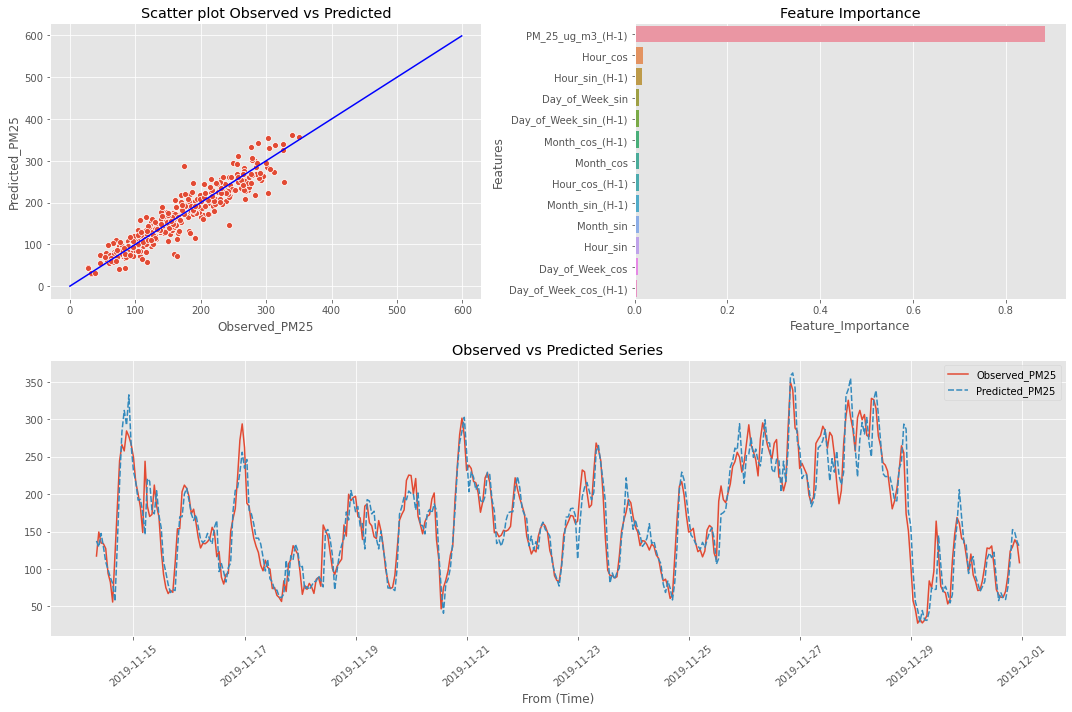

In [379]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
        'Day_of_Week_cos','Hour_sin','Hour_cos',]
mod = RandomForestRegressor()

results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=400,lags=True,
                   random=False,periods=1,log_c=False,plots=True)

Next we can try adding weather data: (temperature and wind conditions)

Calculating for  1  periods
Mean Absolute Error:  18.65987179603654 RMSE:  24.78750339588871
Time based predictions for all  400  requested points
Calculating for  2  periods
Mean Absolute Error:  17.009809608227204 RMSE:  23.42762539375174
Time based predictions for all  400  requested points
Calculating for  3  periods
Mean Absolute Error:  16.969959847492042 RMSE:  23.298053706119976
Time based predictions for all  400  requested points
Calculating for  4  periods
Mean Absolute Error:  16.72460810658745 RMSE:  23.226114422449346
Time based predictions for all  400  requested points
Calculating for  5  periods
Mean Absolute Error:  16.927423934549356 RMSE:  23.287101454961366
Time based predictions for all  400  requested points
Calculating for  6  periods
Mean Absolute Error:  17.0445669352386 RMSE:  24.201009694587317
Time based predictions for all  400  requested points
Calculating for  7  periods
Mean Absolute Error:  17.141323244115473 RMSE:  24.46690718528645
Time based predict

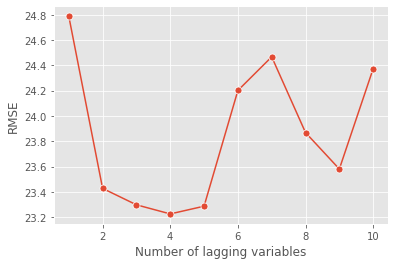

In [368]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
        'Day_of_Week_cos','Hour_sin','Hour_cos','T_m','D_m',
        'Wind_spd_m_s','Wind_dir_sin','Wind_dir_cos']
mod = RandomForestRegressor()
r_lags = []
rmse = []
l = []
#Lagging variables from 1 through 10
for a in range(1,11):
    #periods=a
    print('Calculating for ',a, ' periods')
    results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=400,lags=True,
                       random=False,periods=a,log_c=False,plots=False)
    r_lags.append(results)
    rmse.append(np.sqrt(mse(results['Observed_PM25'],results['Predicted_PM25'])))
    l.append(a)
ax = sns.lineplot(l,rmse,marker='o',markersize=7)
ax.set(xlabel='Number of lagging variables',ylabel='RMSE');

No significant change is seen in RMSE on adding weather features. These features can be tested later with hyperparameter tuning to see if any more improvements can be made. Lets check the effect of adding a some pollutant features to the model if that improves the RMSE. We can stop at 4 lagging variables due to no significant improvement. Based on the heat map below, we can add CO and NOX to the model seening higher correlation.

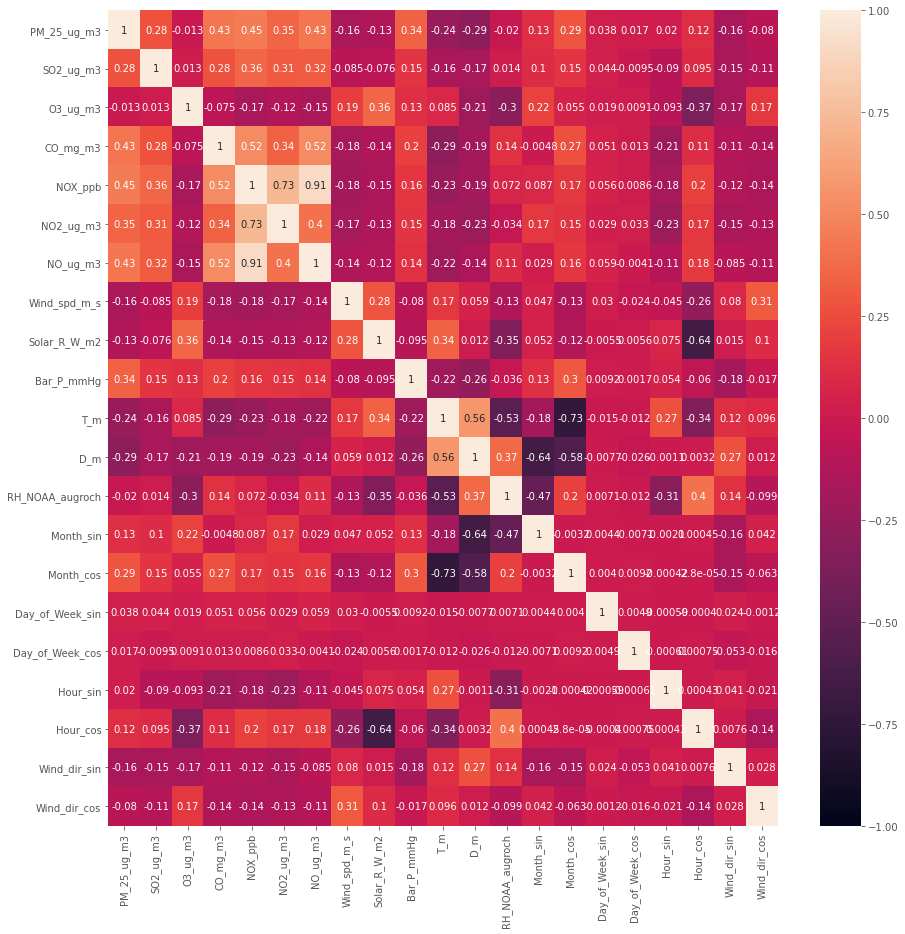

In [369]:
df1.columns
plt.figure(figsize=[15,15])
sns.heatmap(df1[['PM_25_ug_m3', 'SO2_ug_m3', 'O3_ug_m3', 'CO_mg_m3', 'NOX_ppb',
       'NO2_ug_m3', 'NO_ug_m3', 'Wind_spd_m_s', 'Solar_R_W_m2',
       'Bar_P_mmHg', 'T_m', 'D_m', 'RH_NOAA_augroch', 'Month_sin', 'Month_cos',
       'Day_of_Week_sin', 'Day_of_Week_cos', 'Hour_sin', 'Hour_cos',
       'Wind_dir_sin', 'Wind_dir_cos']].corr(),annot=True,vmin=-1,vmax=1)

Calculating for  1  periods
Mean Absolute Error:  21.791322111890366 RMSE:  29.573729155567666
Time based predictions for all  400  requested points
Calculating for  2  periods
Mean Absolute Error:  19.48032039467977 RMSE:  27.61881379456138
Time based predictions for all  400  requested points
Calculating for  3  periods
Mean Absolute Error:  19.142737812064507 RMSE:  26.58208161025809
Time based predictions for all  400  requested points
Calculating for  4  periods
Mean Absolute Error:  19.04944149543147 RMSE:  26.461724763203296
Time based predictions for all  400  requested points


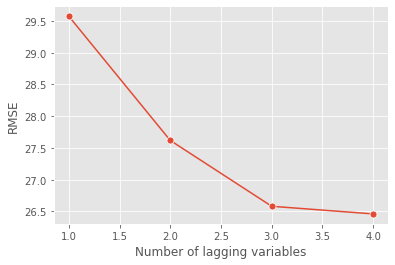

In [370]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
        'Day_of_Week_cos','Hour_sin','Hour_cos','T_m','D_m',
        'Wind_spd_m_s','Wind_dir_sin','Wind_dir_cos','NOX_ppb','CO_mg_m3']
mod = RandomForestRegressor()
r_lags = []
rmse = []
l = []
#Lagging variables from 1 through 4
for a in range(1,5):
    #periods=a
    print('Calculating for ',a, ' periods')
    results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=400,lags=True,
                       random=False,periods=a,log_c=False,plots=False)
    r_lags.append(results)
    rmse.append(np.sqrt(mse(results['Observed_PM25'],results['Predicted_PM25'])))
    l.append(a)
ax = sns.lineplot(l,rmse,marker='o',markersize=7)
ax.set(xlabel='Number of lagging variables',ylabel='RMSE');

Again, no further improvement is seen adding these features. So far, using one lagging variable for PM_25_ug_m3 and time features has been enough to reduce the RMSE.
Next lets try to tune the hyper-parameters.

Calculating for a max depth:  2
Mean Absolute Error:  30.625414129566124 RMSE:  37.77775691448419
Time based predictions for all  400  requested points
Calculating for a max depth:  5
Mean Absolute Error:  17.49234024238376 RMSE:  24.07438649132777
Time based predictions for all  400  requested points
Calculating for a max depth:  10
Mean Absolute Error:  16.610095449338658 RMSE:  23.054899566606604
Time based predictions for all  400  requested points
Calculating for a max depth:  30
Mean Absolute Error:  17.72958162454894 RMSE:  24.26936749759114
Time based predictions for all  400  requested points
Calculating for a max depth:  60
Mean Absolute Error:  17.621575054312785 RMSE:  24.081279983102625
Time based predictions for all  400  requested points
Calculating for a max depth:  100
Mean Absolute Error:  17.455715152610892 RMSE:  23.932250855772388
Time based predictions for all  400  requested points
Calculating for a max depth:  500
Mean Absolute Error:  17.457451660619693 RMSE:  

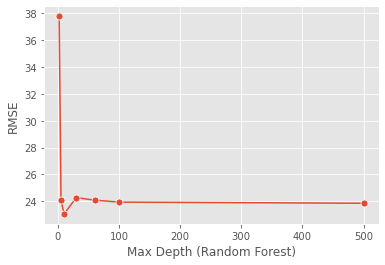

In [371]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
        'Day_of_Week_cos','Hour_sin','Hour_cos']
depth = [2,5,10,30,60,100,500]
rmse = []
#Lagging variables from 1 through 10
for a in depth:
    #periods=a
    print('Calculating for a max depth: ',a)
    mod = RandomForestRegressor(max_depth=a)
    results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=400,lags=True,
                       random=False,periods=2,log_c=False,plots=False)
    rmse.append(np.sqrt(mse(results['Observed_PM25'],results['Predicted_PM25'])))
ax = sns.lineplot(depth,rmse,marker='o',markersize=7)
ax.set(xlabel='Max Depth (Random Forest)',ylabel='RMSE');

Mean Absolute Error:  16.53139811367524 RMSE:  23.069938439531743
Time based predictions for all  400  requested points


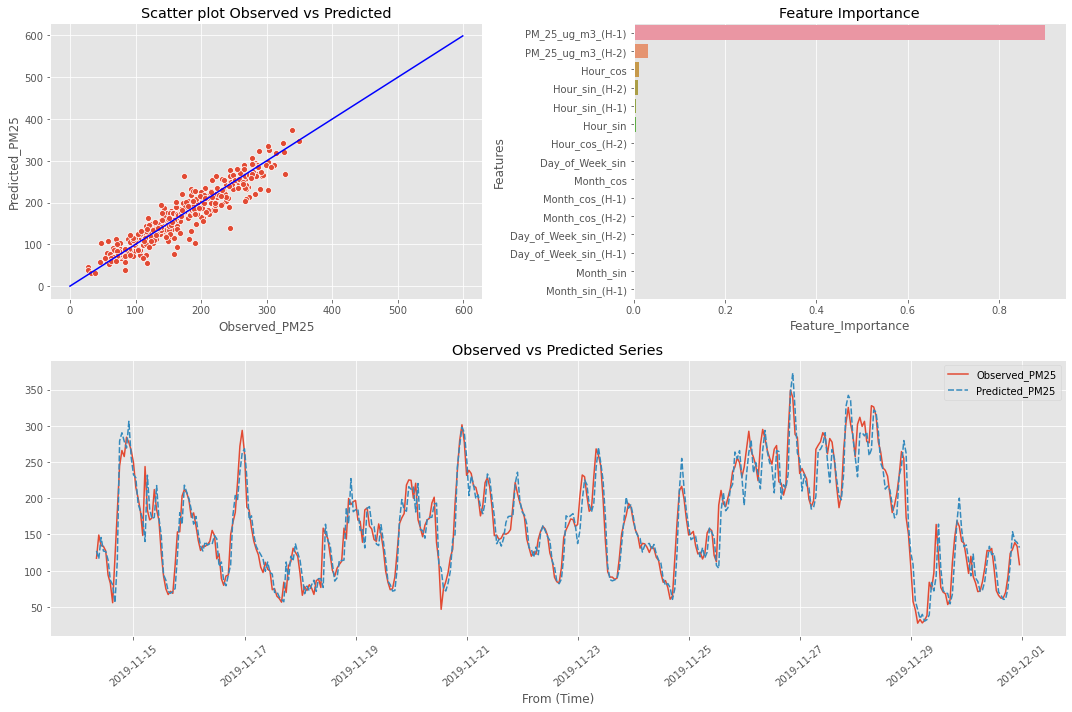

In [372]:
#Can use the below value for cv when using GridSearch without cross-validatoin
#cv=[(slice(None), slice(None))]
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
        'Day_of_Week_cos','Hour_sin','Hour_cos',]
mod = RandomForestRegressor(n_estimators=100,max_depth=10)
results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=400,lags=True,random=False,periods=2,log_c=False)

Reducing max depth to 10 leads to a very slight improvement in the RMSE. Lets consider the effects of varying estimators and lagging periods of 1-2.

Varying estimators, max_depth = 10, periods = 1

Random forest with  50  estimators
Mean Absolute Error:  16.91497867776301 RMSE:  23.23210920749488
Time based predictions for all  400  requested points
Random forest with  70  estimators
Mean Absolute Error:  16.94966453290016 RMSE:  23.34598322440505
Time based predictions for all  400  requested points
Random forest with  100  estimators
Mean Absolute Error:  16.808773085529143 RMSE:  23.17420025316778
Time based predictions for all  400  requested points
Random forest with  200  estimators
Mean Absolute Error:  16.839626434632343 RMSE:  23.237926583388703
Time based predictions for all  400  requested points
Random forest with  500  estimators
Mean Absolute Error:  16.778272736167853 RMSE:  23.10691107006412
Time based predictions for all  400  requested points


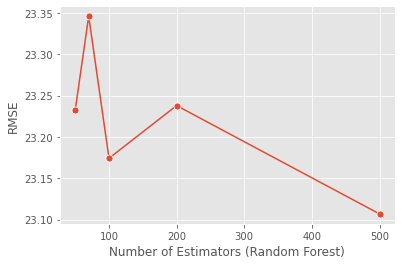

In [373]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
        'Day_of_Week_cos','Hour_sin','Hour_cos']
estimators = [50,70,100,200,500]
rmse = []
#Varying estimators with max depth 10
for a in estimators:
    print('Random forest with ',a,' estimators')
    mod = RandomForestRegressor(n_estimators=a,max_depth=10)
    results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=400,lags=True,
                       random=False,periods=1,log_c=False,plots=False)
    rmse.append(np.sqrt(mse(results['Observed_PM25'],results['Predicted_PM25'])))
ax = sns.lineplot(estimators,rmse,marker='o',markersize=7)
ax.set(xlabel='Number of Estimators (Random Forest)',ylabel='RMSE');

No significant changes with higher estimators, next consider increasing the lagging periods to 2.

Random forest with  50  estimators
Mean Absolute Error:  16.858364270582516 RMSE:  23.443582560596397
Time based predictions for all  400  requested points
Random forest with  70  estimators
Mean Absolute Error:  16.681995290227018 RMSE:  23.256760709290187
Time based predictions for all  400  requested points
Random forest with  100  estimators
Mean Absolute Error:  16.666199823943753 RMSE:  23.192838147331248
Time based predictions for all  400  requested points
Random forest with  200  estimators
Mean Absolute Error:  16.634209732830385 RMSE:  23.13389023397889
Time based predictions for all  400  requested points
Random forest with  500  estimators
Mean Absolute Error:  16.534726163819837 RMSE:  23.043808946389845
Time based predictions for all  400  requested points


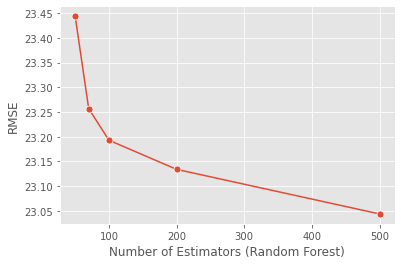

In [374]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
        'Day_of_Week_cos','Hour_sin','Hour_cos']
estimators = [50,70,100,200,500]
rmse = []
#Varying estimators with max depth 10
for a in estimators:
    print('Random forest with ',a,' estimators')
    mod = RandomForestRegressor(n_estimators=a,max_depth=10)
    results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=400,lags=True,
                       random=False,periods=2,log_c=False,plots=False)
    rmse.append(np.sqrt(mse(results['Observed_PM25'],results['Predicted_PM25'])))
ax = sns.lineplot(estimators,rmse,marker='o',markersize=7)
ax.set(xlabel='Number of Estimators (Random Forest)',ylabel='RMSE');

Thus so far, reducing max depth to 10 has reduced the RMSE slightly with no further reductions with higher estimators or more lagging periods.
The current random forest model has 100 estimators, max_depth of 10 and can choose periods = 1
Next, we can consider increasing the time horizon (i.e. varying the number of predictions of the model) to test its accuracy as the time window increases.

Random forest Model for  100  predictions
Mean Absolute Error:  19.05819872701098 RMSE:  26.355564193344904
Time based predictions for all  100  requested points
Random forest Model for  200  predictions
Mean Absolute Error:  17.196351943485745 RMSE:  24.196202388065252
Time based predictions for all  200  requested points
Random forest Model for  400  predictions
Mean Absolute Error:  16.942372795580333 RMSE:  23.37111937284279
Time based predictions for all  400  requested points
Random forest Model for  600  predictions
Mean Absolute Error:  16.062200027552652 RMSE:  23.680907500767677
Time based predictions for all  600  requested points
Random forest Model for  800  predictions
Mean Absolute Error:  17.211520164530057 RMSE:  28.621947589945336
Time based predictions for all  800  requested points
Random forest Model for  1000  predictions
Mean Absolute Error:  16.214056078614814 RMSE:  26.58865786961221
Time based predictions for all  1000  requested points
Random forest Model for

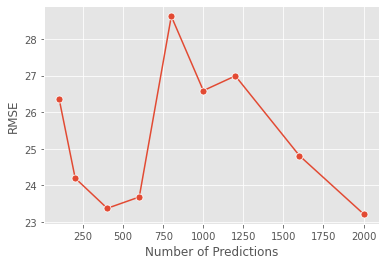

In [375]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
        'Day_of_Week_cos','Hour_sin','Hour_cos']
predictions = [100,200,400,600,800,1000,1200,1600,2000]
rmse = []
#Varying the number of model predictions
for a in predictions:
    print('Random forest Model for ',a,' predictions')
    mod = RandomForestRegressor(n_estimators=100,max_depth=10)
    results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=a,lags=True,
                       random=False,periods=1,log_c=False,plots=False)
    rmse.append(np.sqrt(mse(results['Observed_PM25'],results['Predicted_PM25'])))
ax = sns.lineplot(predictions,rmse,marker='o',markersize=7)
ax.set(xlabel='Number of Predictions',ylabel='RMSE');

Although the hyper-parameters are tuned, consider running the random-forest model without tuning to test accuracy on increasing the time window

Random forest Model for  100  predictions
Mean Absolute Error:  20.25266403705567 RMSE:  27.947362288451565
Time based predictions for all  100  requested points
Random forest Model for  200  predictions
Mean Absolute Error:  17.860761451440197 RMSE:  25.0364046908712
Time based predictions for all  200  requested points
Random forest Model for  400  predictions
Mean Absolute Error:  17.44680582963227 RMSE:  23.842841421426154
Time based predictions for all  400  requested points
Random forest Model for  600  predictions
Mean Absolute Error:  17.302741489858338 RMSE:  25.178239878993754
Time based predictions for all  600  requested points
Random forest Model for  800  predictions
Mean Absolute Error:  18.538502114158597 RMSE:  29.717525617254488
Time based predictions for all  800  requested points
Random forest Model for  1000  predictions
Mean Absolute Error:  17.80409246297061 RMSE:  28.003242578448802
Time based predictions for all  1000  requested points
Random forest Model for  

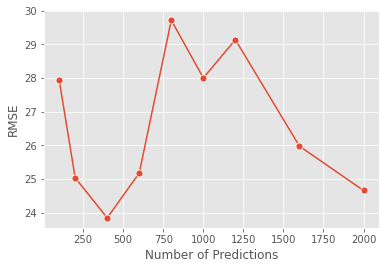

In [376]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
        'Day_of_Week_cos','Hour_sin','Hour_cos']
predictions = [100,200,400,600,800,1000,1200,1600,2000]
rmse = []
#Varying the number of model predictions
for a in predictions:
    print('Random forest Model for ',a,' predictions')
    mod = RandomForestRegressor()
    results = mod_eval(df1,start,end,mod,cols,impute=True,predictions=a,lags=True,
                       random=False,periods=1,log_c=False,plots=False)
    rmse.append(np.sqrt(mse(results['Observed_PM25'],results['Predicted_PM25'])))
ax = sns.lineplot(predictions,rmse,marker='o',markersize=7)
ax.set(xlabel='Number of Predictions',ylabel='RMSE');

The tuned random forest model does show a slight improvement over the untuned model.
Next lets try this model for the walk forward validation procedure which is a more realistic approach in using such a model to predict hourly particulate matter values.
We can try running with the above selected hyper-parameters as well as the default model to check results.

Total data:  23888 Initial training data:  23738
Fitted 20 / 150 th model
Fitted 40 / 150 th model
Fitted 60 / 150 th model
Fitted 80 / 150 th model
Fitted 100 / 150 th model
Fitted 120 / 150 th model
Fitted 140 / 150 th model
Time based predictions for all  150  requested points
Overall Root Mean Square Error:  25.932574177651748 Overall Mean Absolute Error:  18.81286275189929


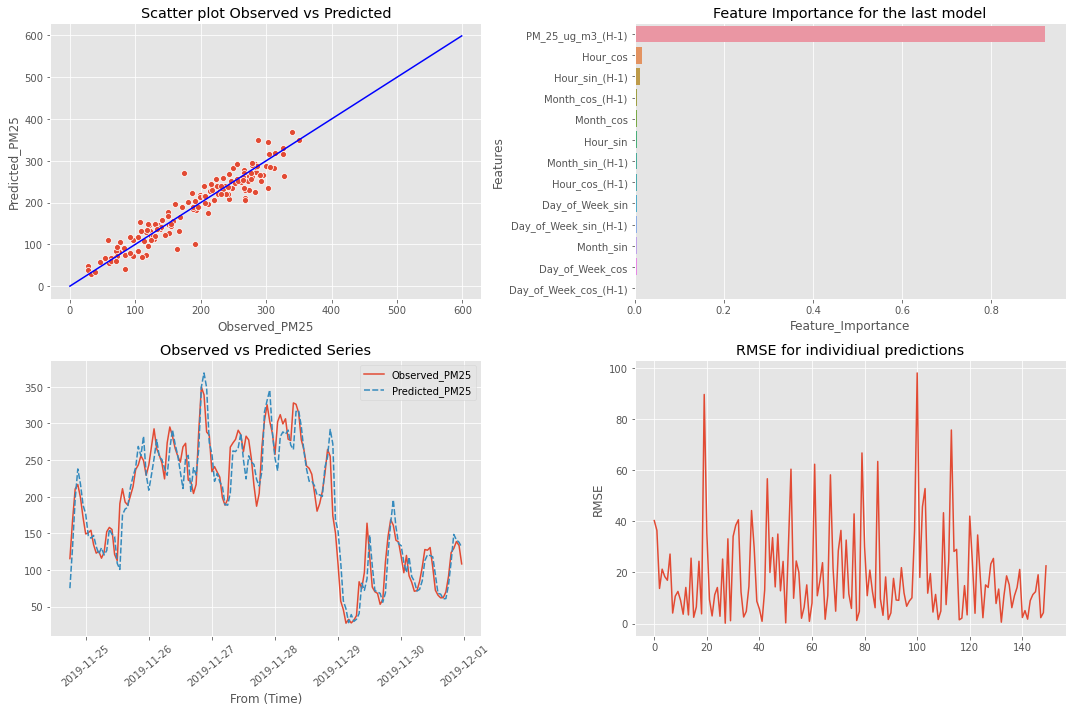

In [377]:
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
        'Day_of_Week_cos','Hour_sin','Hour_cos']
mod = RandomForestRegressor(n_estimators=100,max_depth=10)
results = walk_forward(df1,start,end,mod,cols,impute=True,periods=1,log_c=False,
                       predictions=150,test_size=0.0126,random=False)

Total data:  23888 Initial training data:  23738
Fitted 20 / 150 th model
Fitted 40 / 150 th model
Fitted 60 / 150 th model
Fitted 80 / 150 th model
Fitted 100 / 150 th model
Fitted 120 / 150 th model
Fitted 140 / 150 th model
Time based predictions for all  150  requested points
Overall Root Mean Square Error:  25.330539209843945 Overall Mean Absolute Error:  18.794408727769436


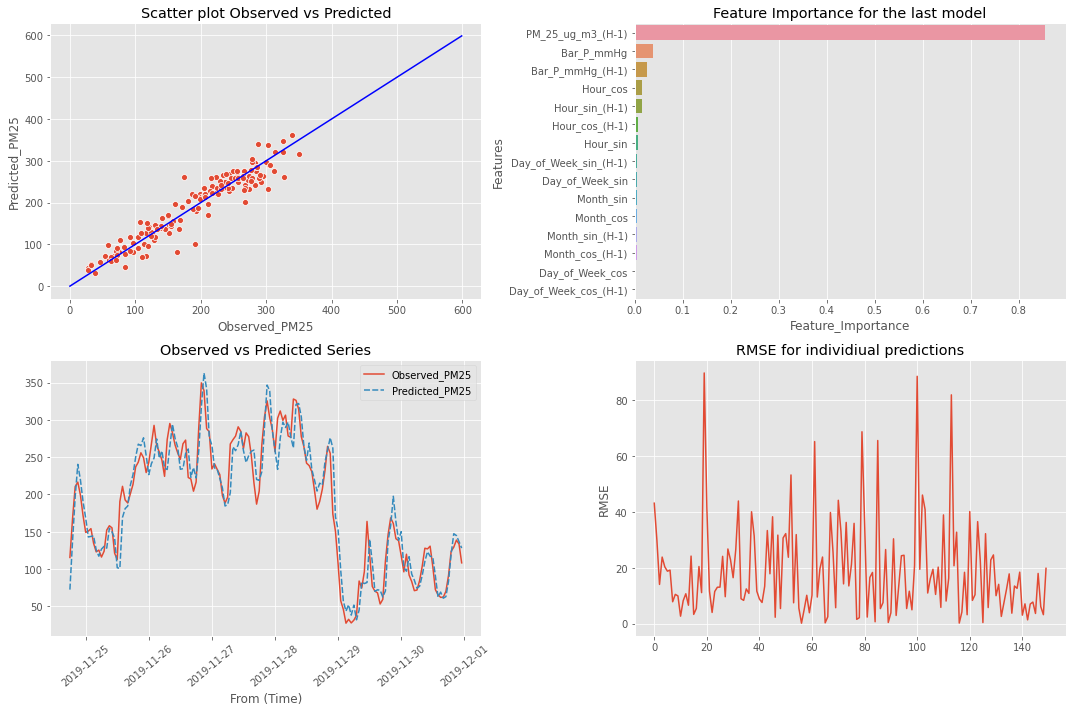

In [378]:
#Default Random Forest Model
start = '2017-01-01 00:00:00'
end = '2019-11-30 23:00:00'
cols = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
        'Day_of_Week_cos','Hour_sin','Hour_cos','Bar_P_mmHg']
mod = RandomForestRegressor()
results = walk_forward(df1,start,end,mod,cols,impute=True,periods=1,log_c=False,
                       predictions=150,test_size=0.0126,random=False)

There is no difference between the model with and without tuning applied for walk-forward validation. Thus adding the time features slightly improved performance in addition to most of the improvement being seen after adding lagging variables.